# Kvalitativna analiza

In [27]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})
from PIL import Image
from IPython.display import display
import torch
from pipeline import square_pad, restore_head, restore_head_alpha_blend, restore_head_poisson_blend, restore_head_pyramid_blend

In [28]:
def preprocess_img(img, square_fn=square_pad, size=512):
    if isinstance(img, Image.Image):
        bg = img.getpixel((0, 0))
    elif isinstance(img, torch.Tensor):
        bg = img[0, 0]
    else:
        raise Exception(f"Unknown image type {type(bg)}")
    img_square = square_fn(img, bg).resize((size, size))

    return img_square

In [29]:
img_orig = Image.open(f"qualitative-analysis-images/originals/000038_0.png").convert("RGB")
img_orig = preprocess_img(img_orig)
head_mask = Image.open(f"qualitative-analysis-images/masks/000038_0_head.png").convert("L")

x, y, w, h = cv2.boundingRect(np.array(head_mask))
padding = 20
x = max(x - padding, 0)
y = max(y - padding, 0)
w = min(w + 2 * padding, img_orig.width - x)
h = min(h + 2 * padding, img_orig.height - y)

## ALPHA BLENDING

Processing img_0...


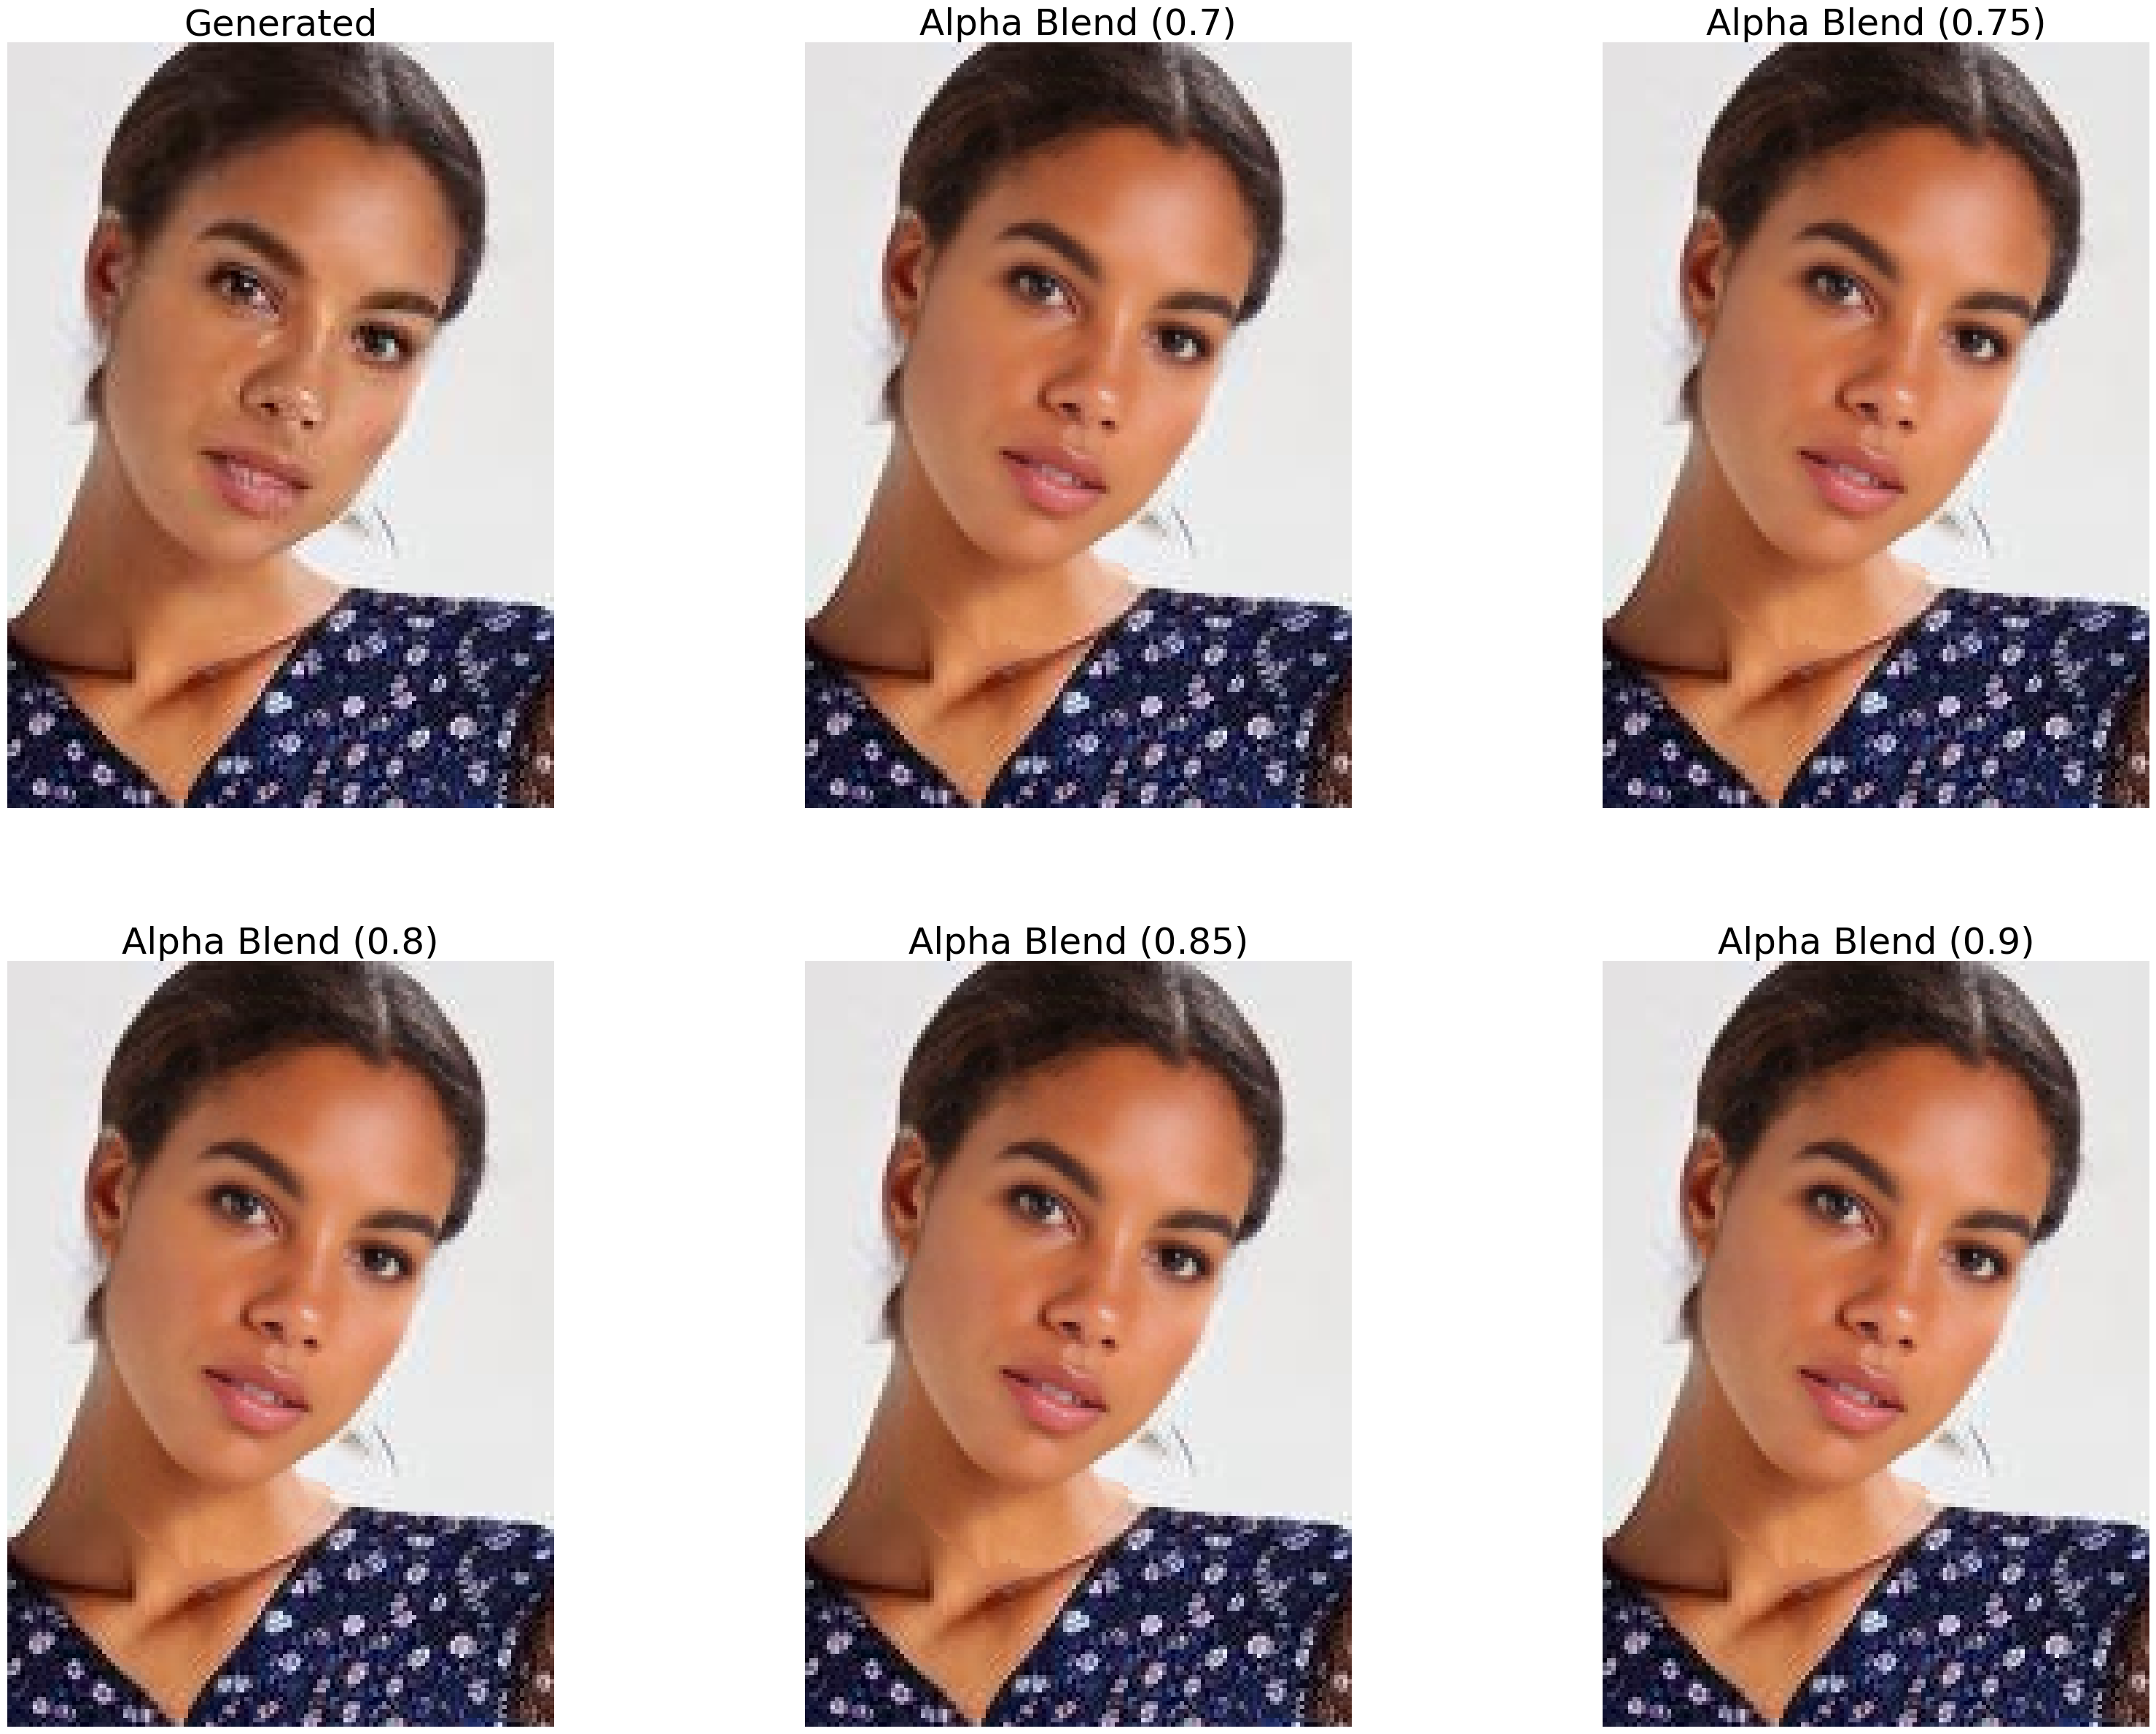

Processing img_1...


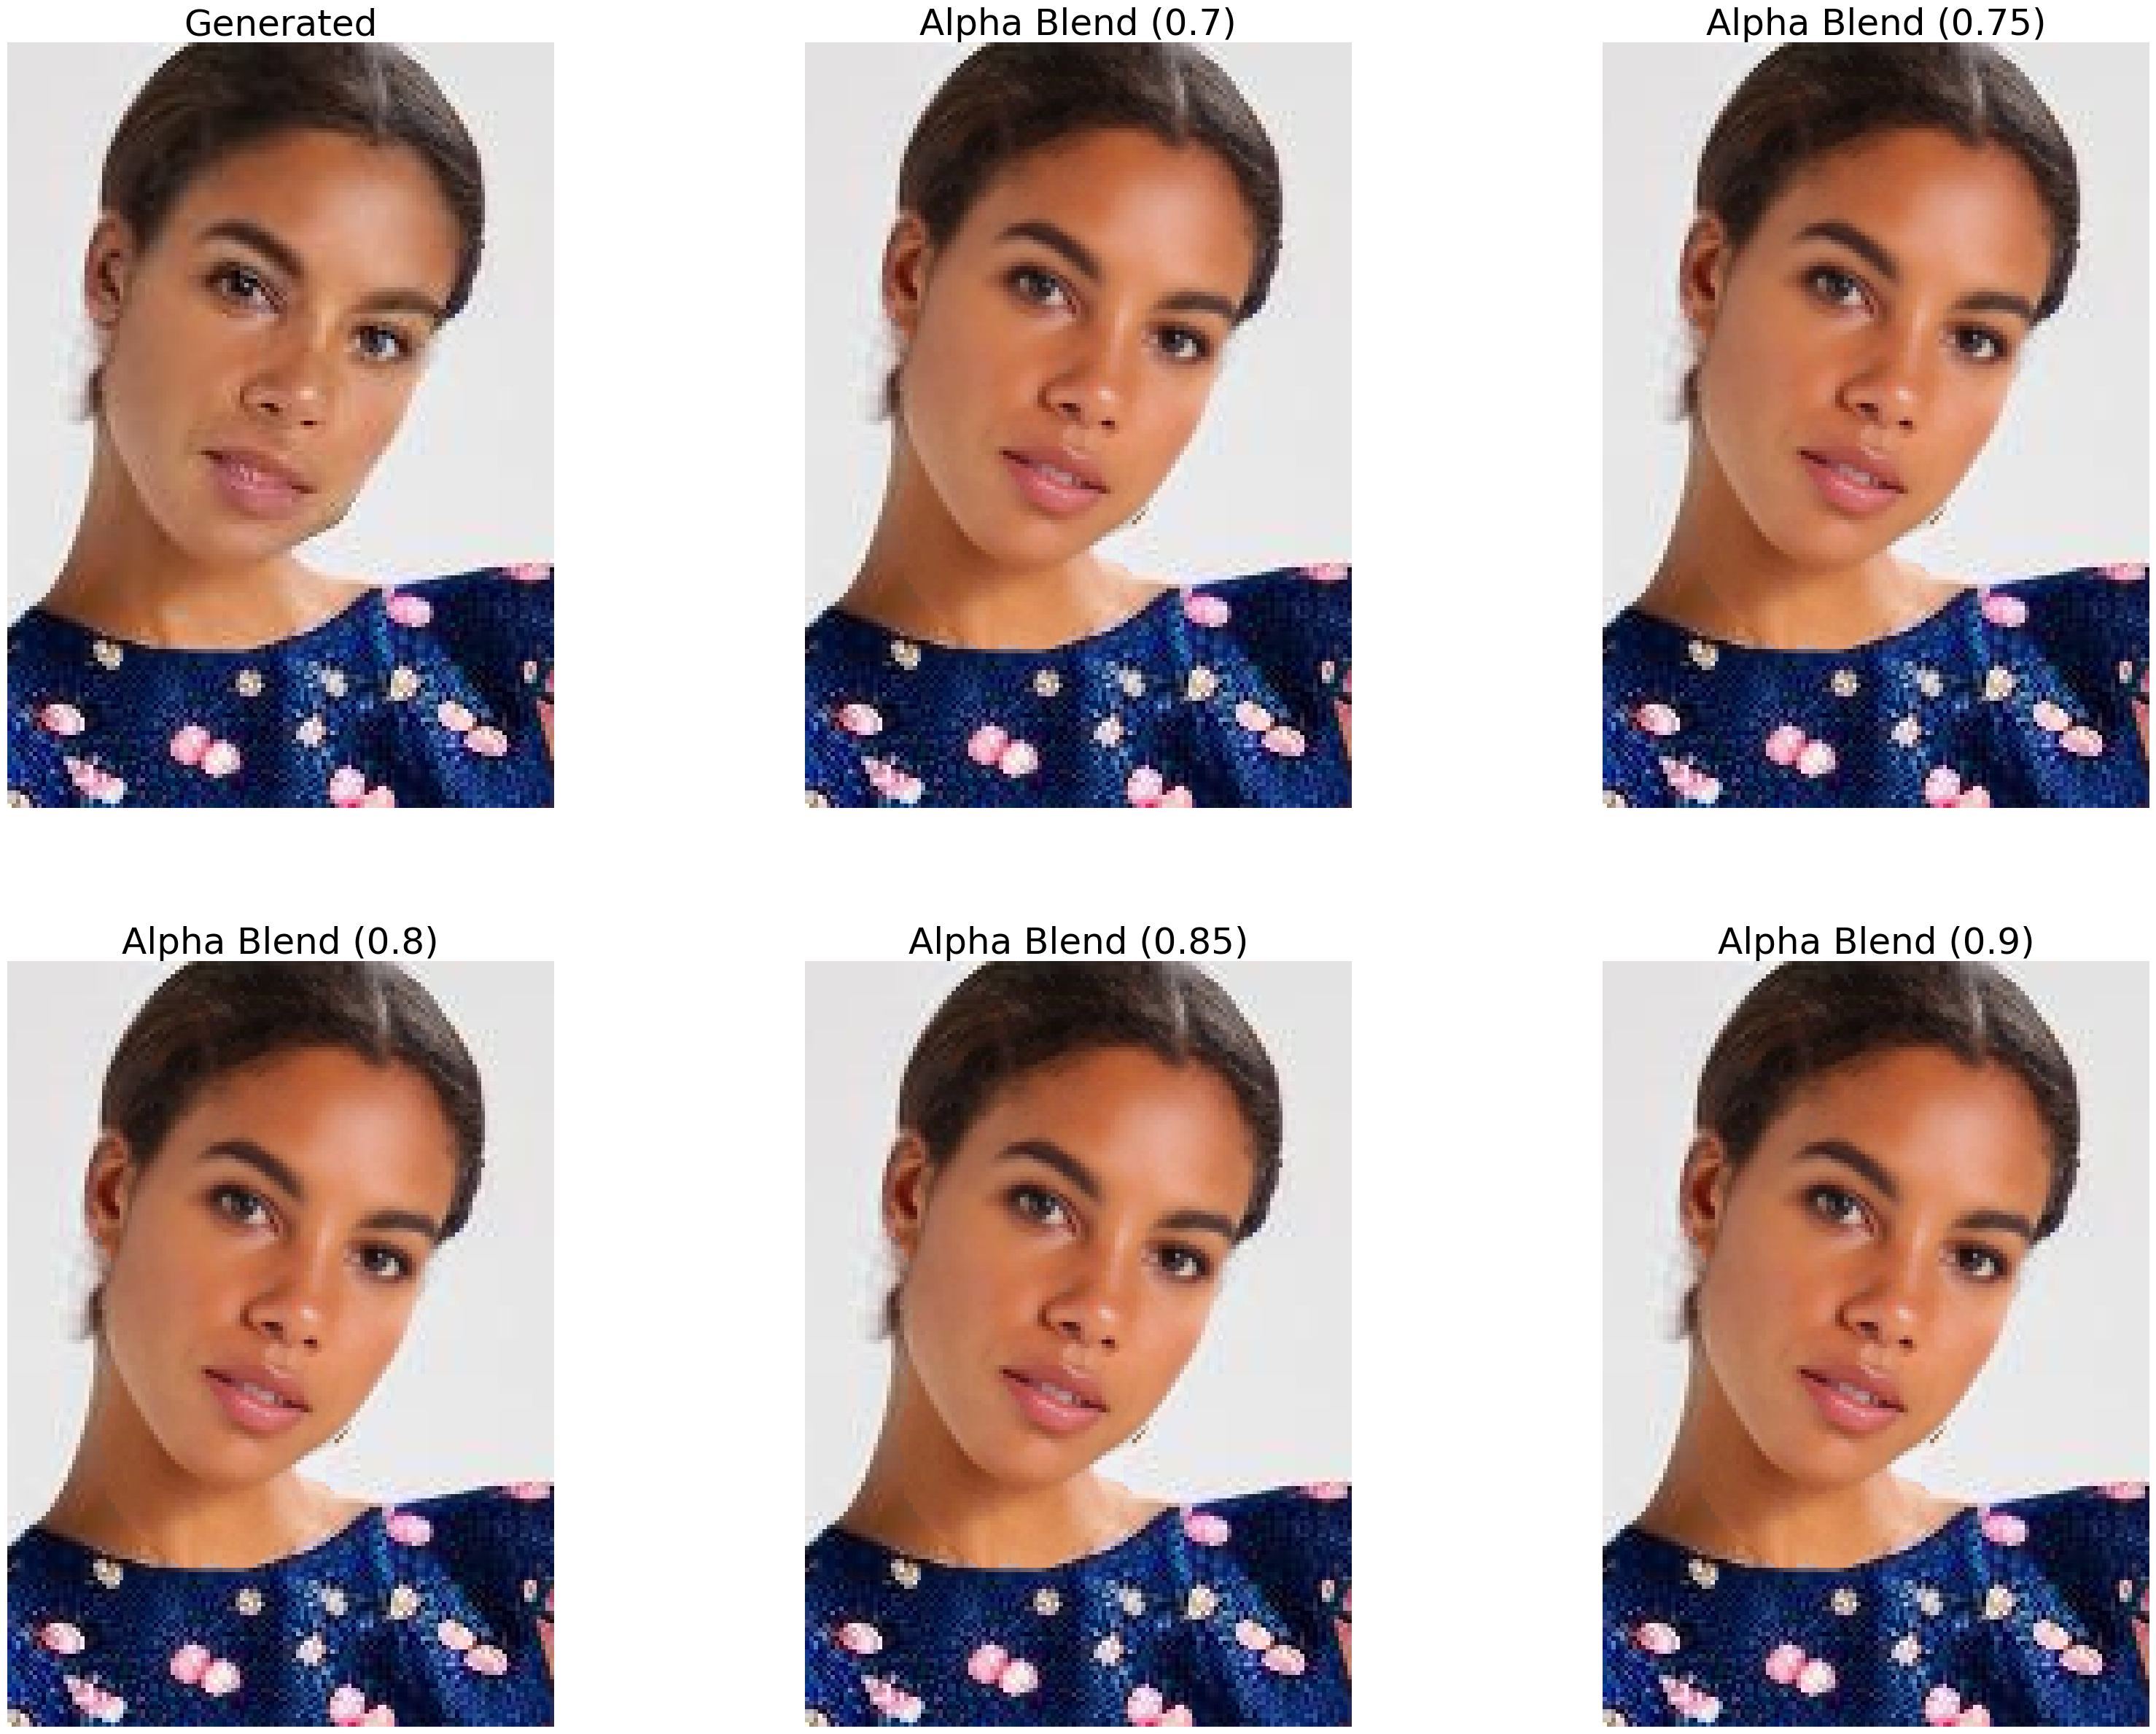

Processing img_2...


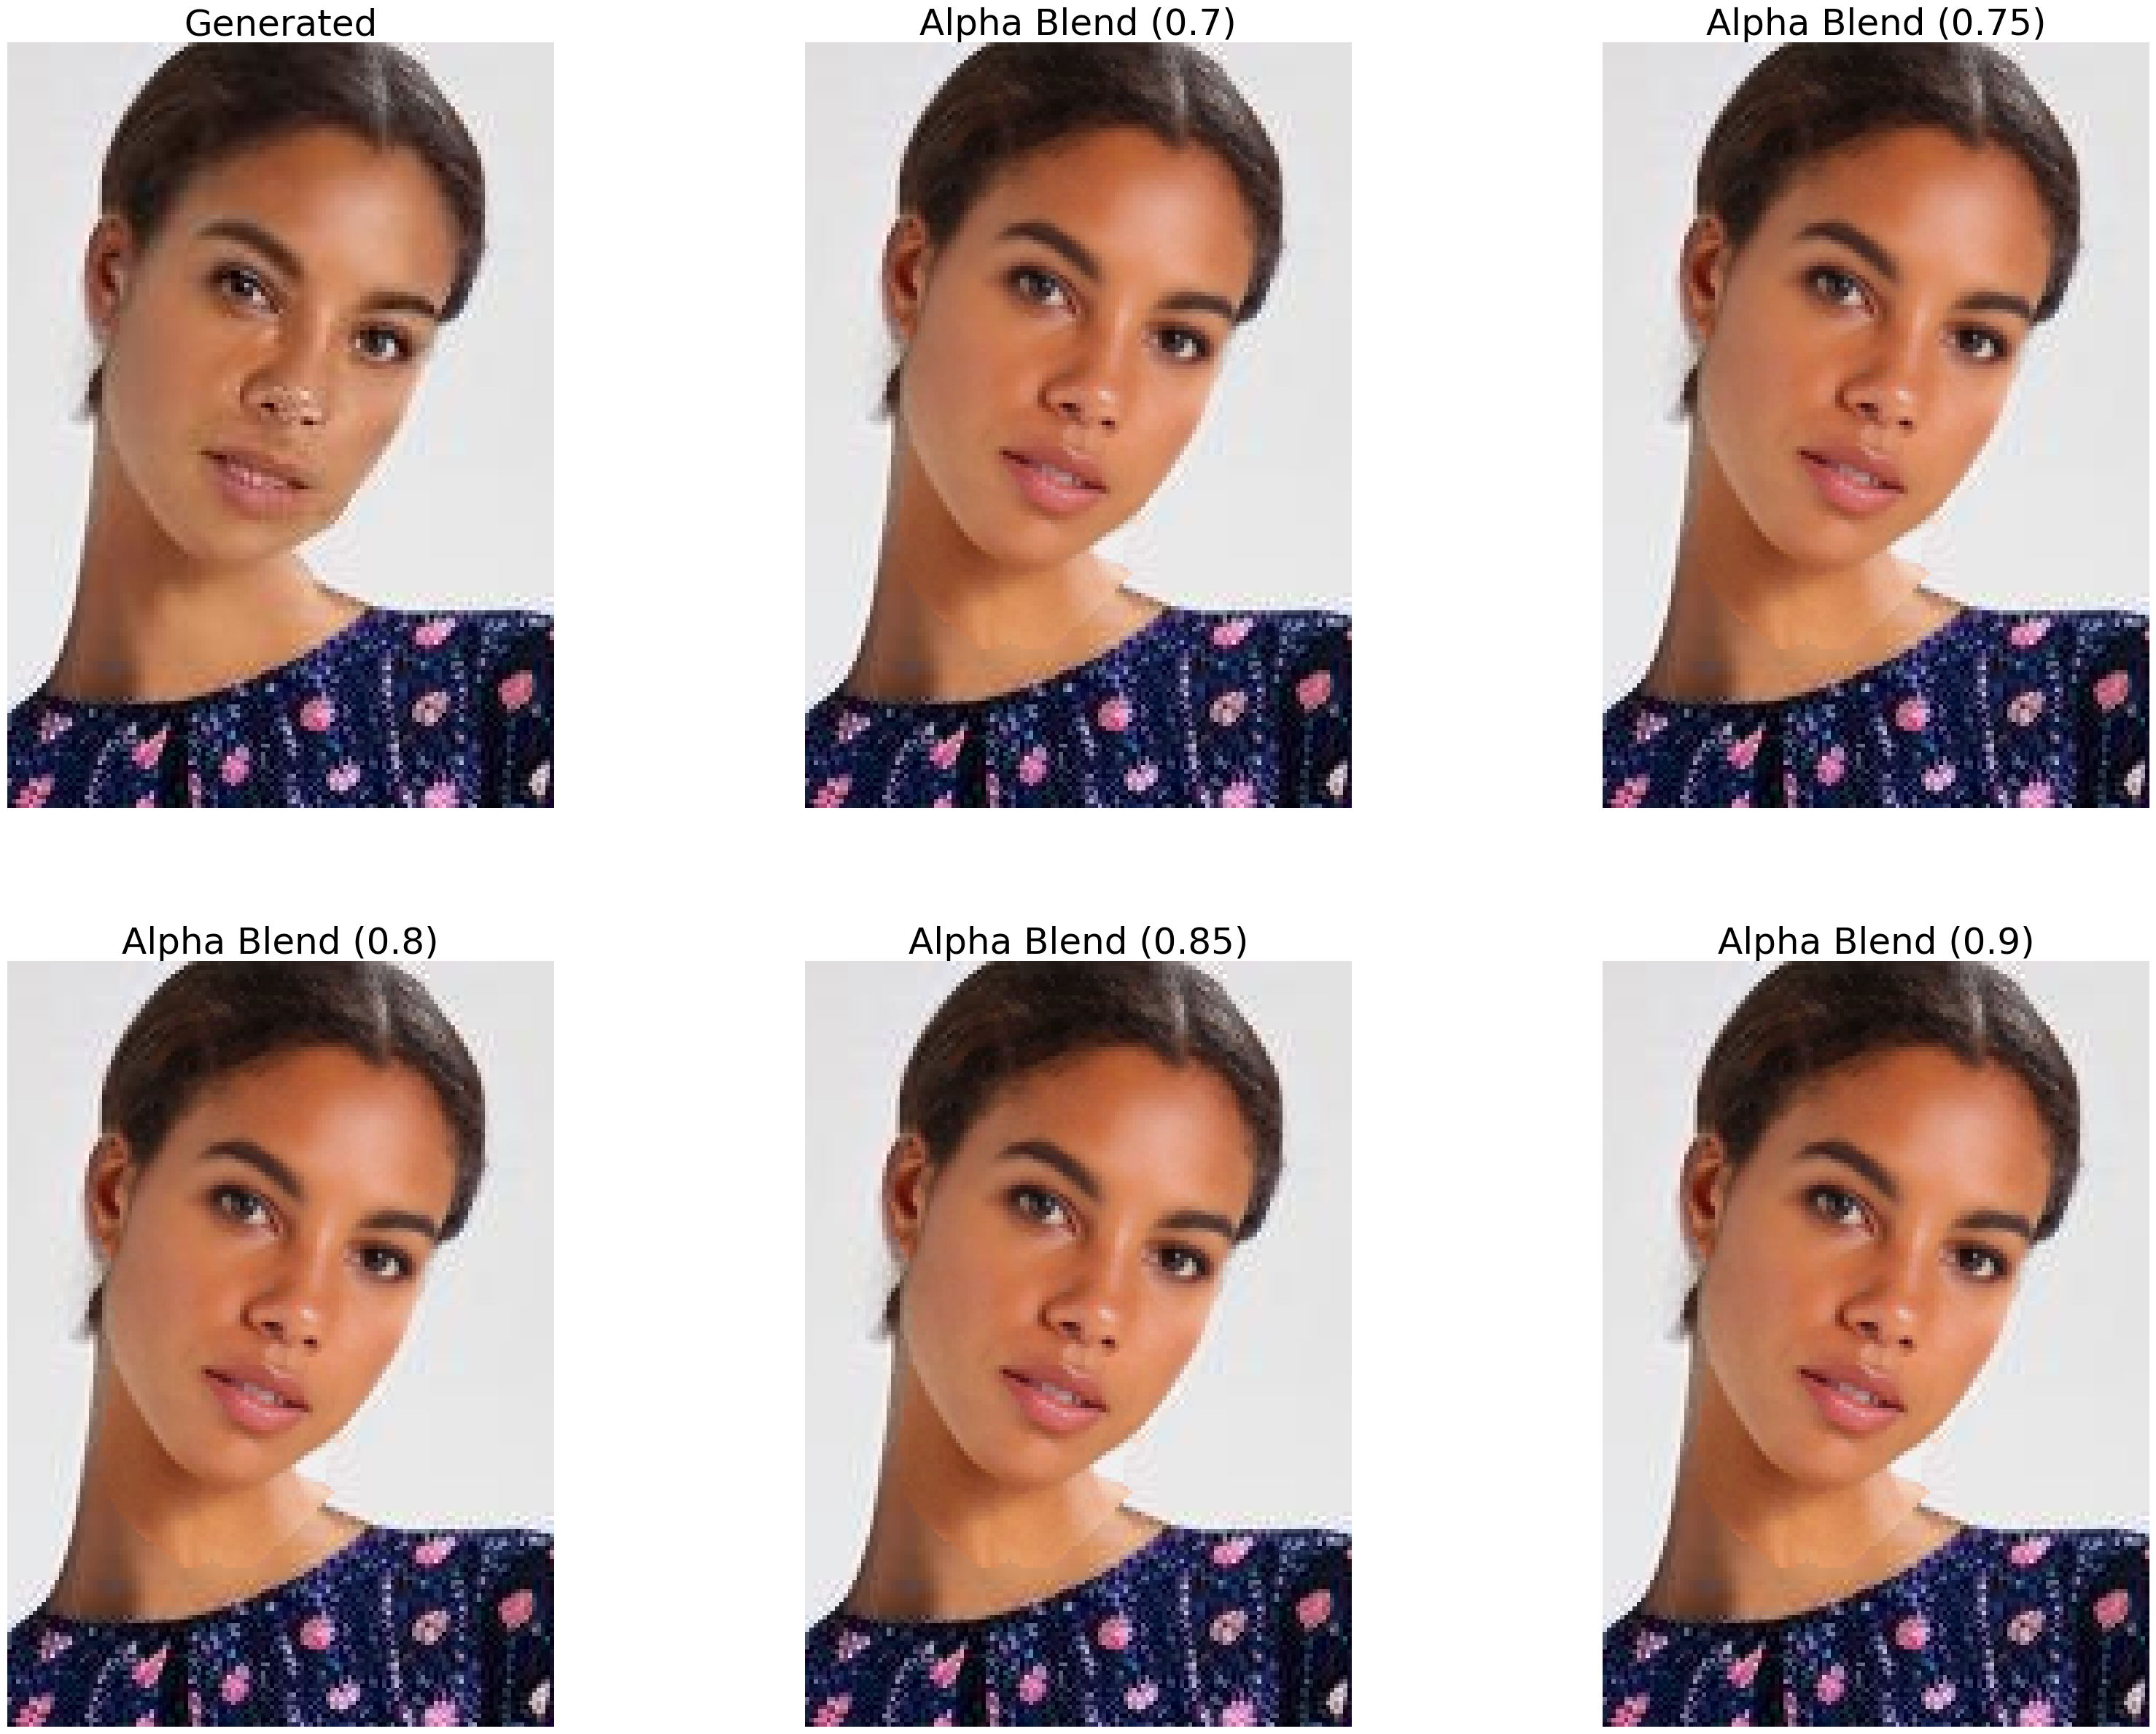

Processing img_3...


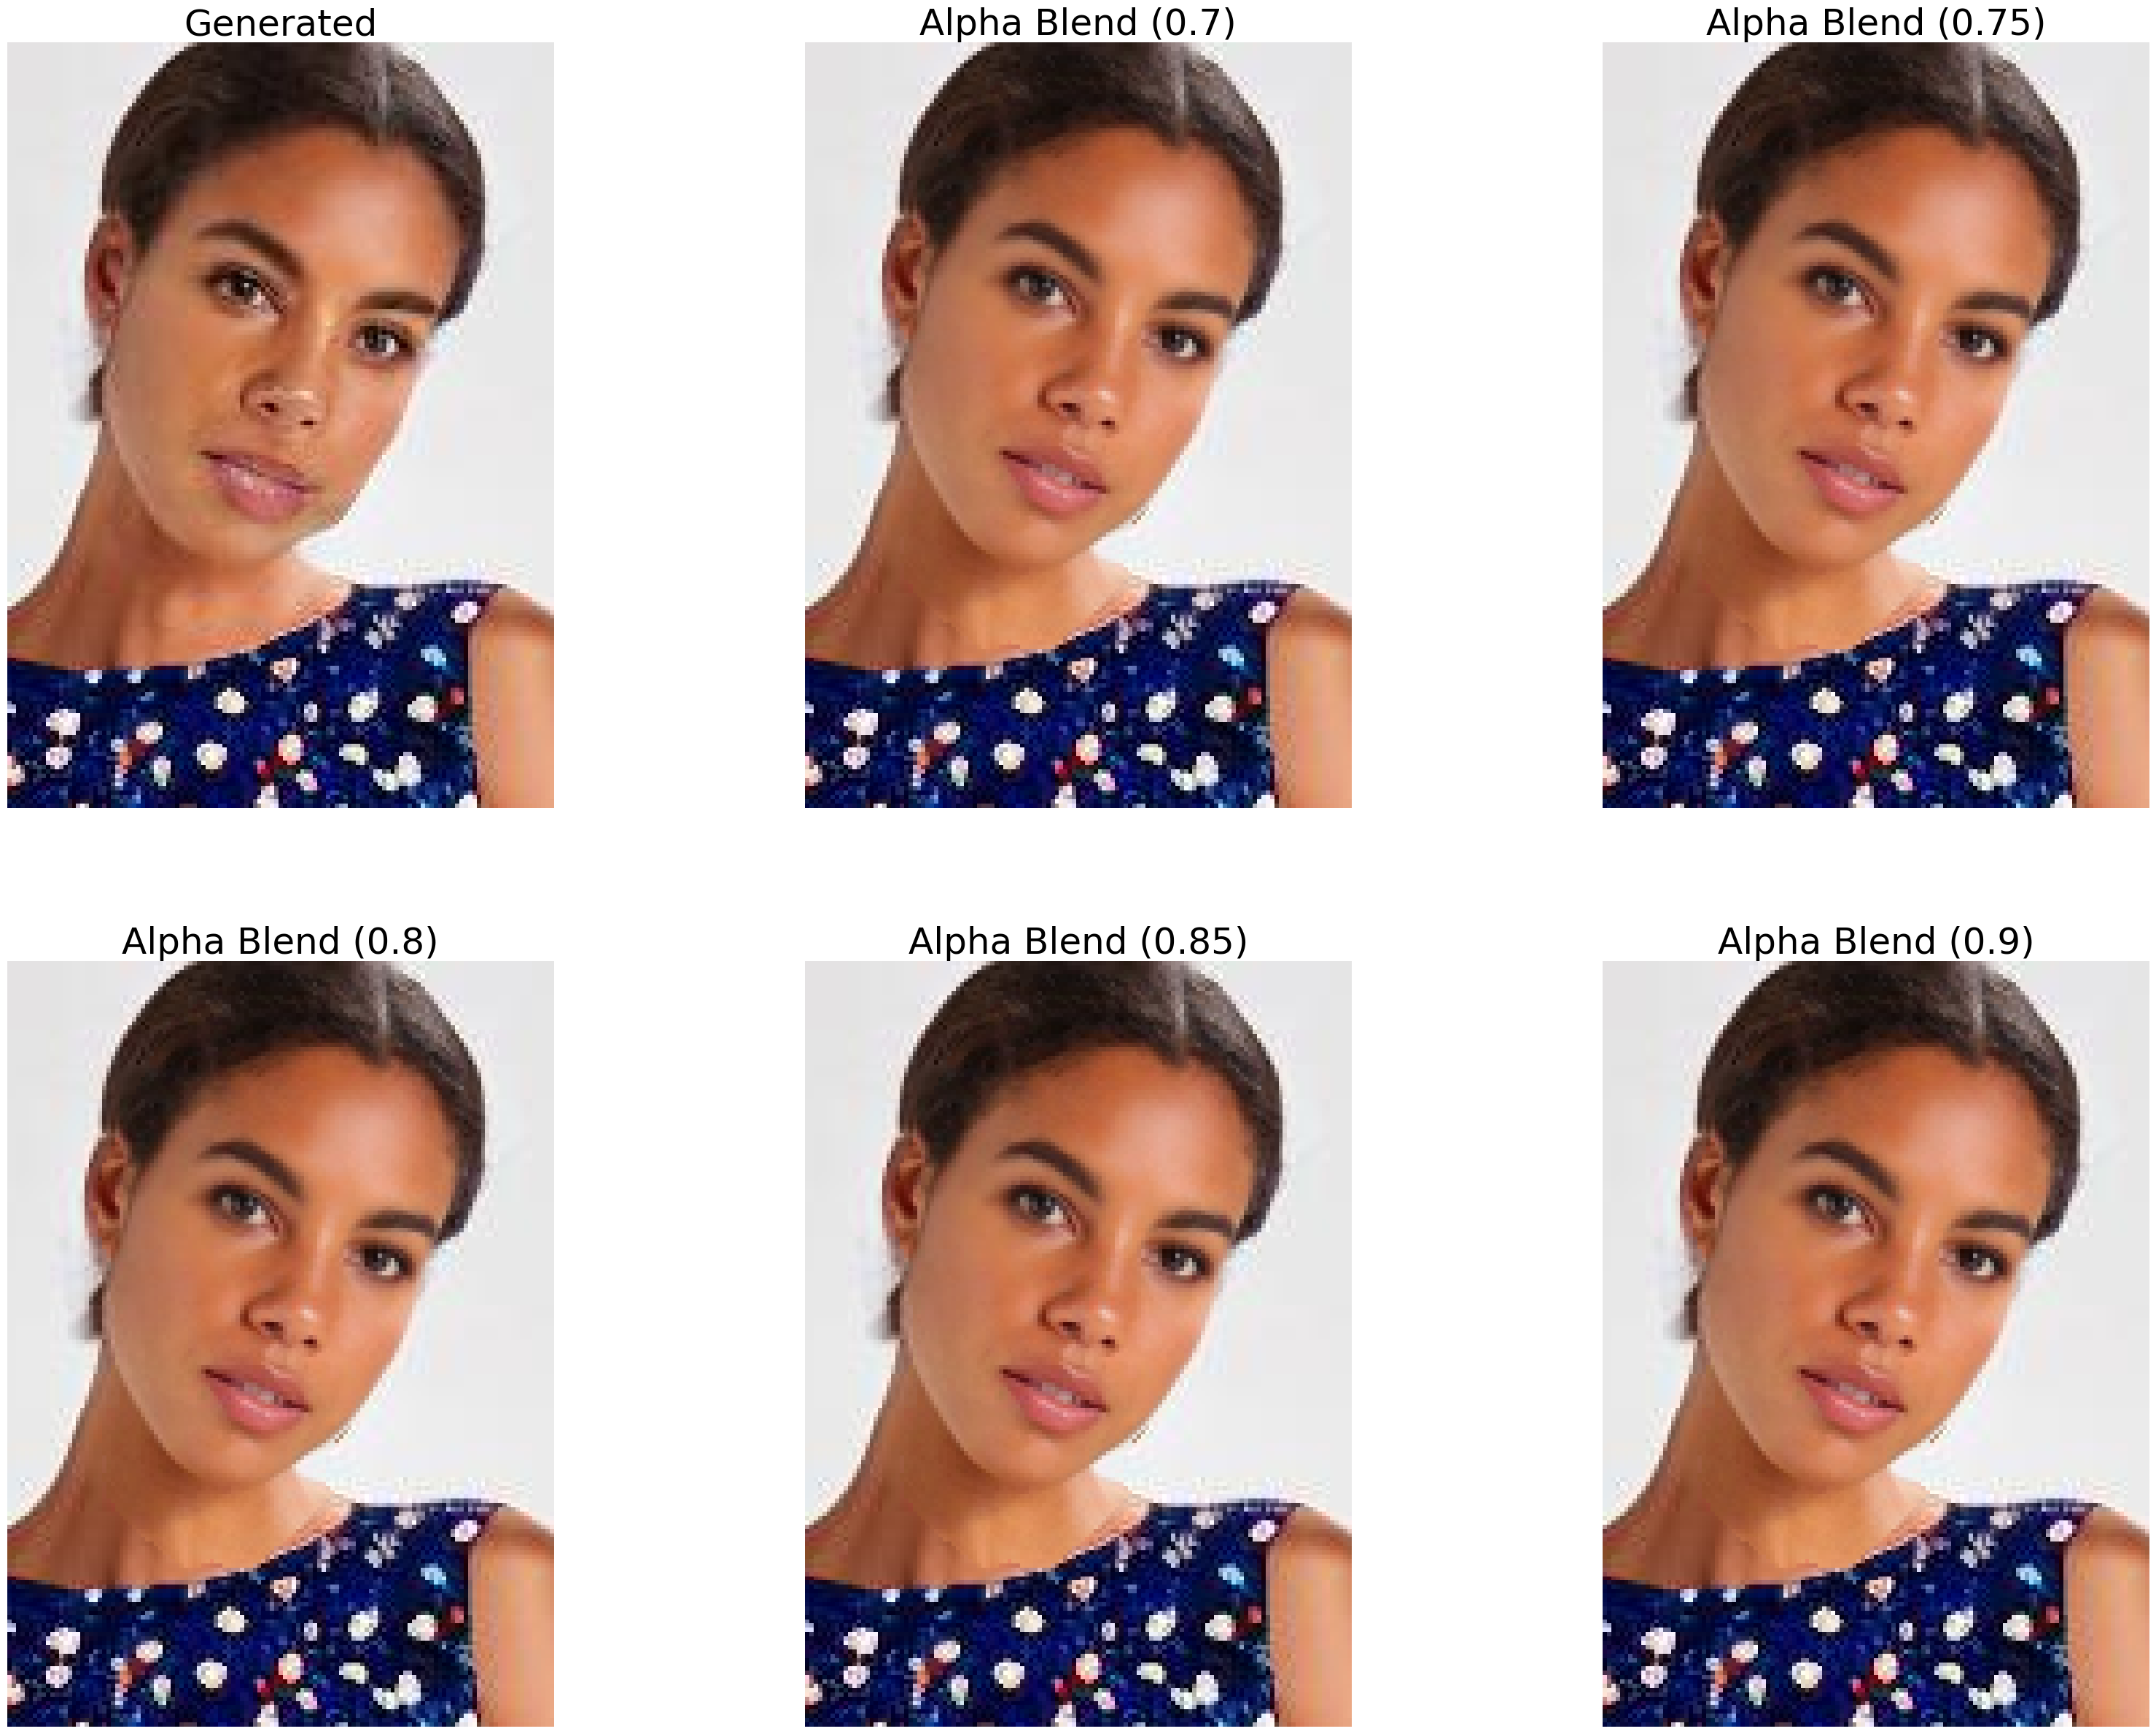

Processing img_4...


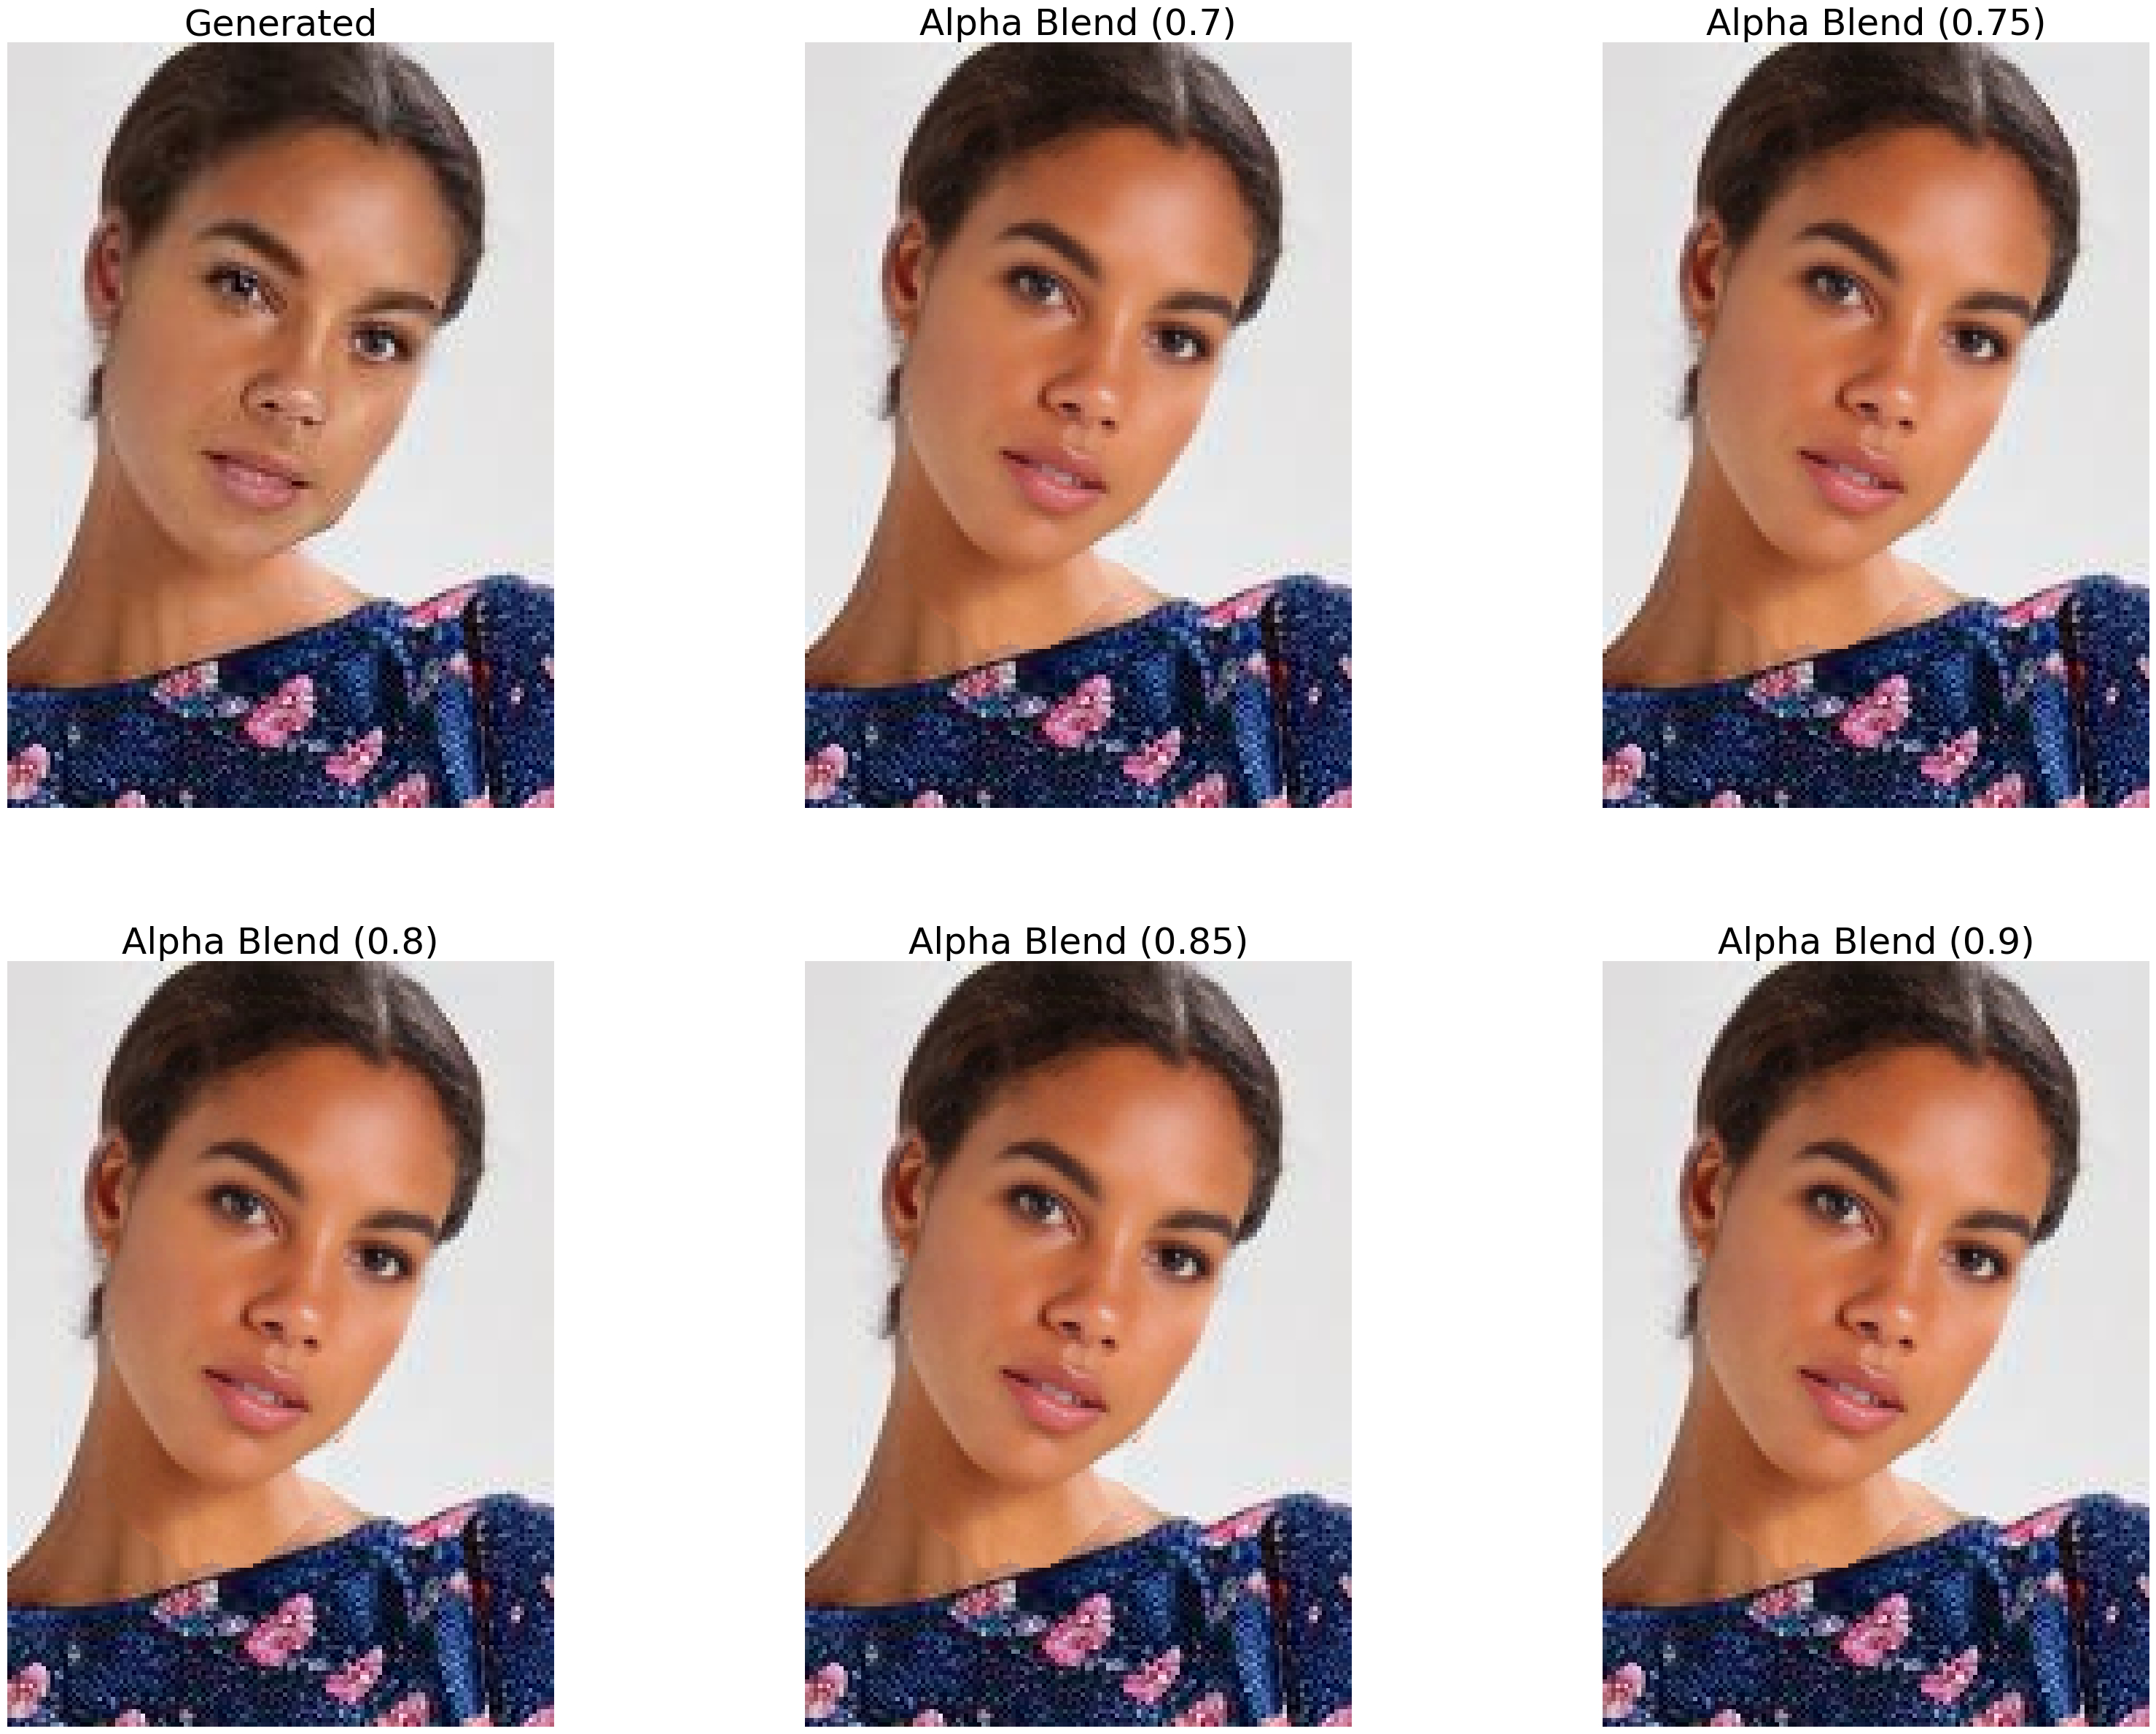

In [30]:
def test_alphas(img_orig, head_mask, image_id):
    img_gen = Image.open(f"qualitative-analysis-images/generated/{image_id}.jpg").convert("RGB")
    alphas = [0.70, 0.75, 0.80, 0.85, 0.9]
    fig, axes = plt.subplots(2, 3, figsize=(40, 30))
    
    # Plot the generated image first
    ax = axes[0, 0]
    ax.imshow(img_gen.crop((x, y, x + w, y + h)))
    ax.set_title("Generated")
    ax.axis("off")
    
    for i, alpha in enumerate(alphas):
        alpha_blended = restore_head_alpha_blend(img_orig.copy(), img_gen.copy(), head_mask, alpha)
        alpha_blended = alpha_blended.crop((x, y, x + w, y + h))
        alpha_blended.save(os.path.join("./output/alpha", f"{image_id}_alpha_{alpha:.2f}.jpg"))
        ax = axes[(i + 1) // 3, (i + 1) % 3]
        ax.imshow(alpha_blended)
        ax.set_title(f"Alpha Blend ({alpha})")
        ax.axis("off")
    
    plt.savefig(f"./output/alpha/{image_id}.png")
    plt.show()


image_ids = [f"img_{i}" for i in range(5)]  
for img_id in image_ids:
    print(f"Processing {img_id}...")
    test_alphas(img_orig, head_mask, img_id)

### Izbira parametra alpha
Na podlagi zgornjih slik, ki so bili narejeni za različne vrednosti parametra alpha, se zdi, da je najboljša vrednost parametra alpha med 0.7 in 0.8. 

## POISSON BLENDING

In [31]:
def test_poisson(img_orig, head_mask, image_id):
    os.makedirs("./output/poisson", exist_ok=True) 
    img_gen = Image.open(f"generated/{image_id}.jpg").convert("RGB")
    dilations = [2, 3, 4, 5, 6, 7]
    fig, axes = plt.subplots(2, 3, figsize=(40, 30))
    
    idx = 0
    for dilation in dilations:
        blended = restore_head_poisson_blend(img_orig.copy(), img_gen.copy(), head_mask, dilation_size=dilation)
        blended = blended.crop((x, y, x + w, y + h))
        blended.save(os.path.join("./output/poisson", f"{image_id}_poisson_{dilation}.jpg"))
        ax = axes[idx // 3, idx % 3]
        ax.imshow(blended)
        ax.set_title(f"(dilation={dilation})")
        ax.axis("off")
        idx += 1
    
    plt.savefig(f"./output/poisson/{image_id}_poisson_params.png")
    plt.show()

image_ids = [f"img_{i}" for i in range(5)] 
for img_id in image_ids:
    print(f"Processing {img_id}...")
    test_poisson(img_orig, head_mask, img_id)

Processing img_0...


FileNotFoundError: [Errno 2] No such file or directory: 'generated/img_0.jpg'

### Izbira parametra za Poisson blending
Na podlagi zgornjih slik, ki so bili narejeni za različne vrednosti parametra za Poisson blending, se zdi, da je najboljša vrednost parametra med 4 in 5.

## PYRAMID BLENDING

Processing img_0...


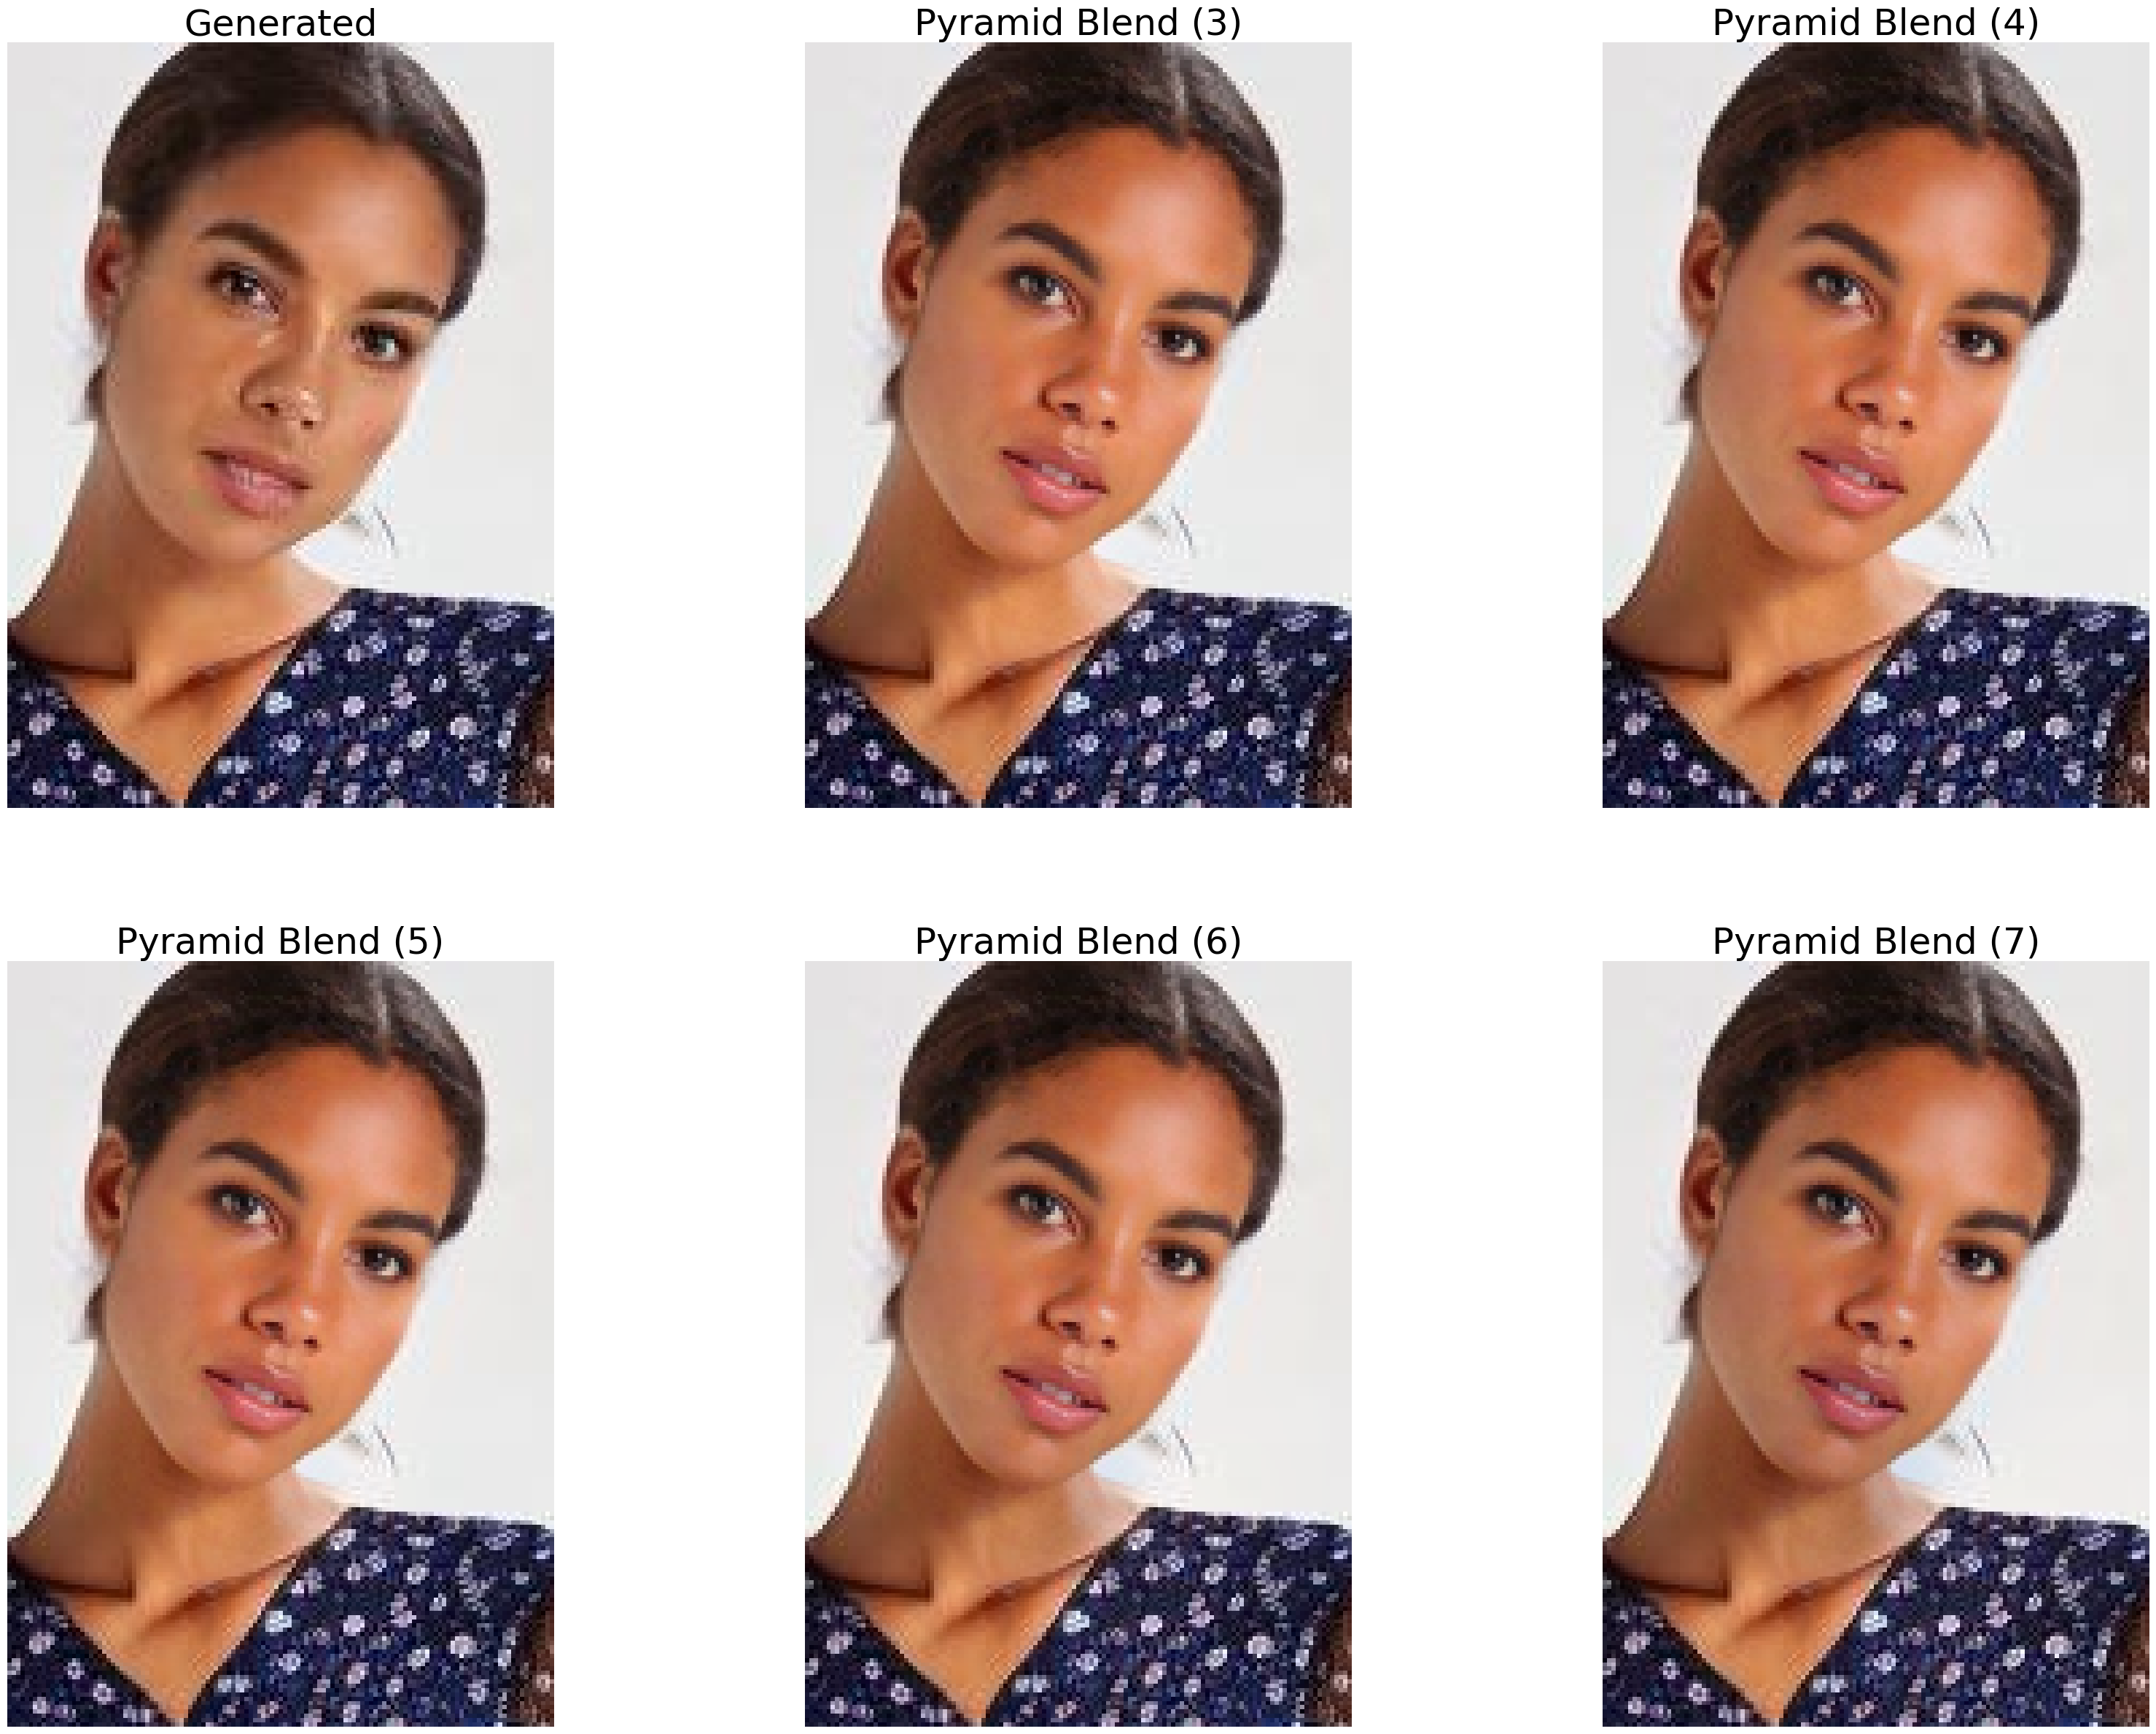

Processing img_1...


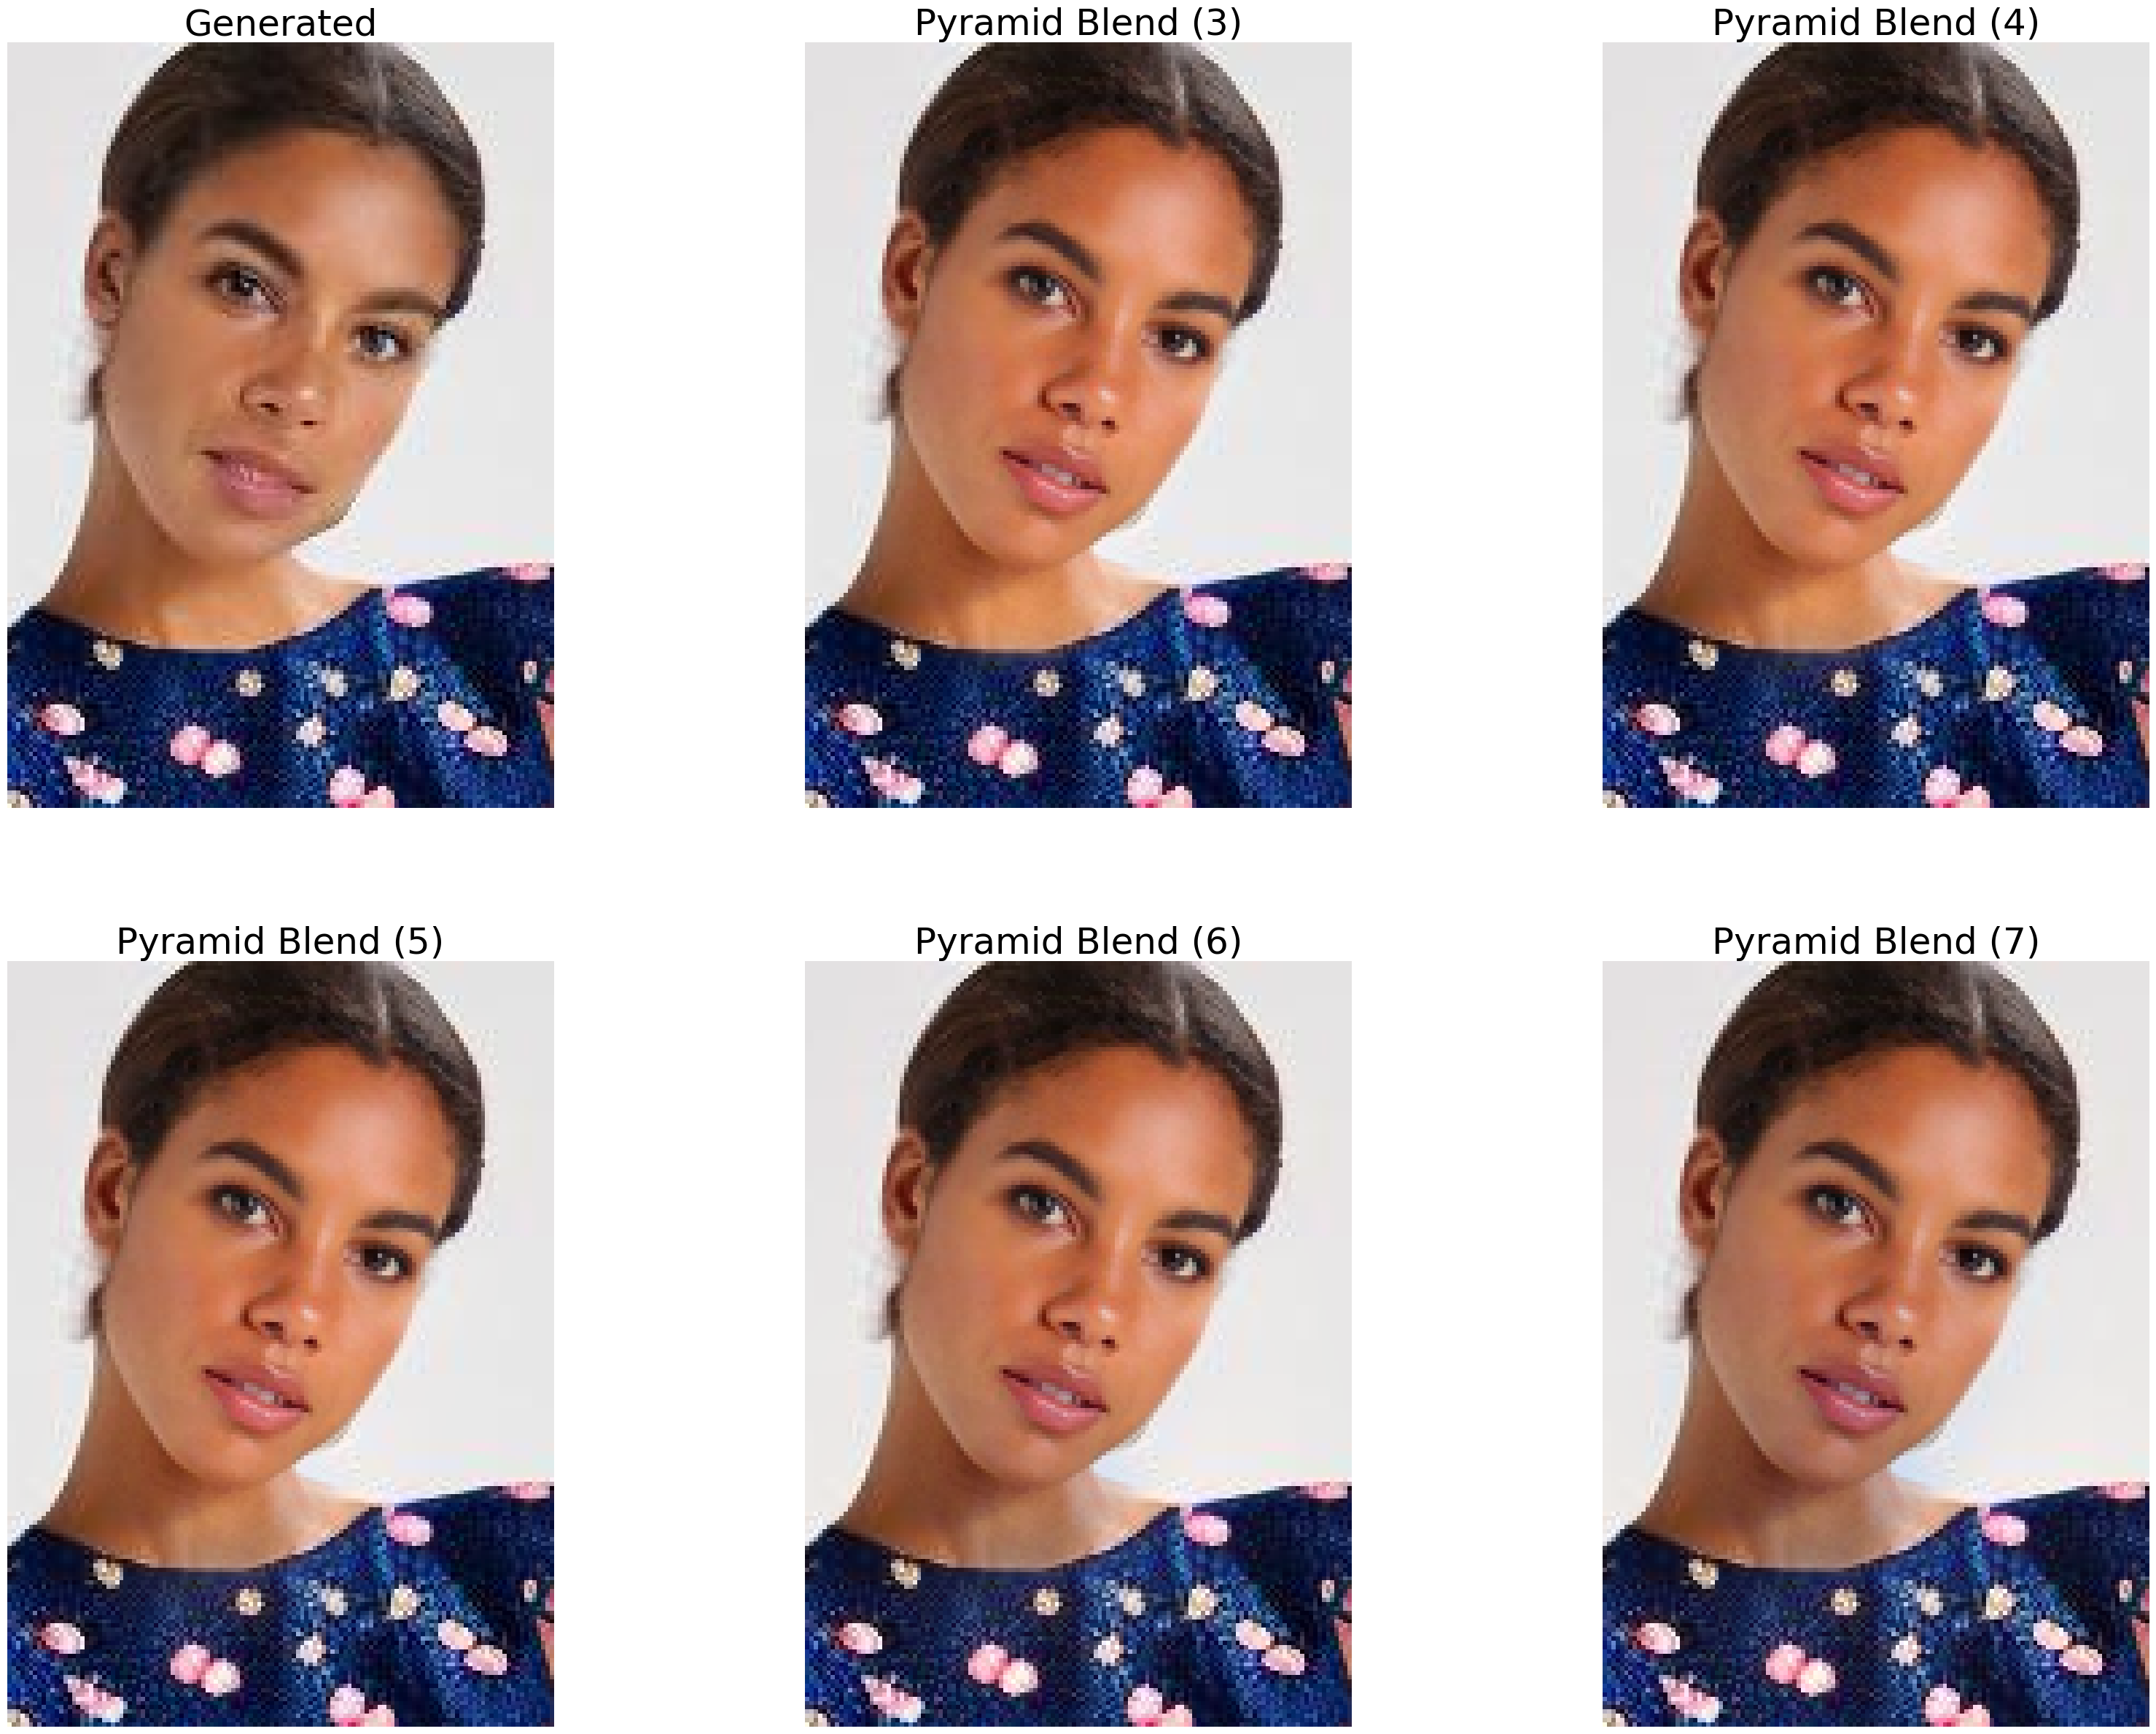

Processing img_2...


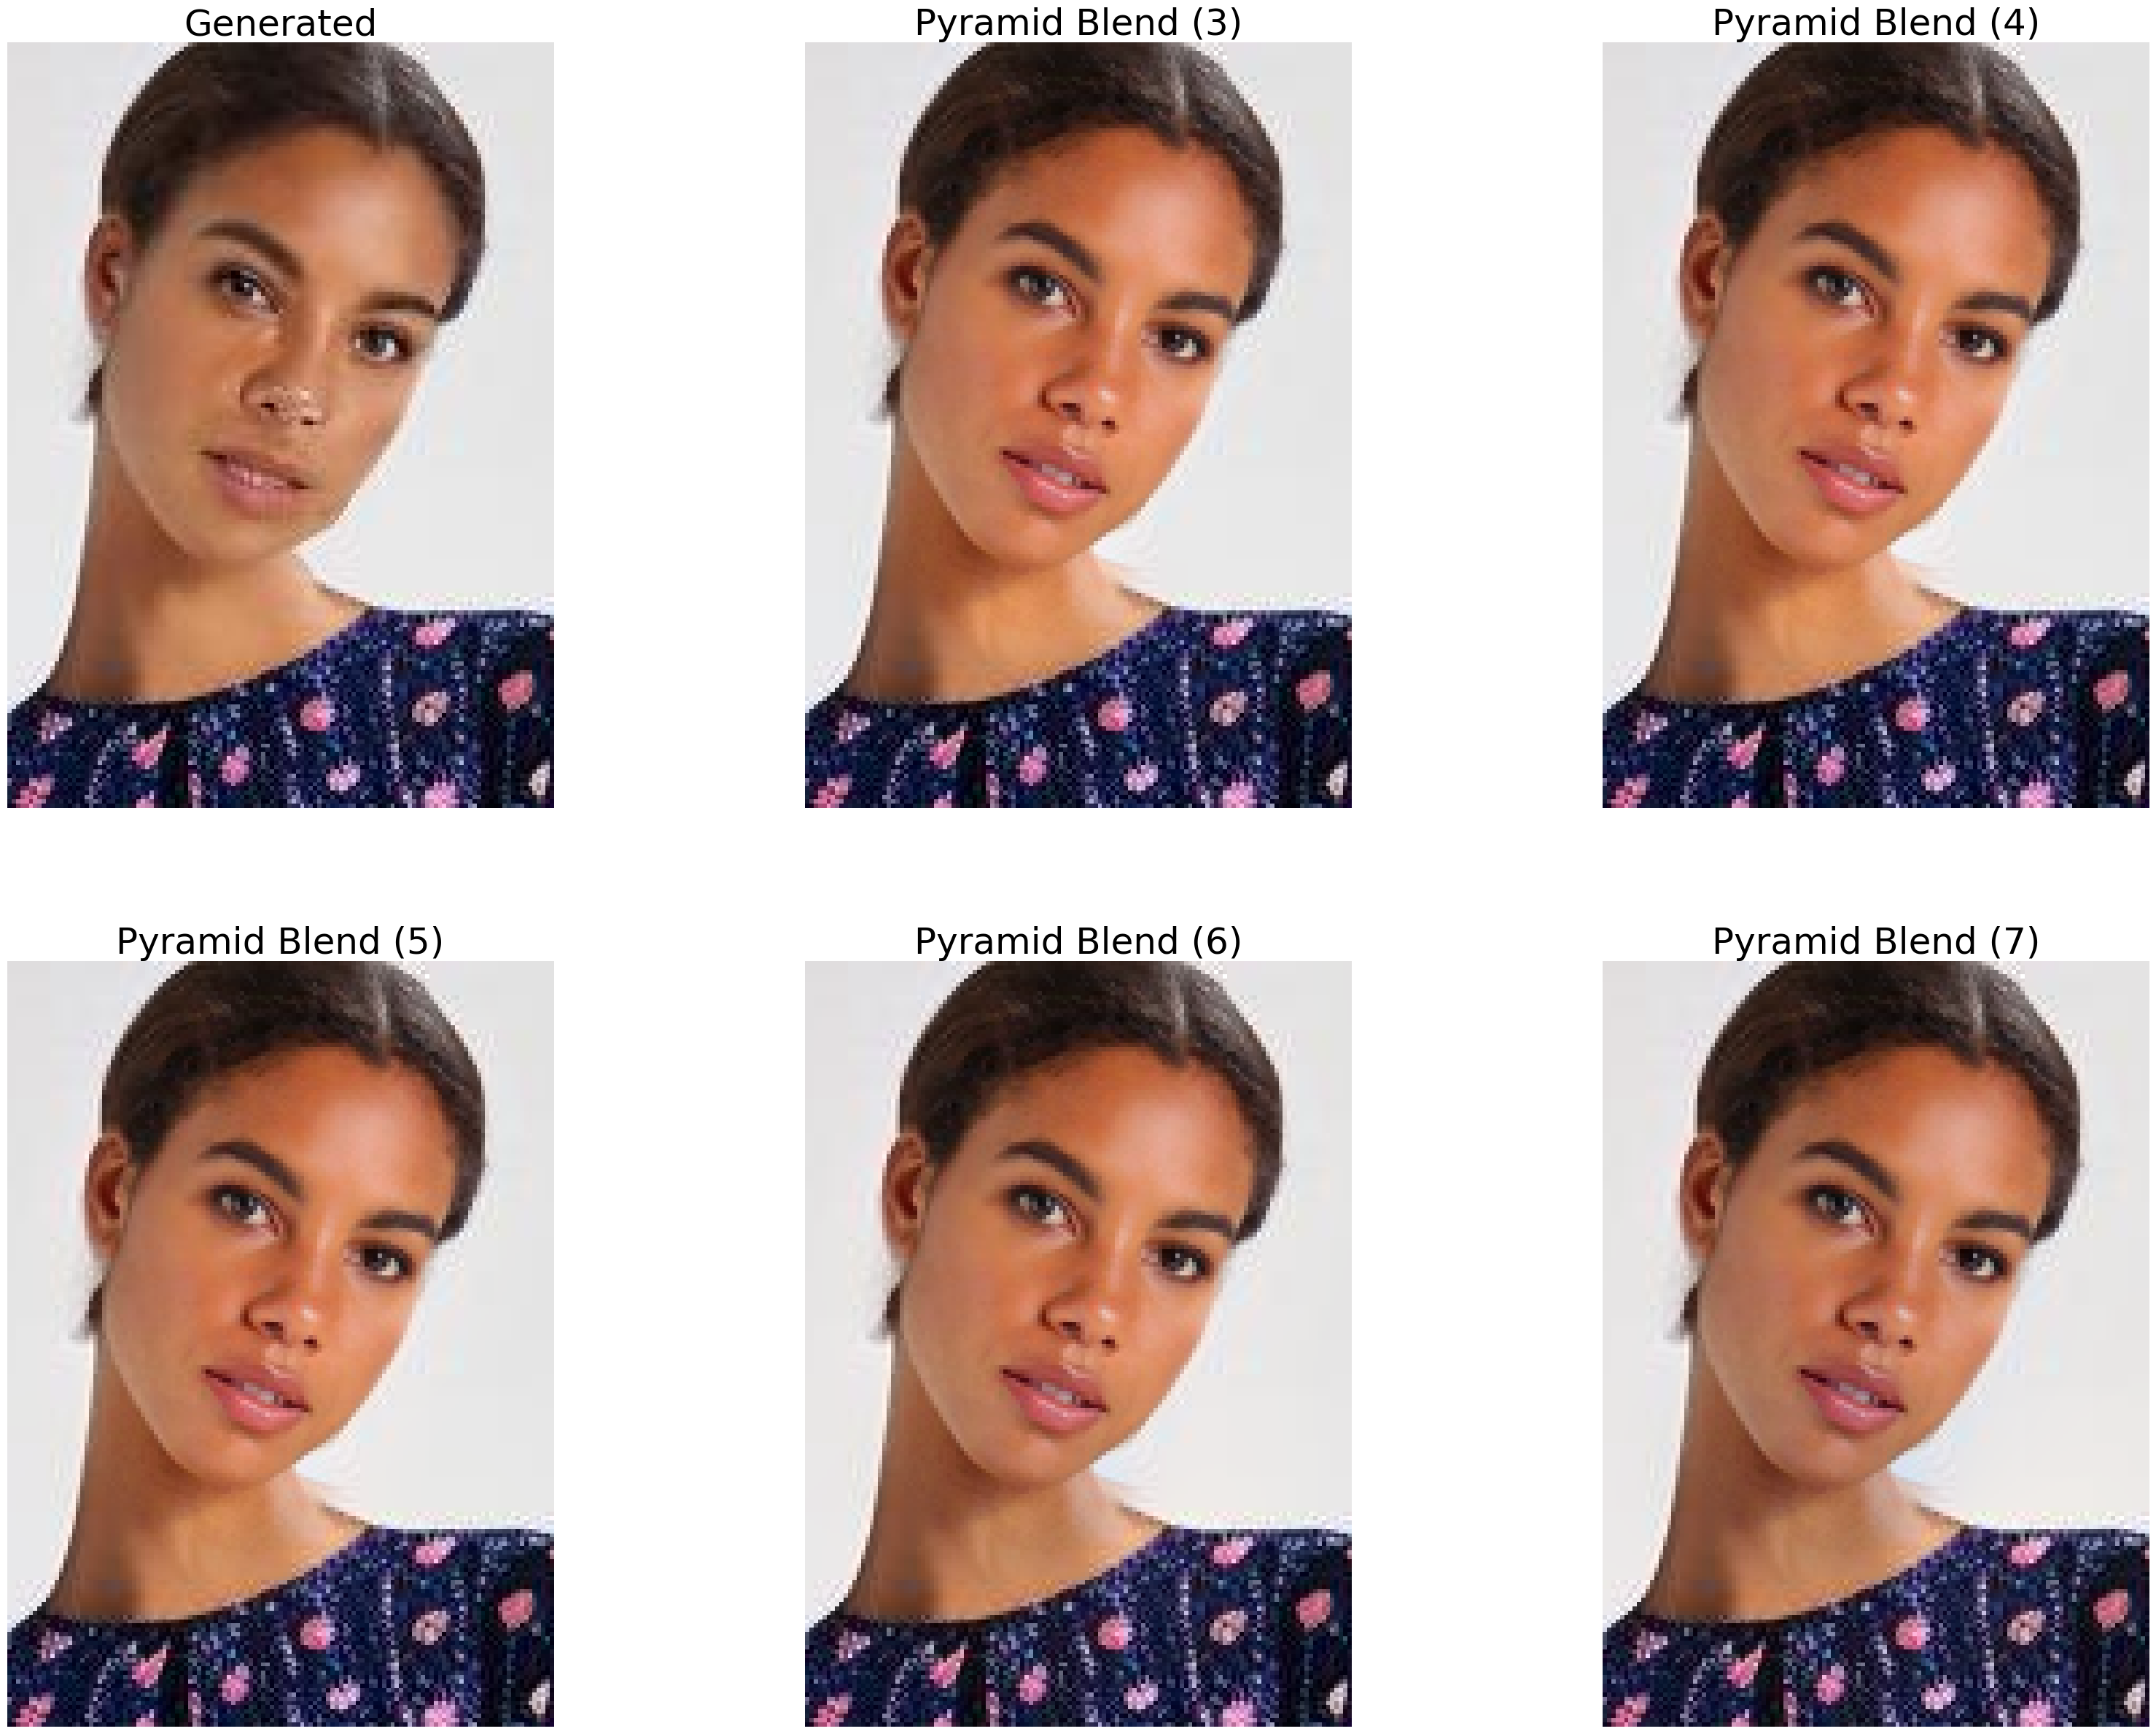

Processing img_3...


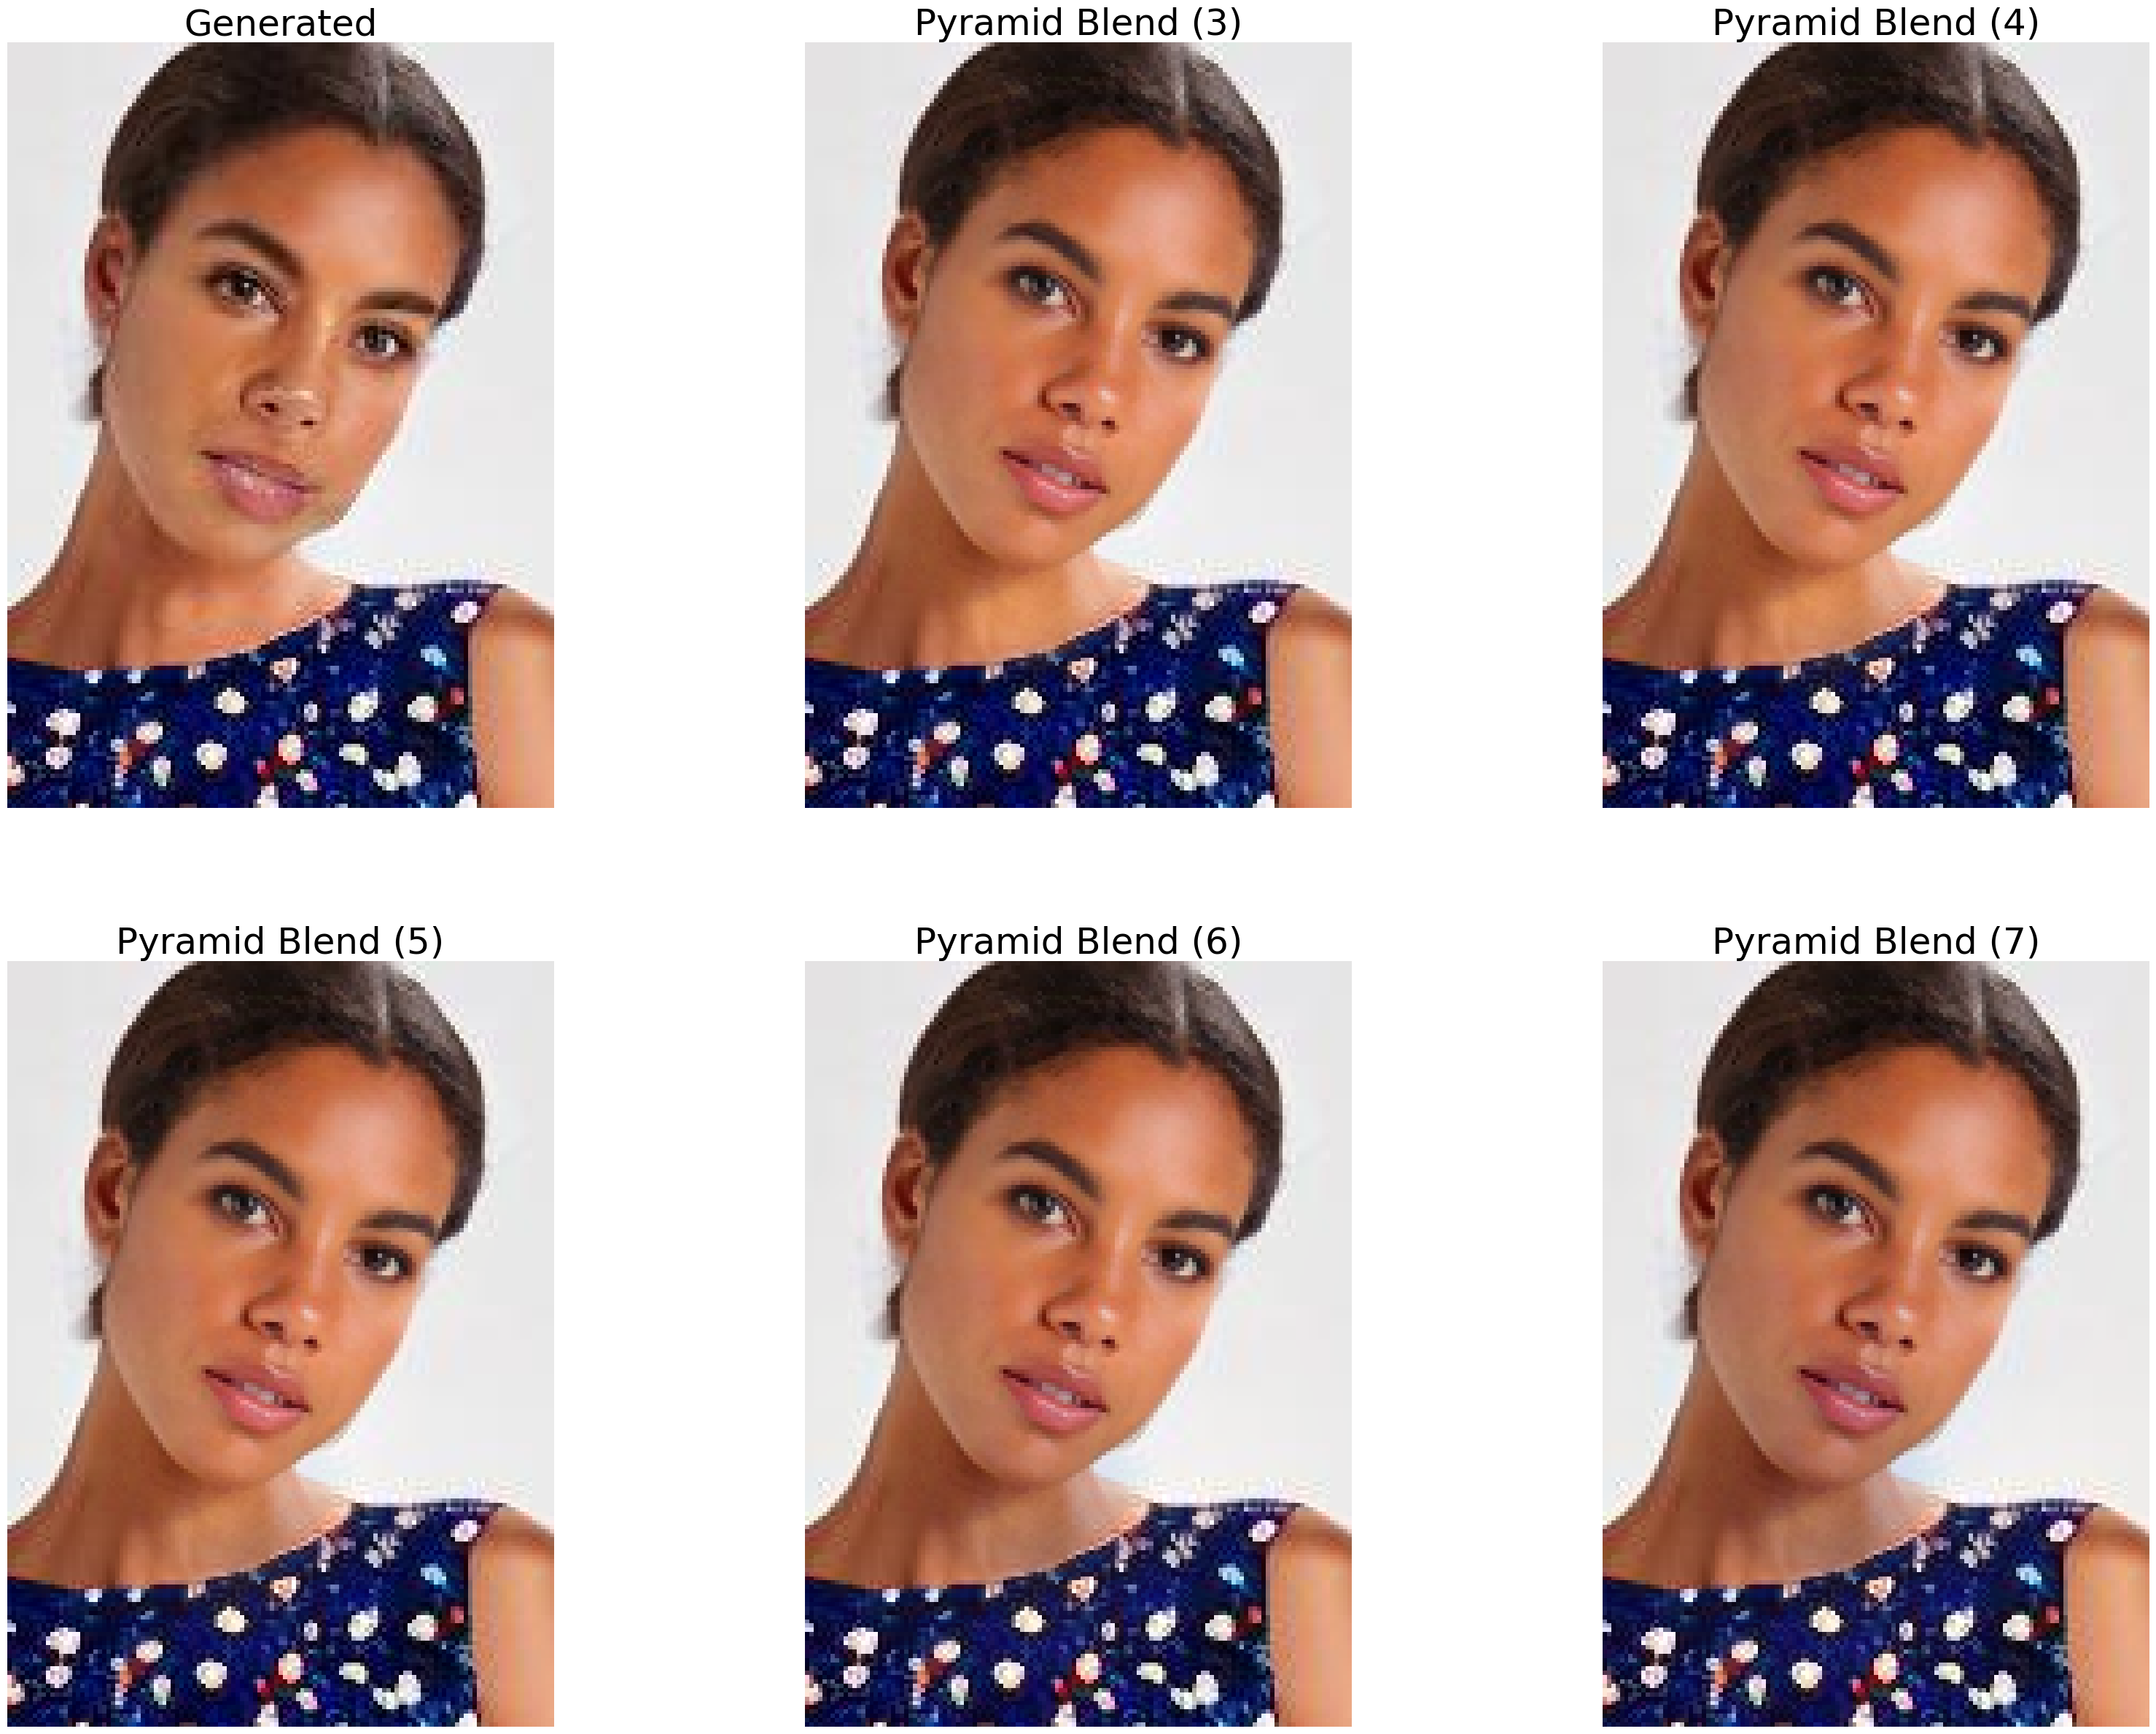

Processing img_4...


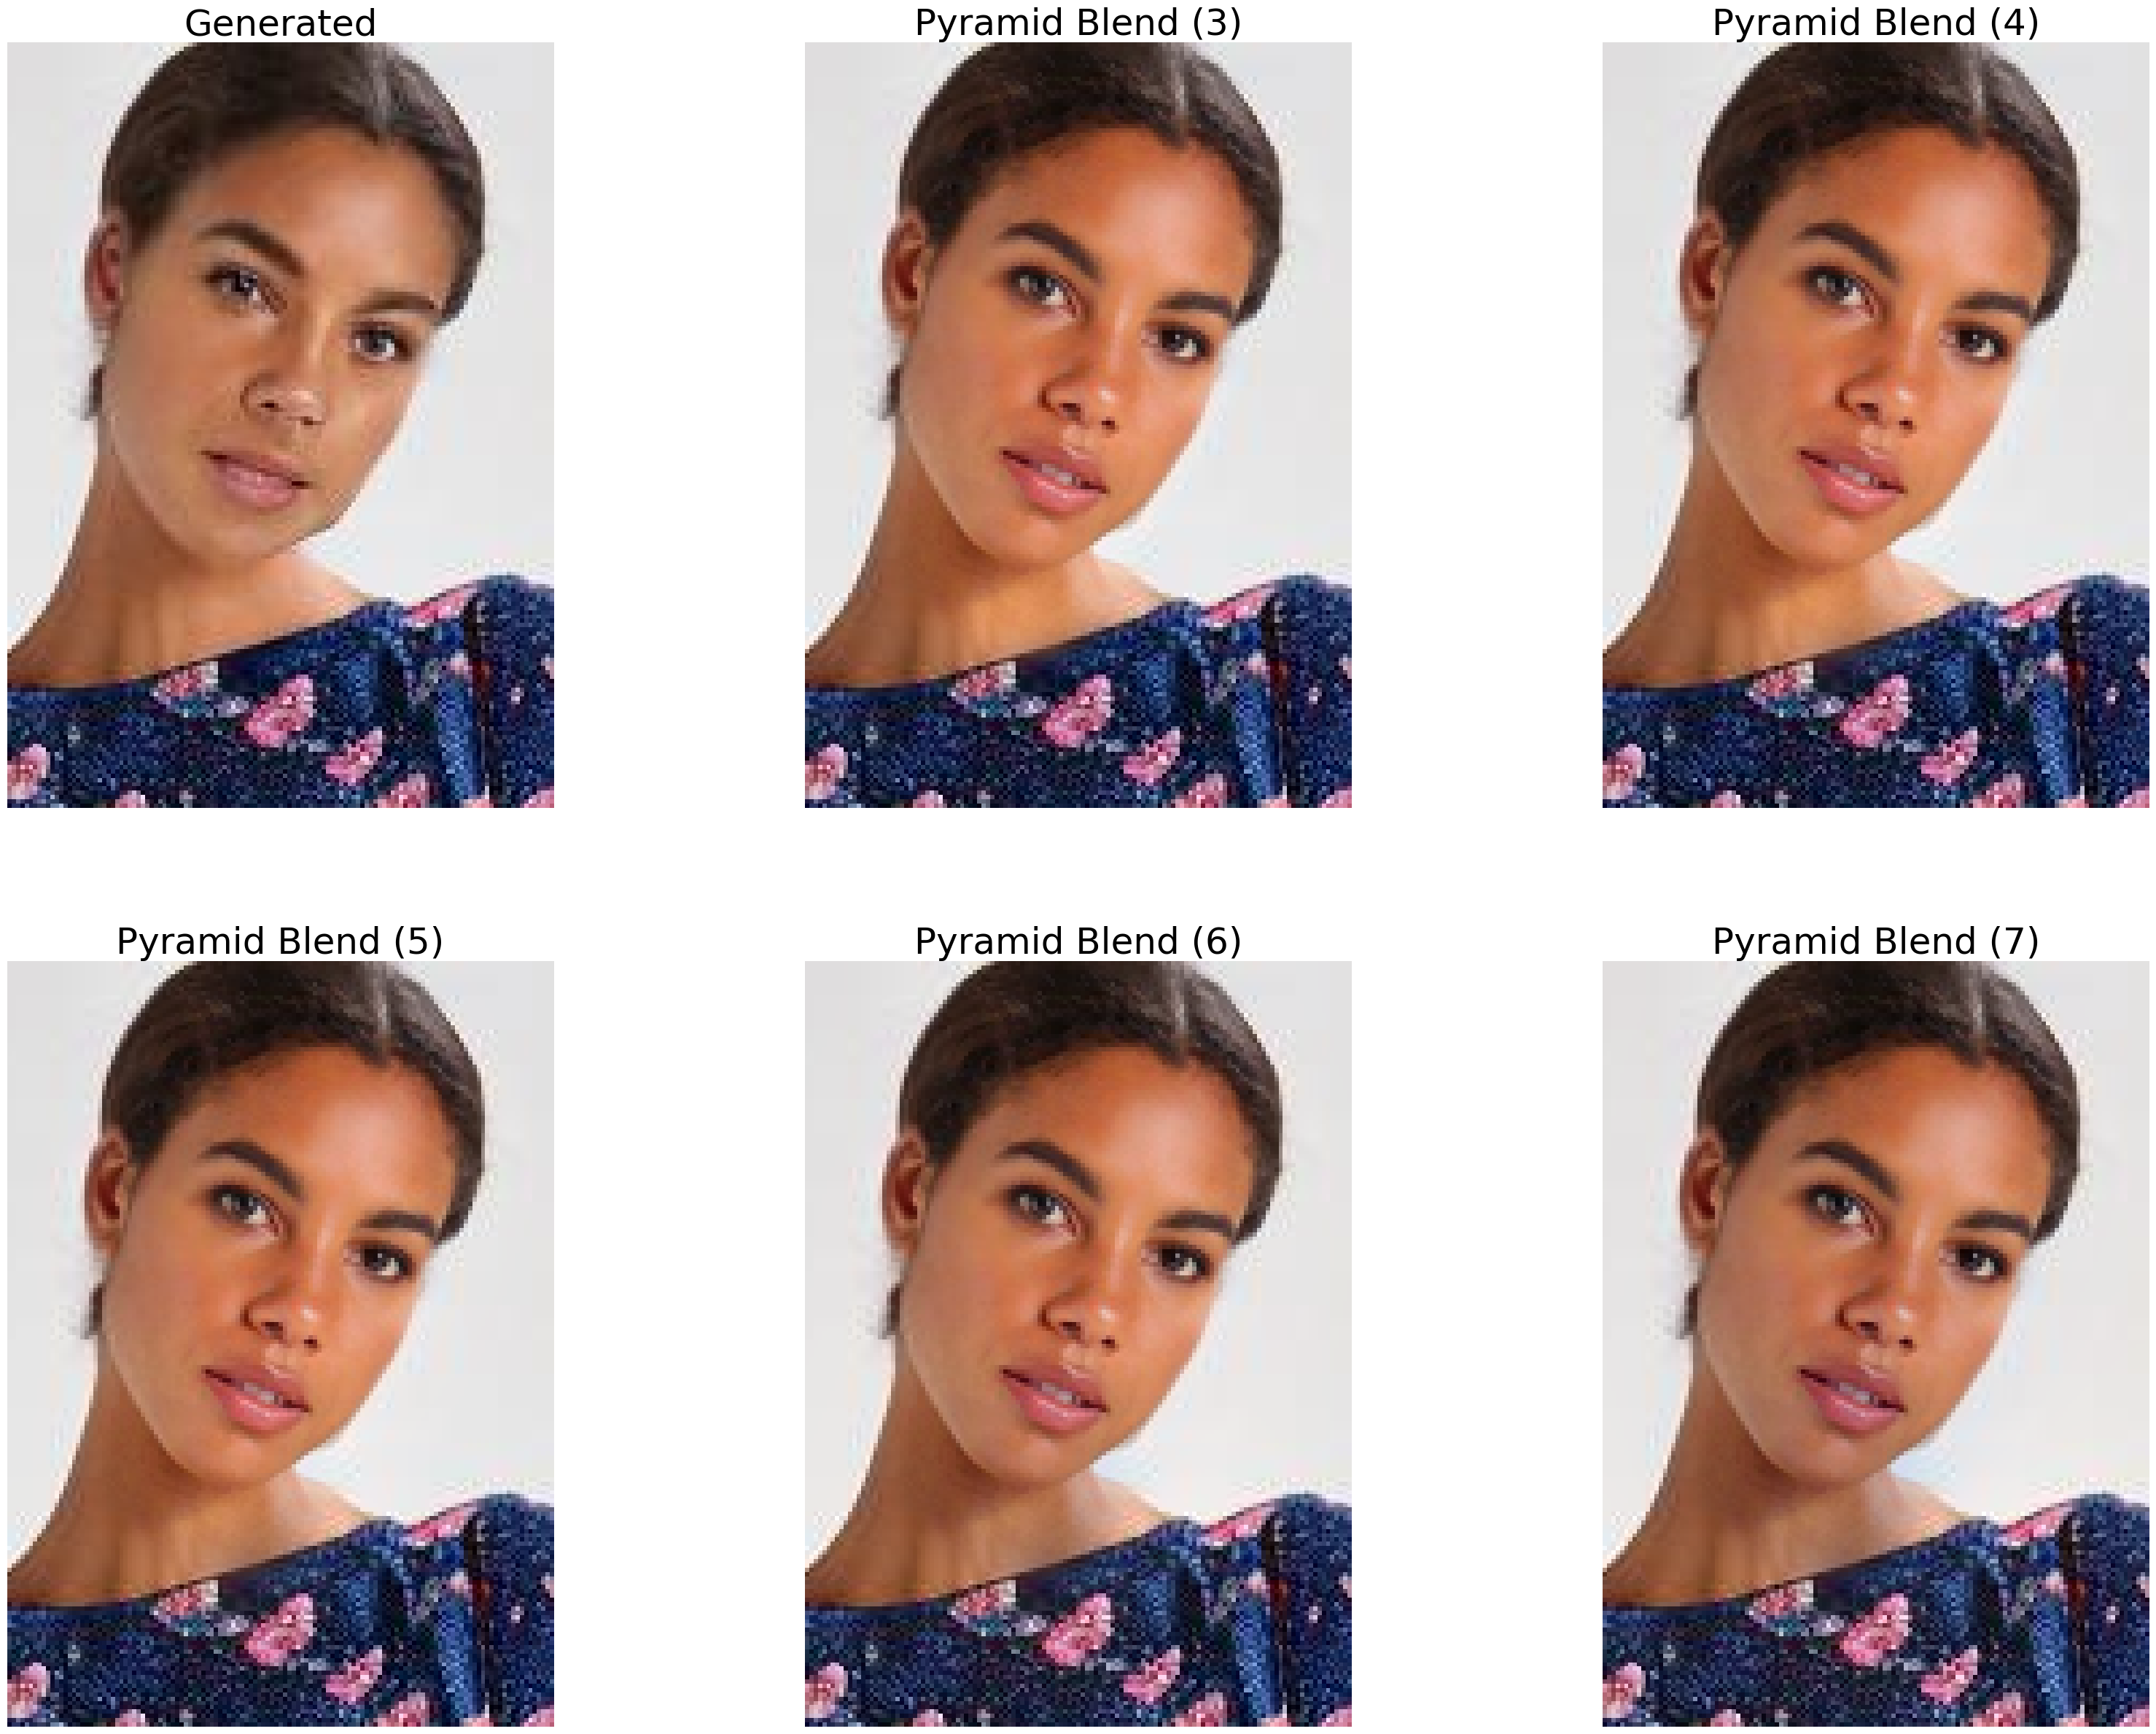

In [ ]:
def test_pyramid_level(img_orig, head_mask, image_id):
    os.makedirs("./output/pyramid", exist_ok=True)
    img_gen = Image.open(f"generated/{image_id}.jpg").convert("RGB")
    levels = [3,4,5,6,7]
    fig, axes = plt.subplots(2, 3, figsize=(40, 30))
    # Plot the generated image first
    ax = axes[0, 0]
    ax.imshow(img_gen.crop((x, y, x + w, y + h)))
    ax.set_title("Generated")
    ax.axis("off")
    
    for i, level in enumerate(levels):
        pyramid_blended = restore_head_pyramid_blend(img_orig.copy(), img_gen.copy(), head_mask, level)
        pyramid_blended = pyramid_blended.crop((x, y, x + w, y + h))
        pyramid_blended.save(os.path.join("./output/pyramid", f"{image_id}_pyramid_{level}.jpg"))
        ax = axes[(i + 1) // 3, (i + 1) % 3]
        ax.imshow(pyramid_blended)
        ax.set_title(f"Pyramid Blend ({level})")
        ax.axis("off")
    
    plt.savefig(f"./output/pyramid/{image_id}.png")
    plt.show()


image_ids = [f"img_{i}" for i in range(5)]  
for img_id in image_ids:
    print(f"Processing {img_id}...")
    test_pyramid_level(img_orig, head_mask, img_id)

### Izbira parametra level za Pyramid Blending
Na podlagi zgornjih slik, ki so bile narejene za različne vrednosti parametra level, 3-7, in se zdi, da je najboljša vrednost parametra level 4.


## Testiranje različnih metod zlivanja z izbranimi parametri


Processing 00002_00...


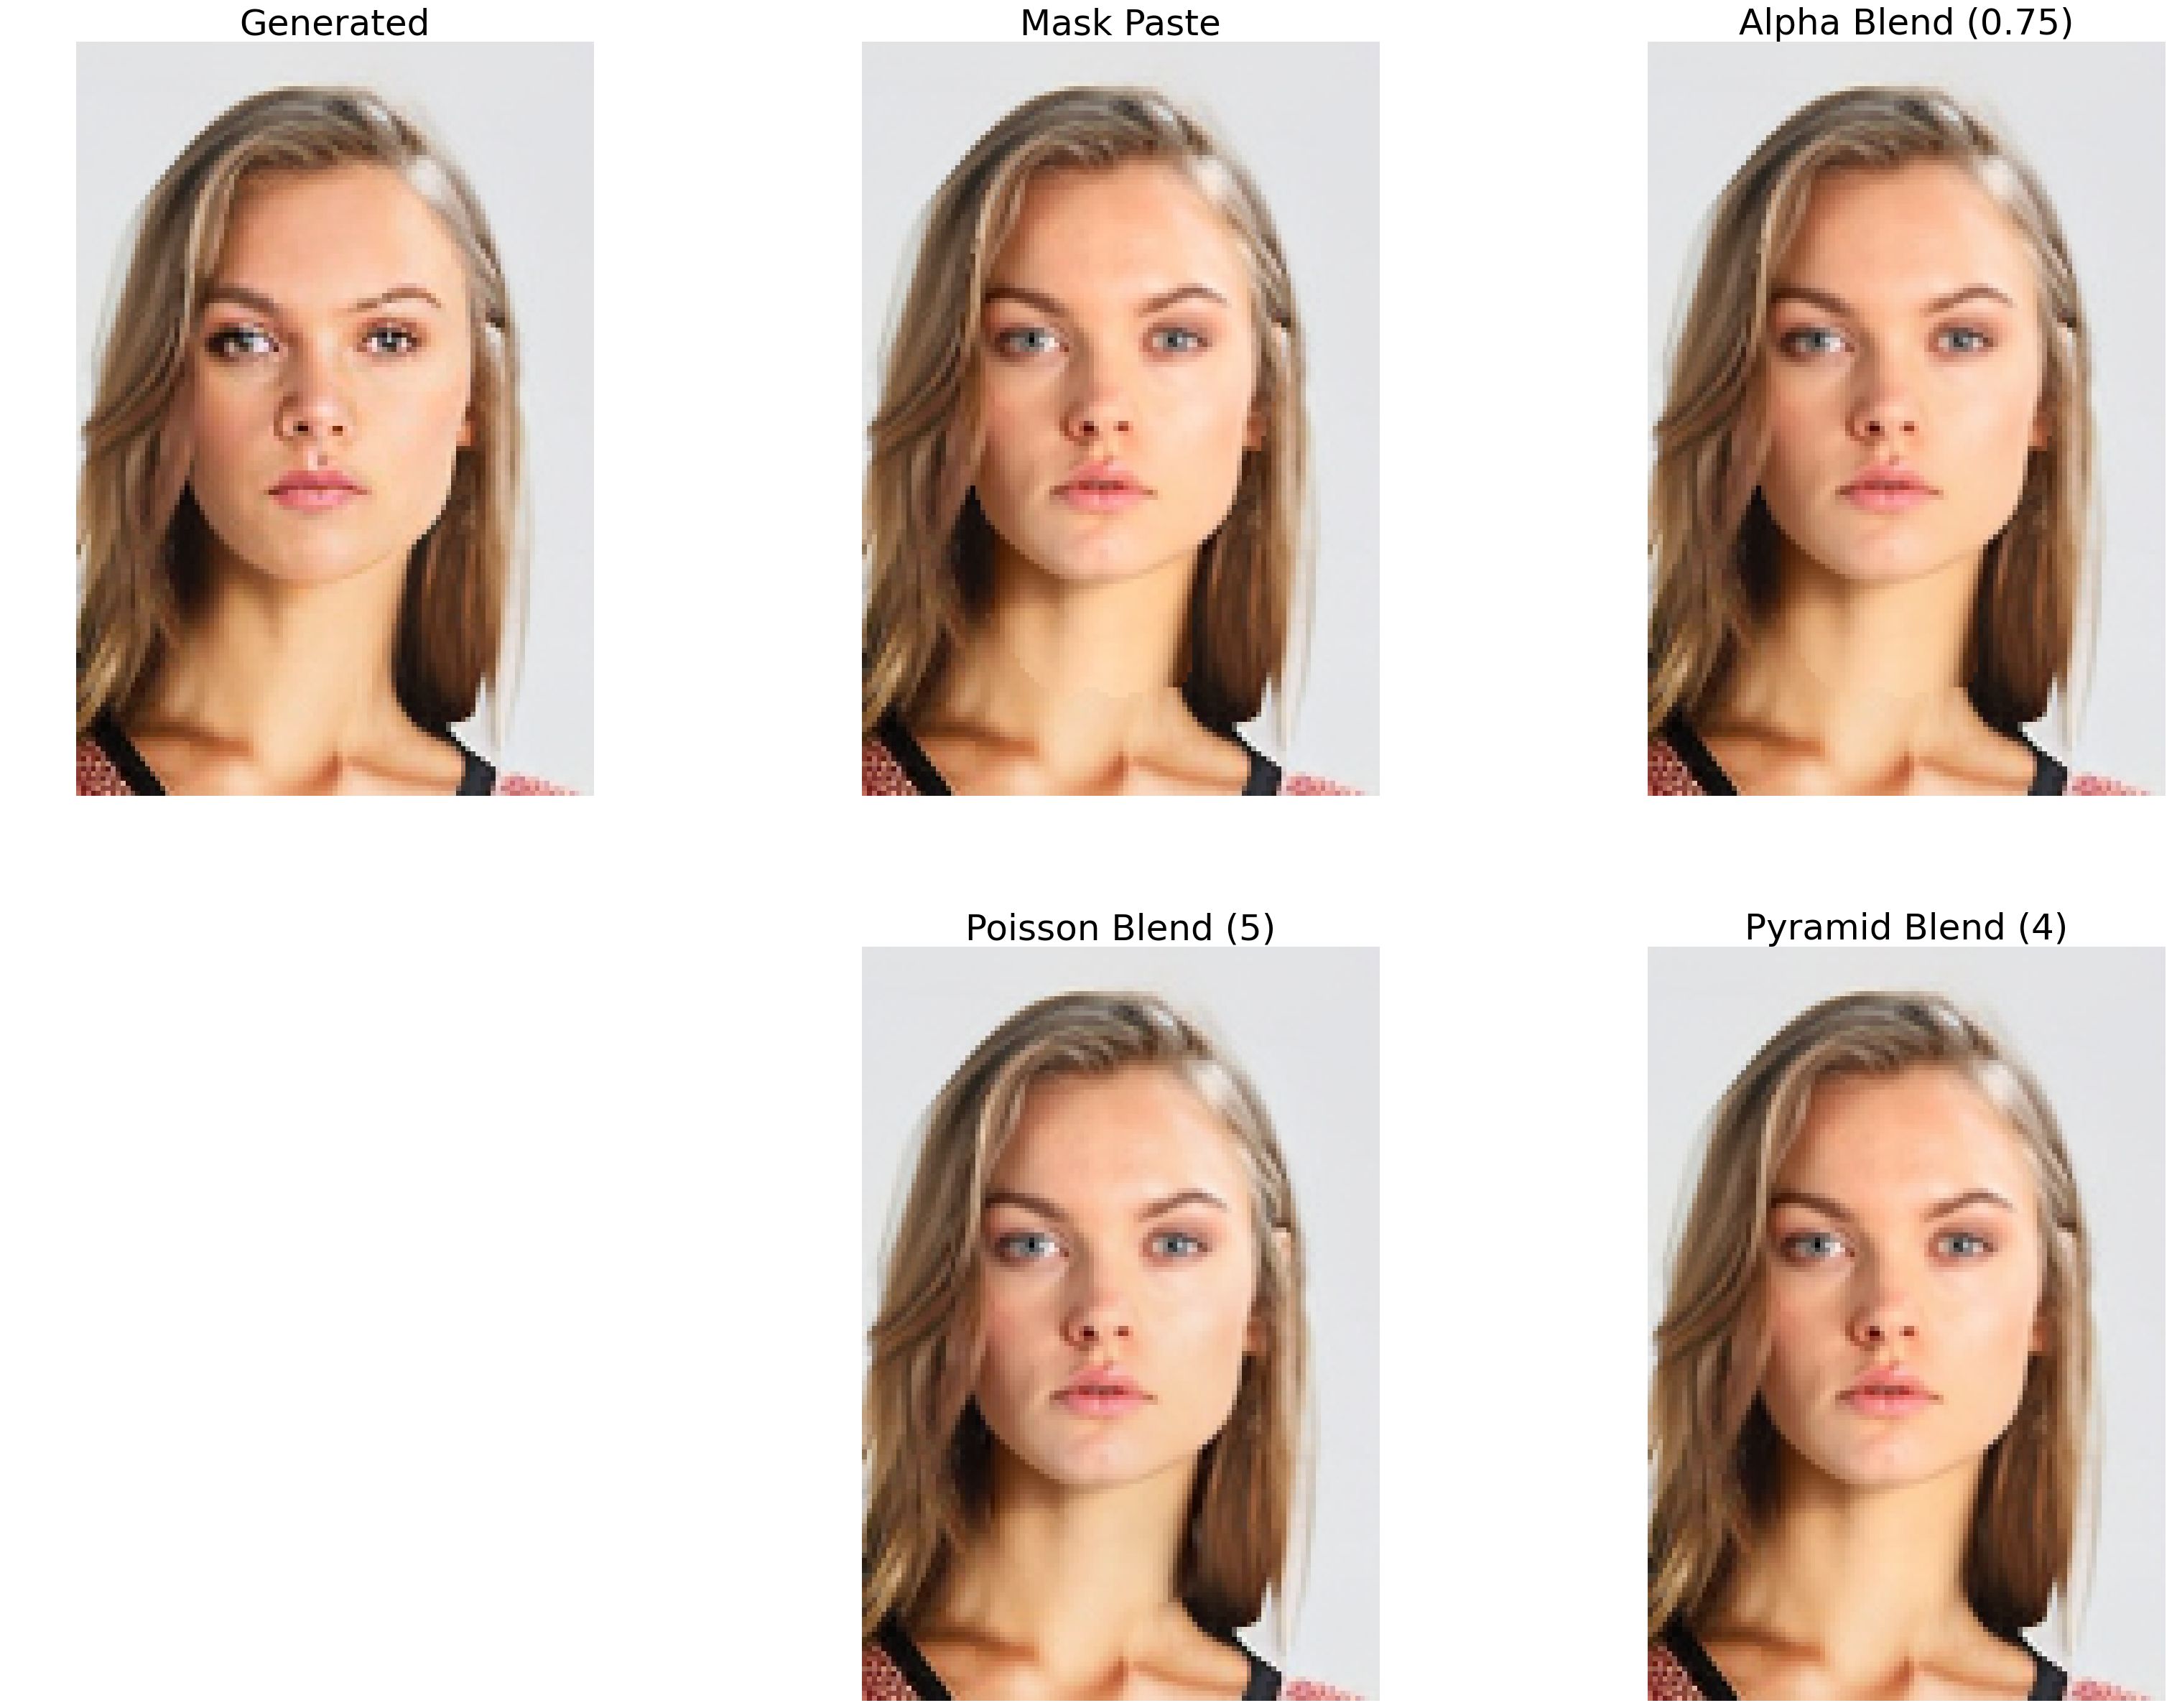

Processing 000038_0...


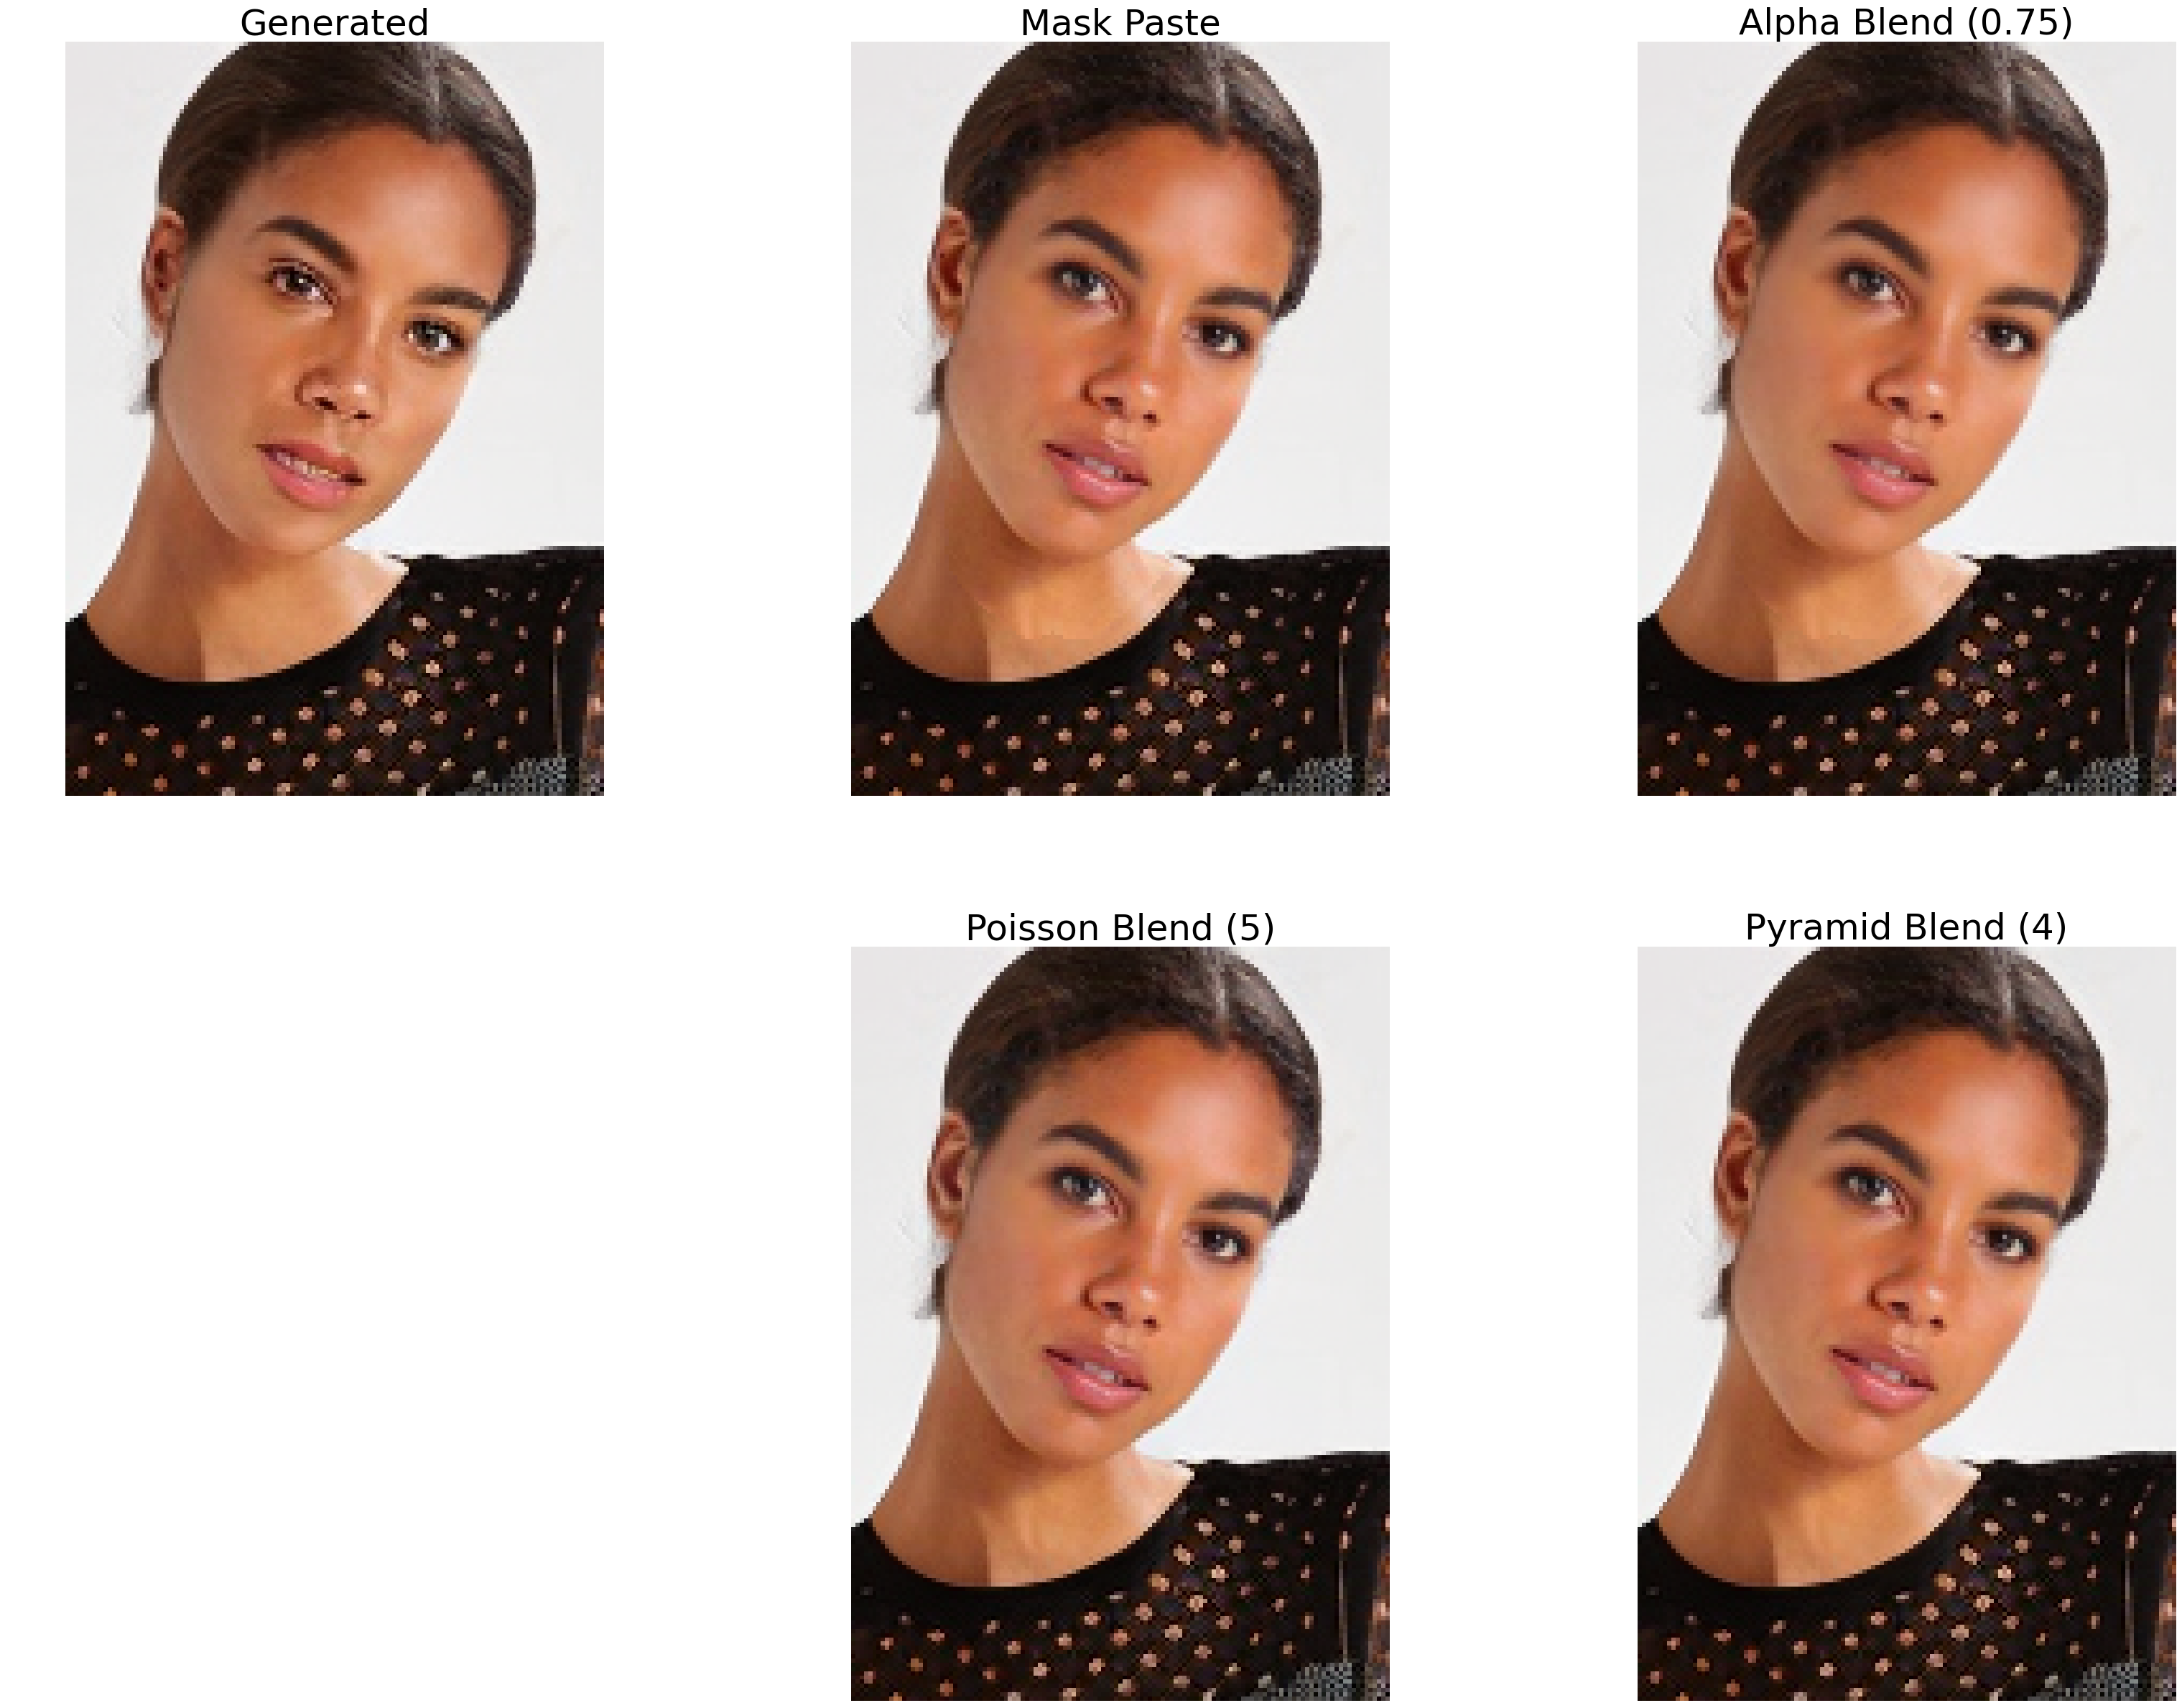

Processing 00006_00...


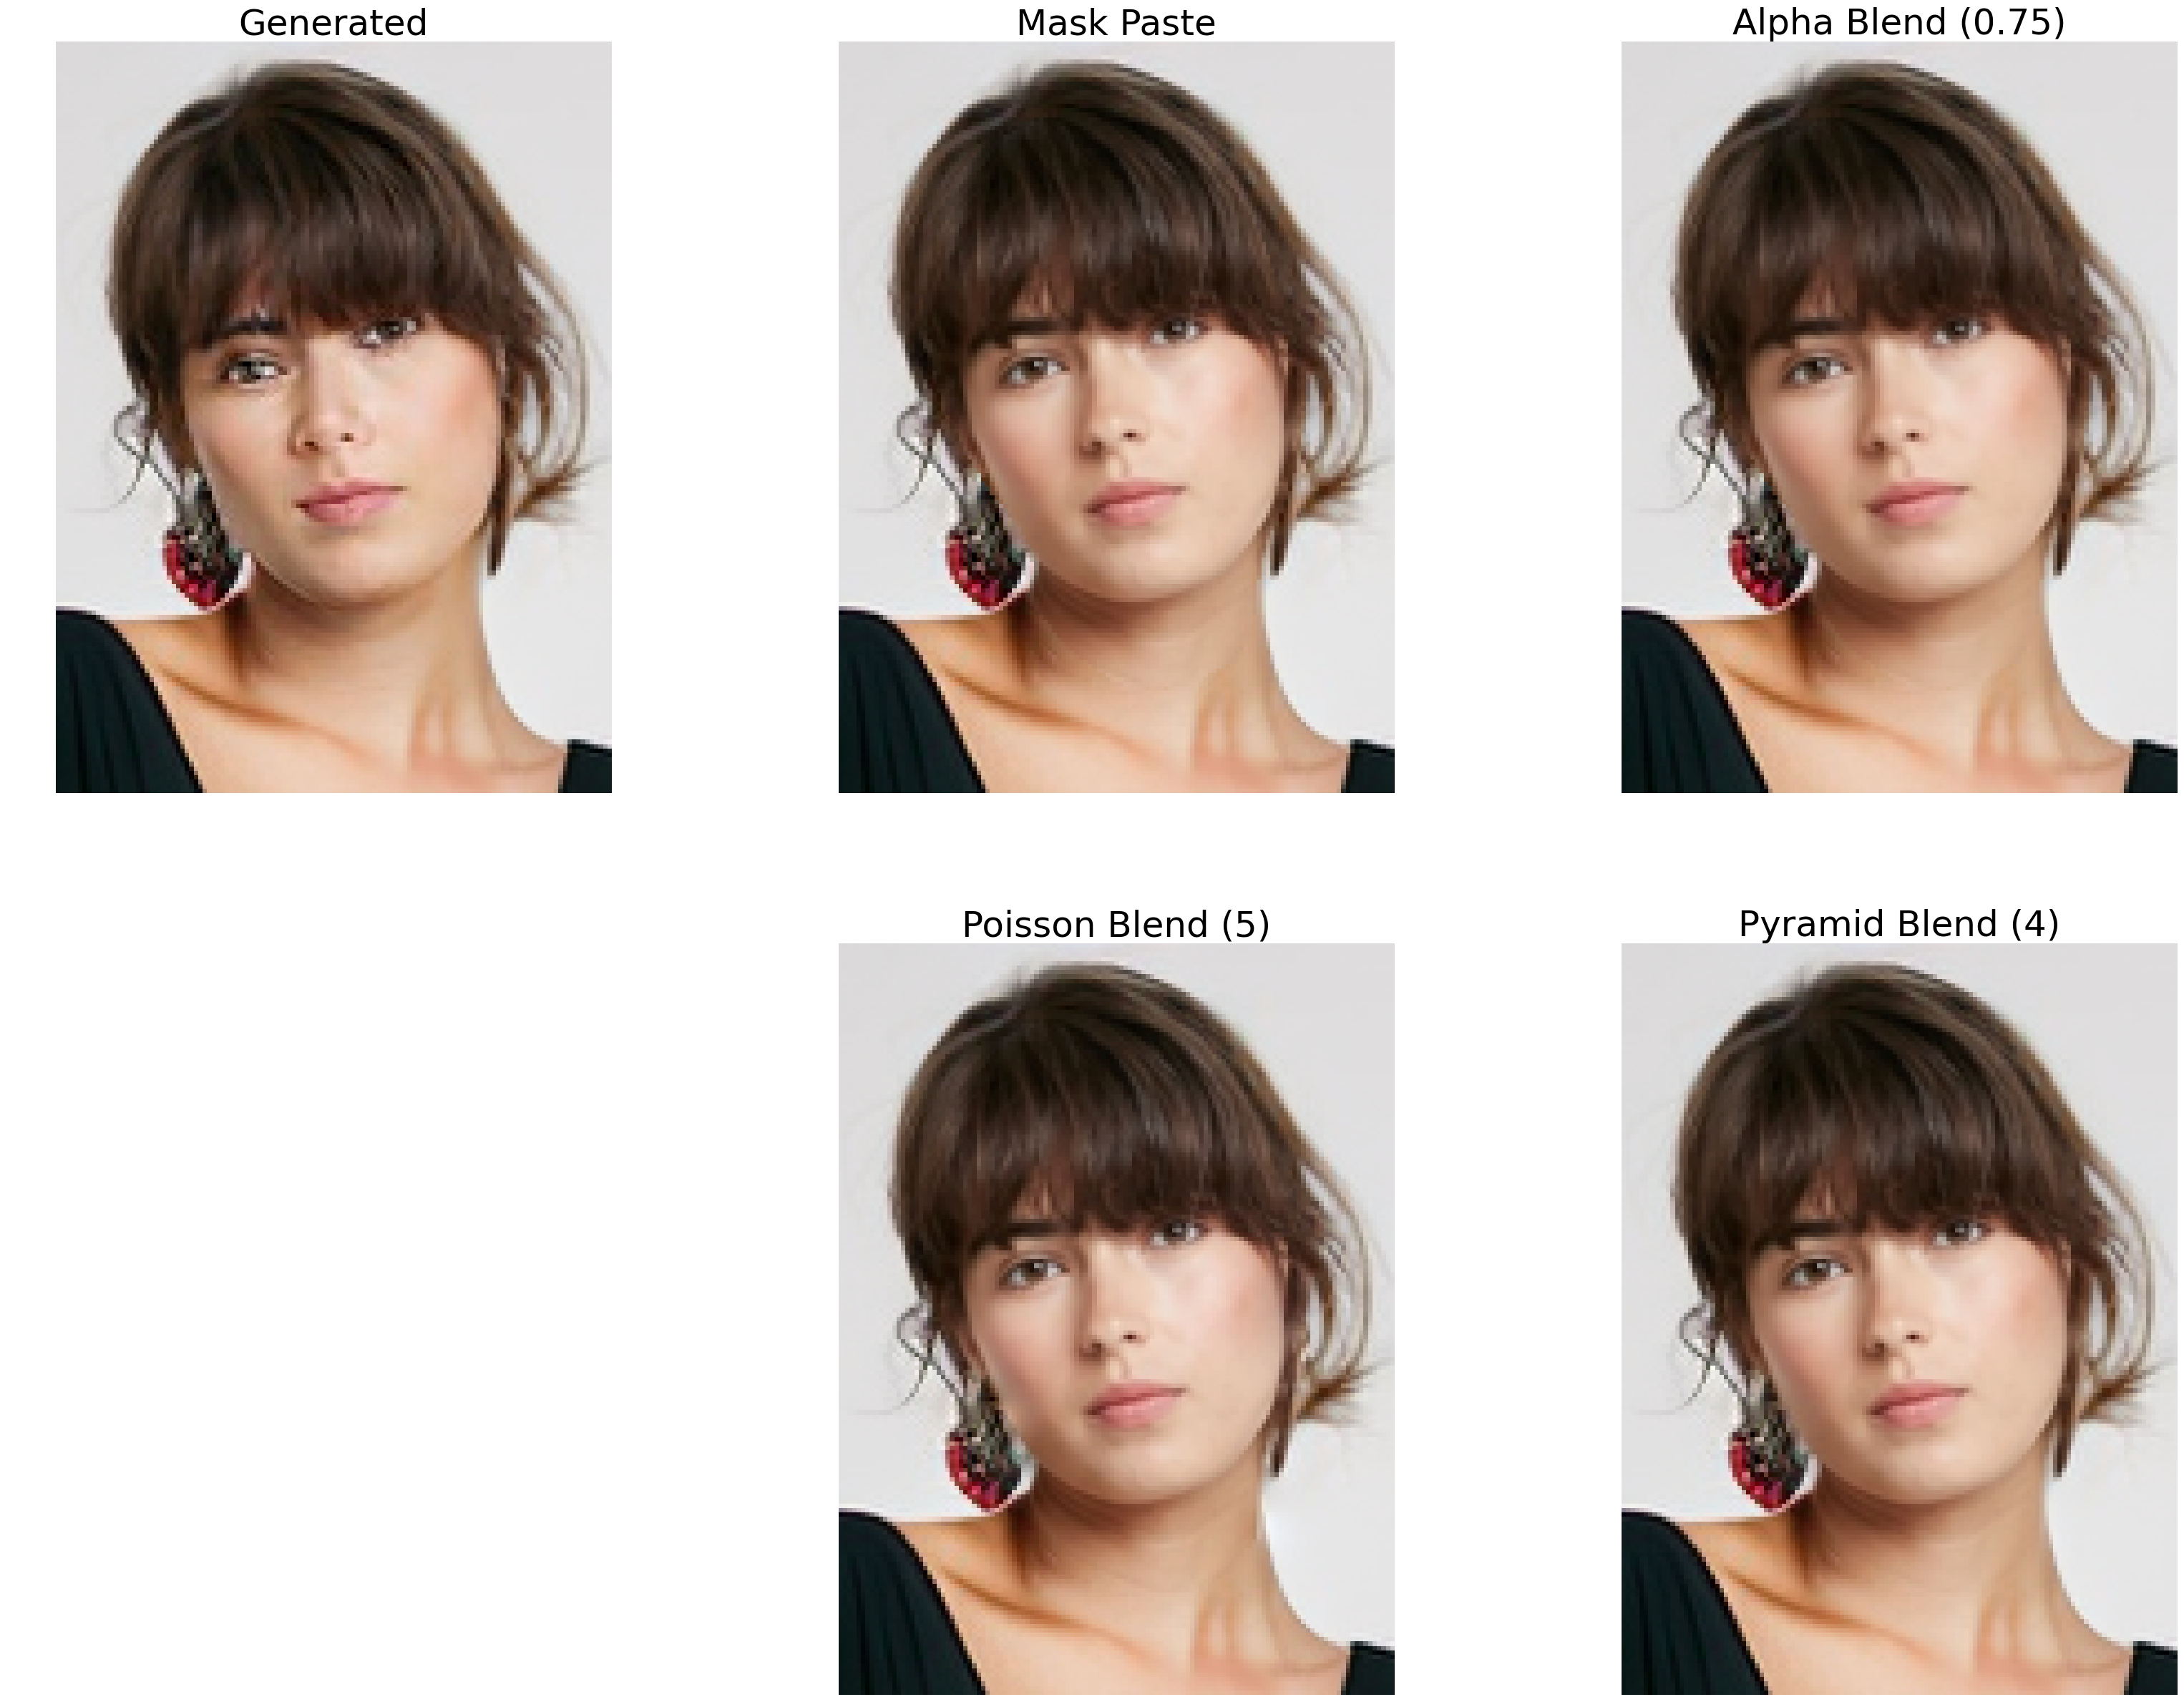

Processing 00011_00...


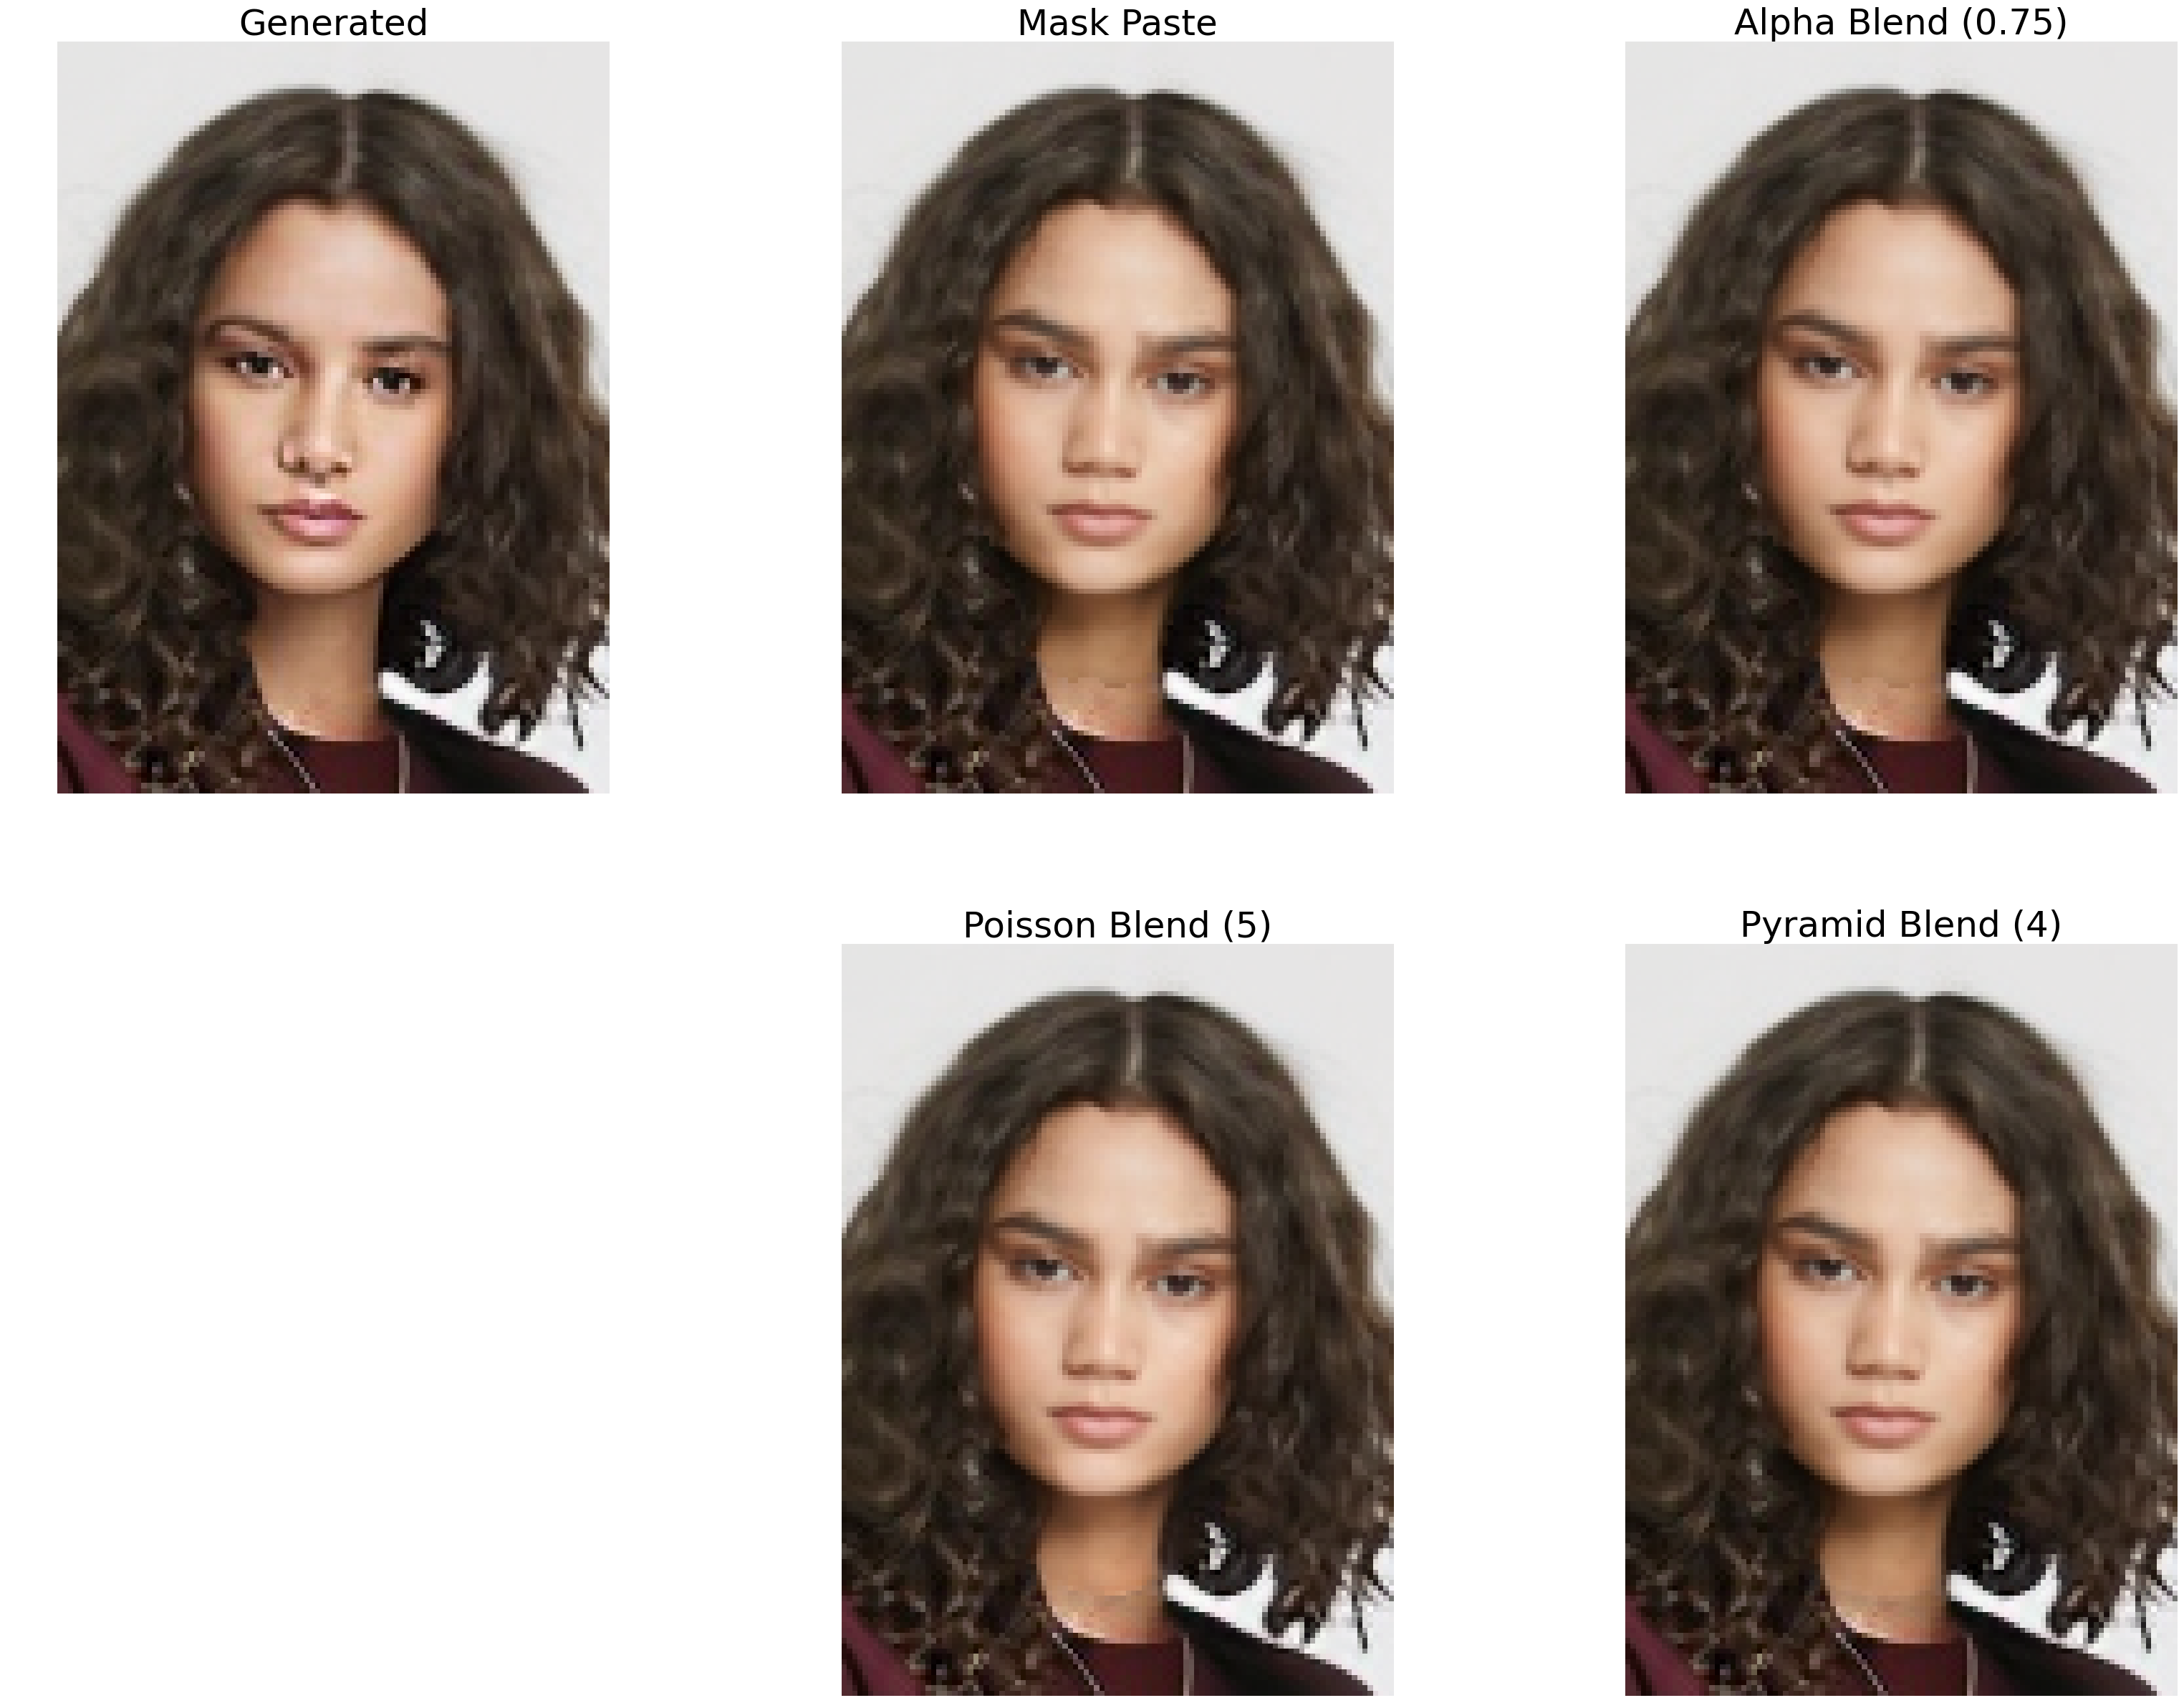

Processing 00018_00...


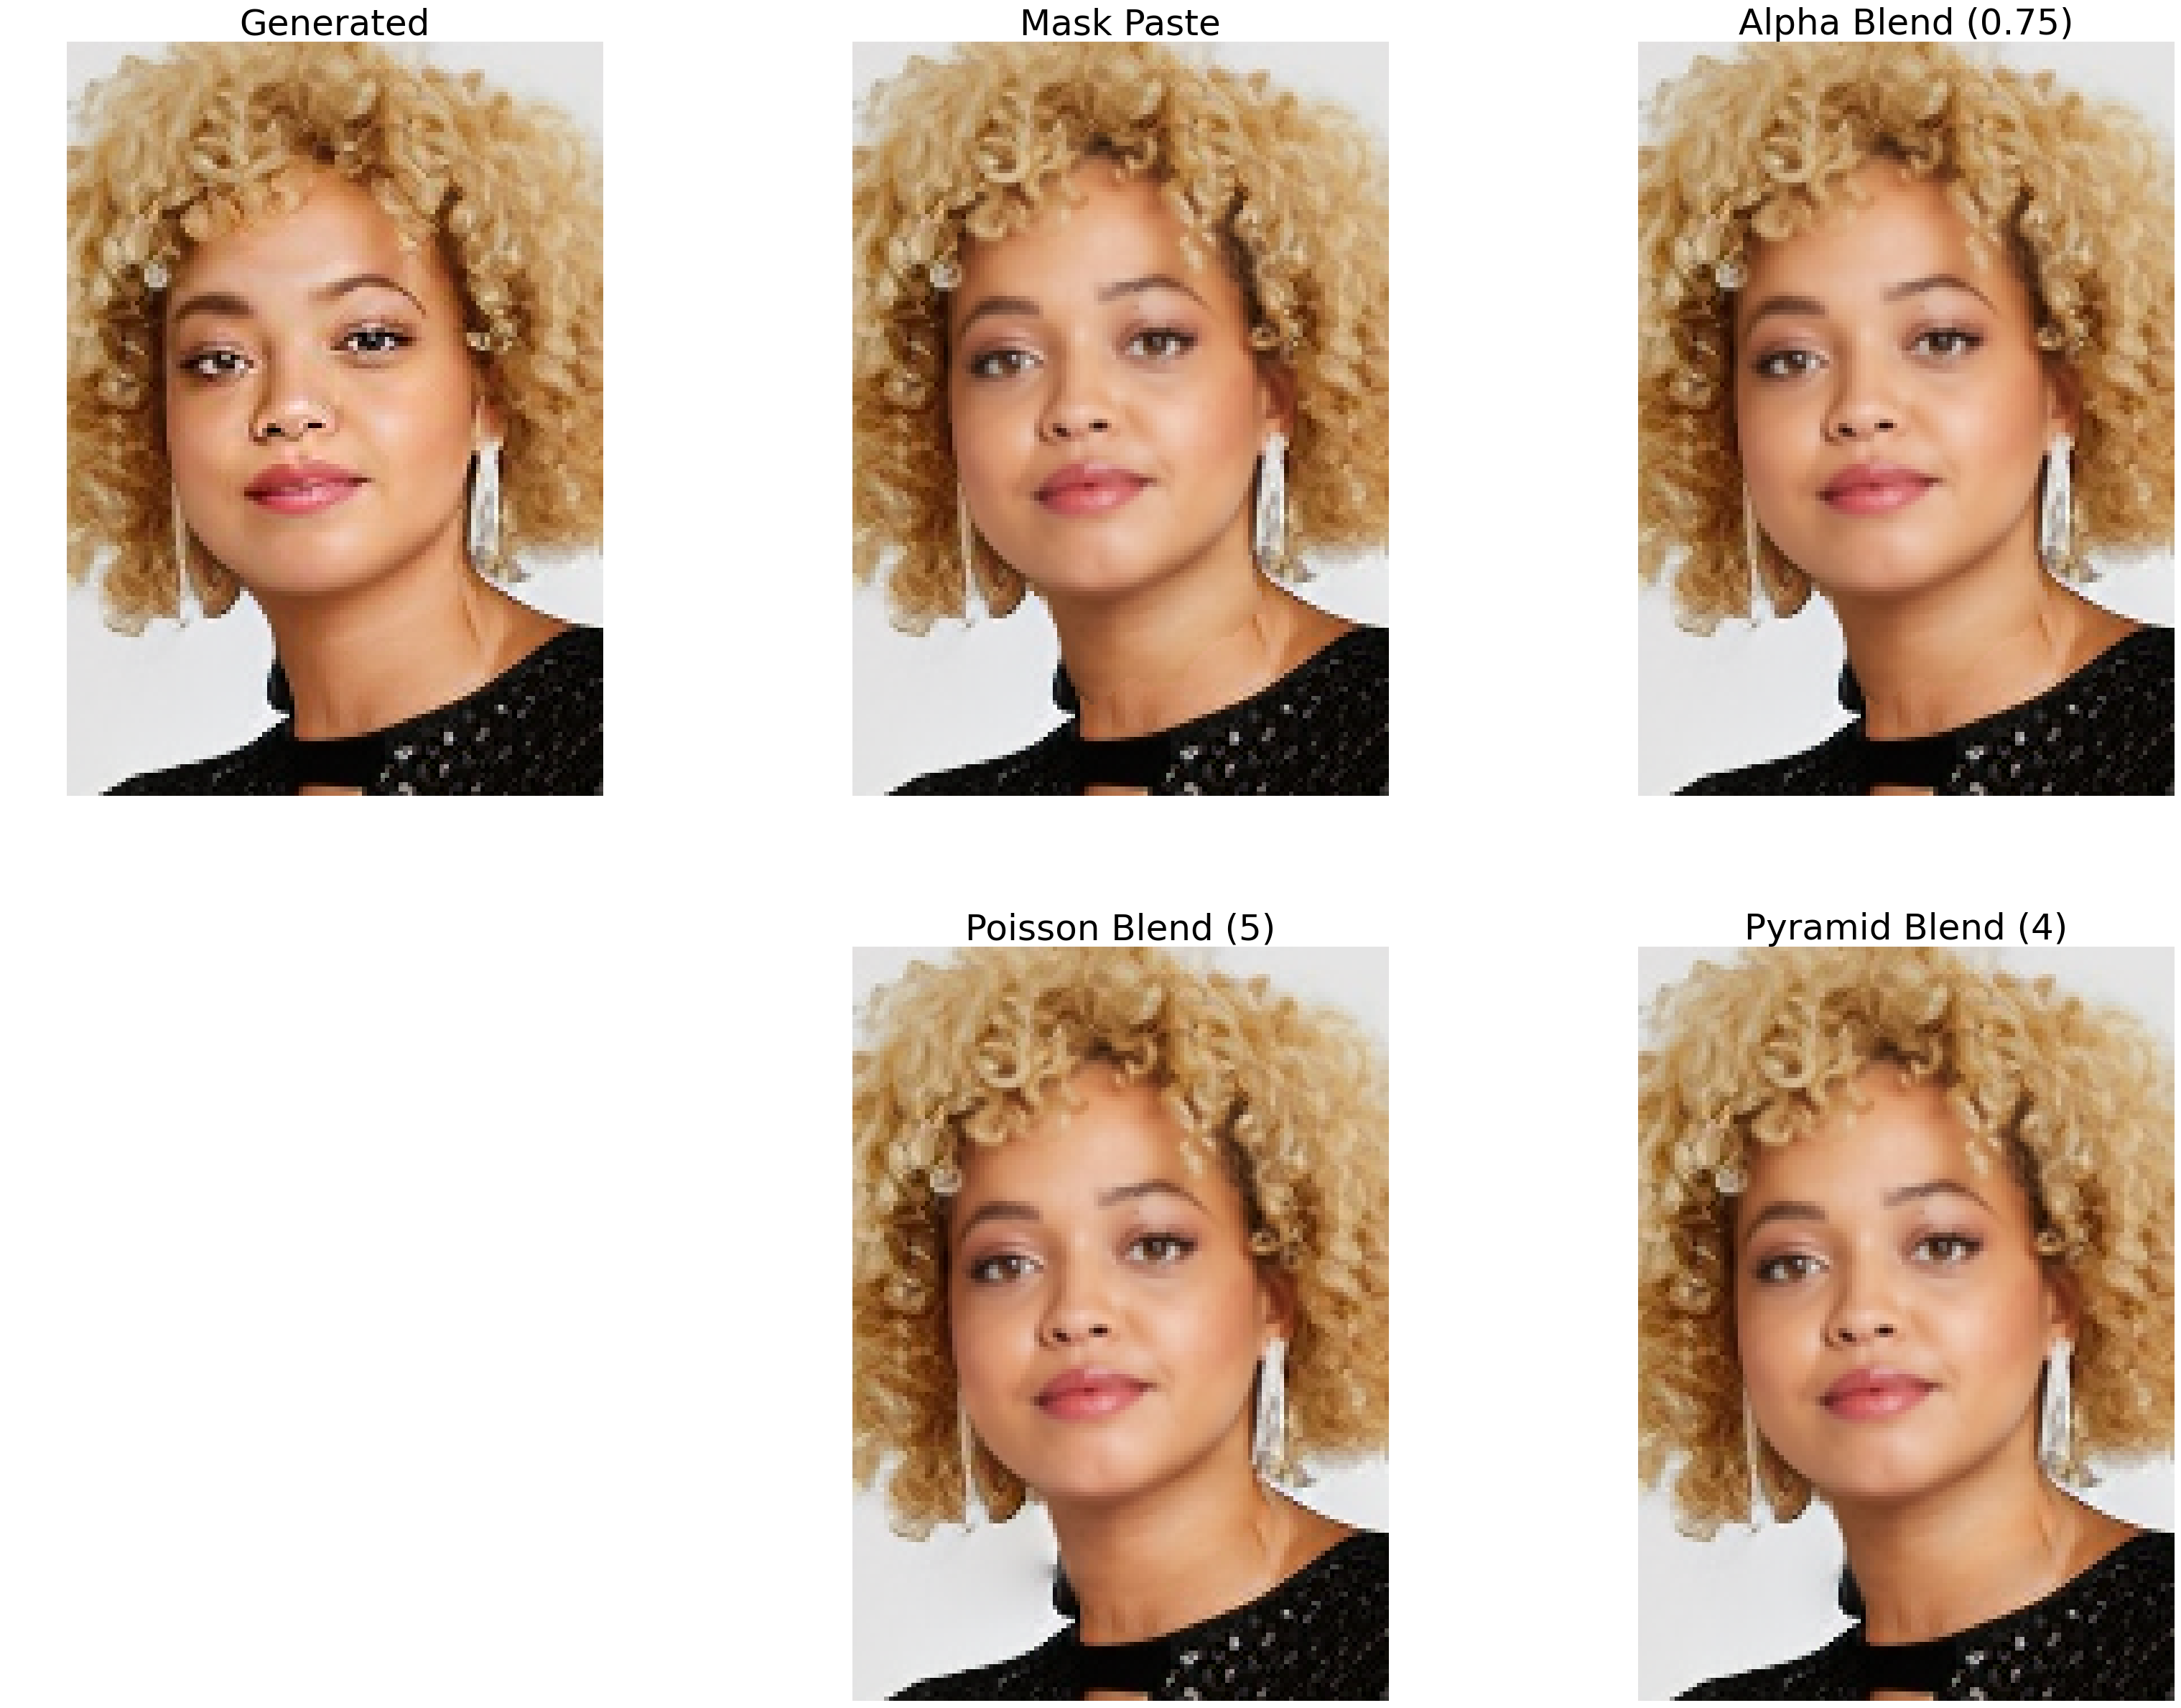

Processing 00022_00...


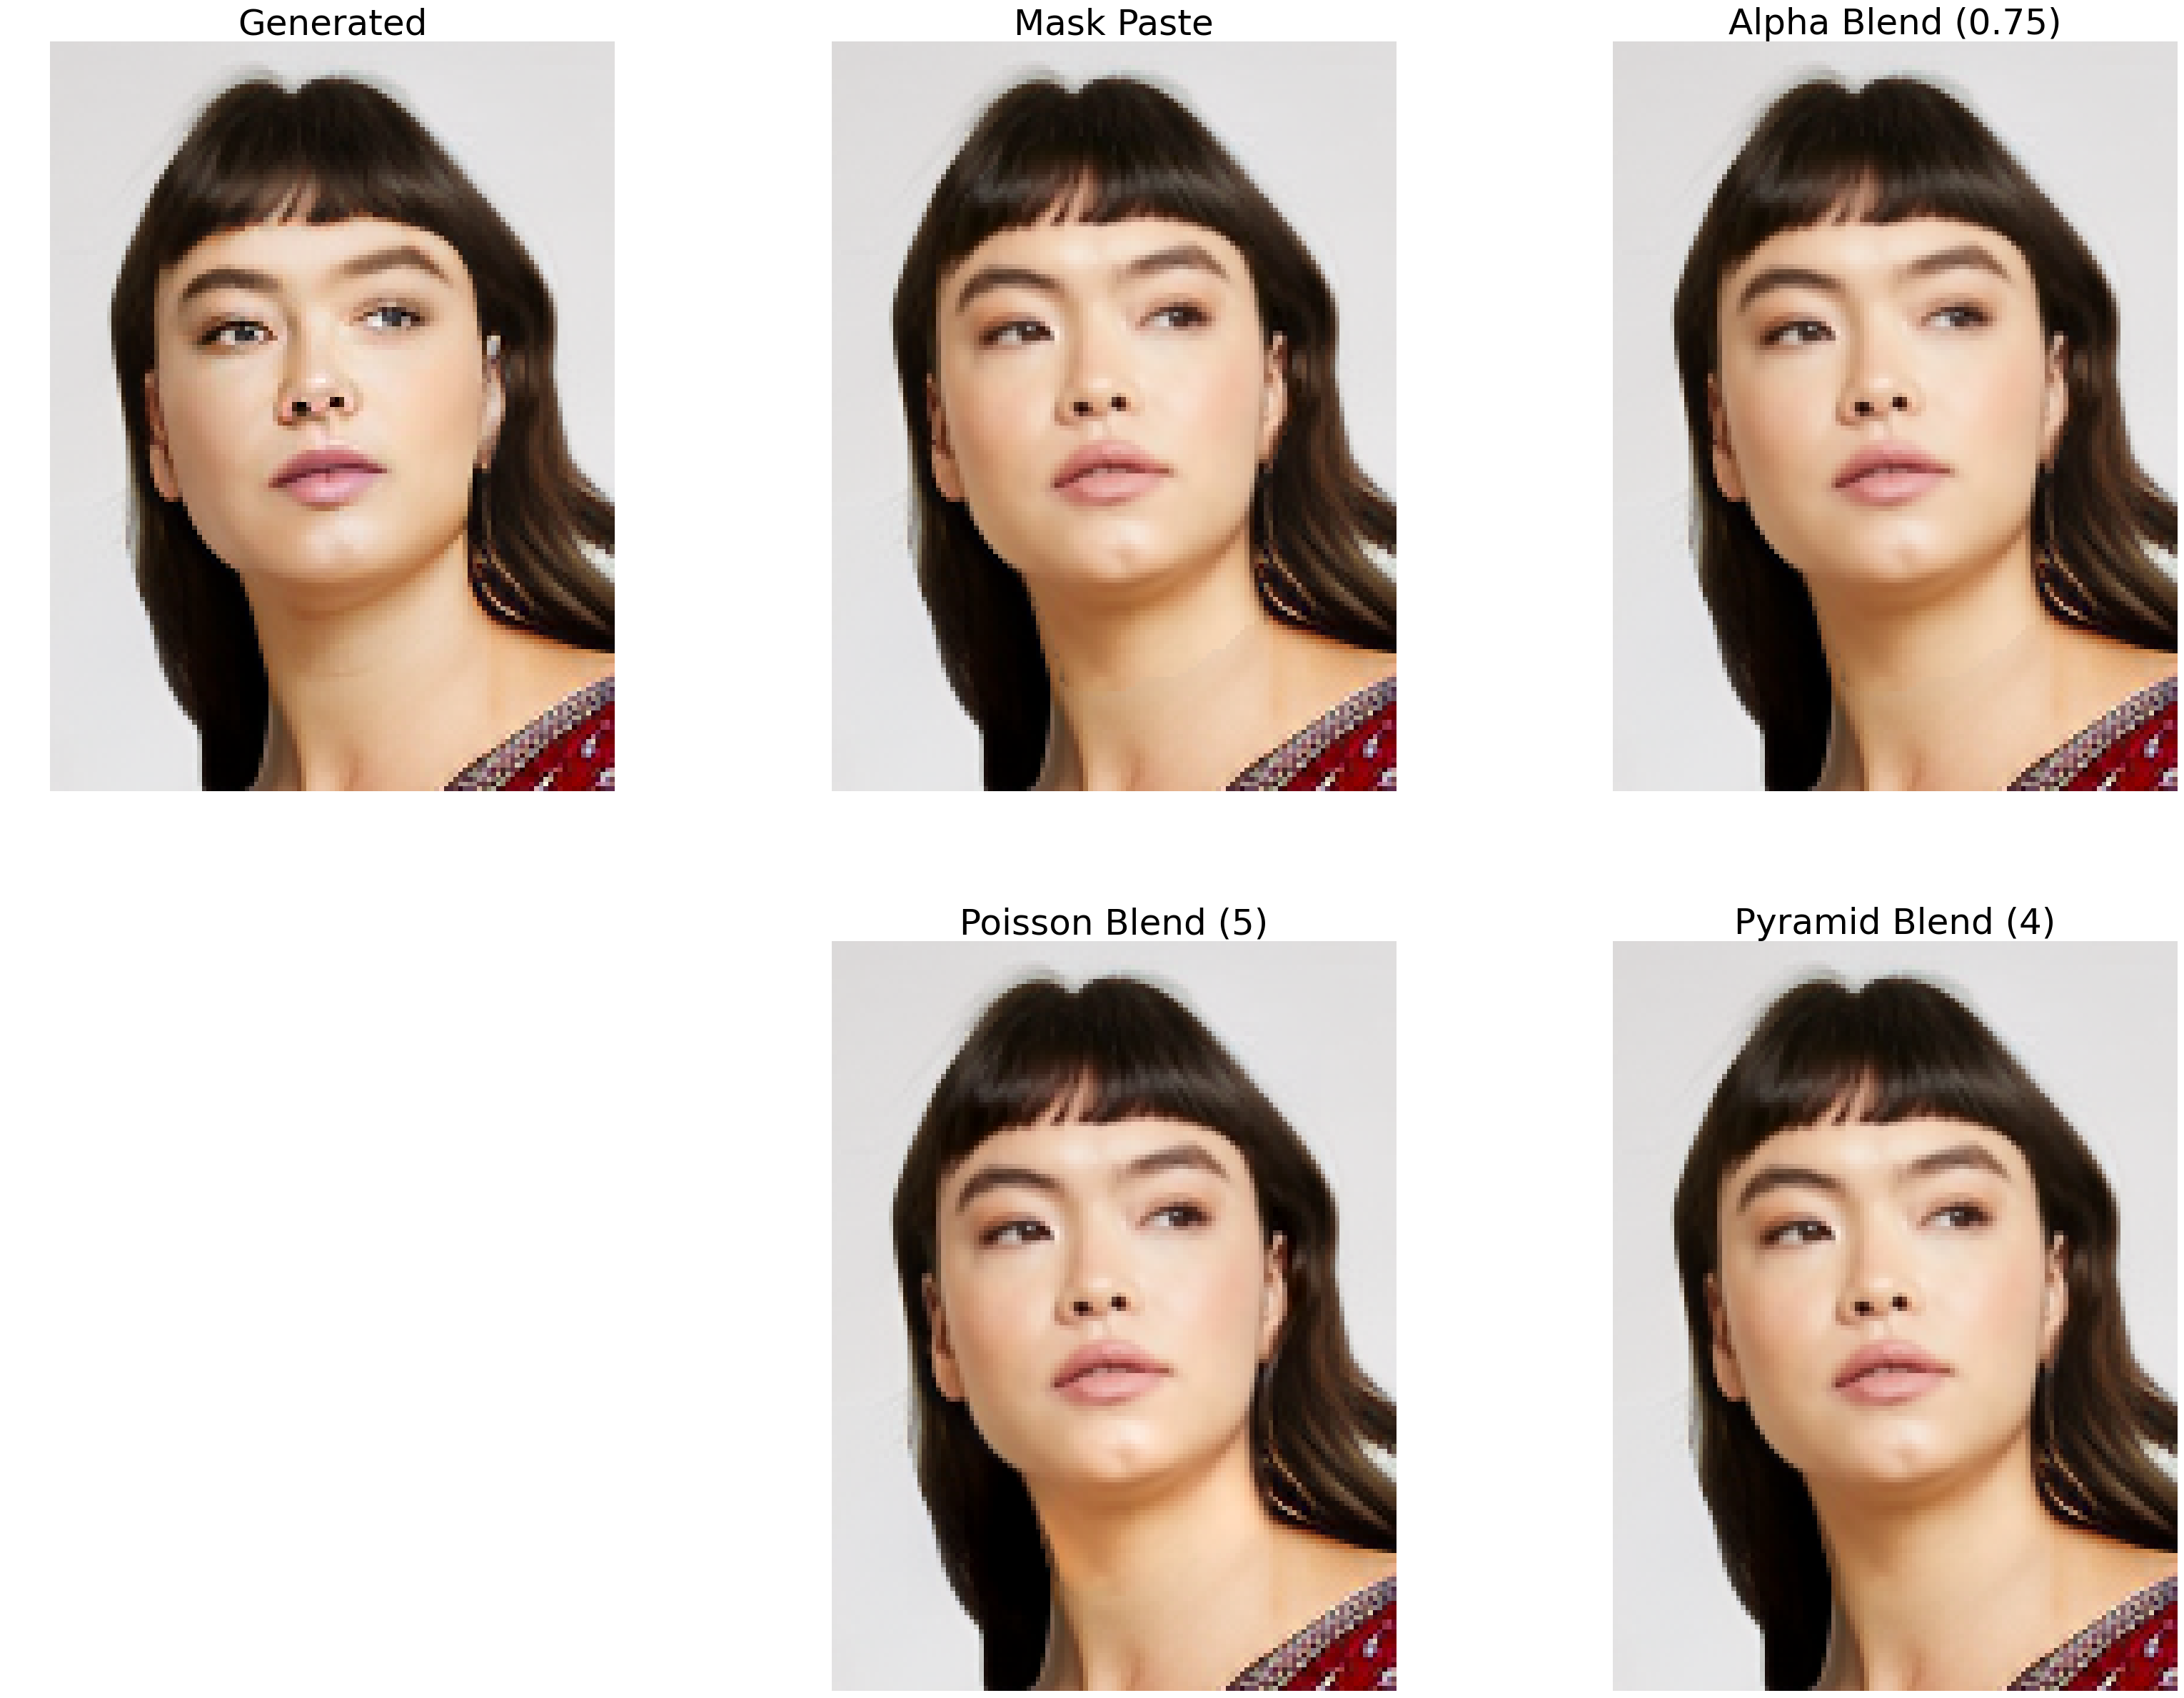

Processing 00033_00...


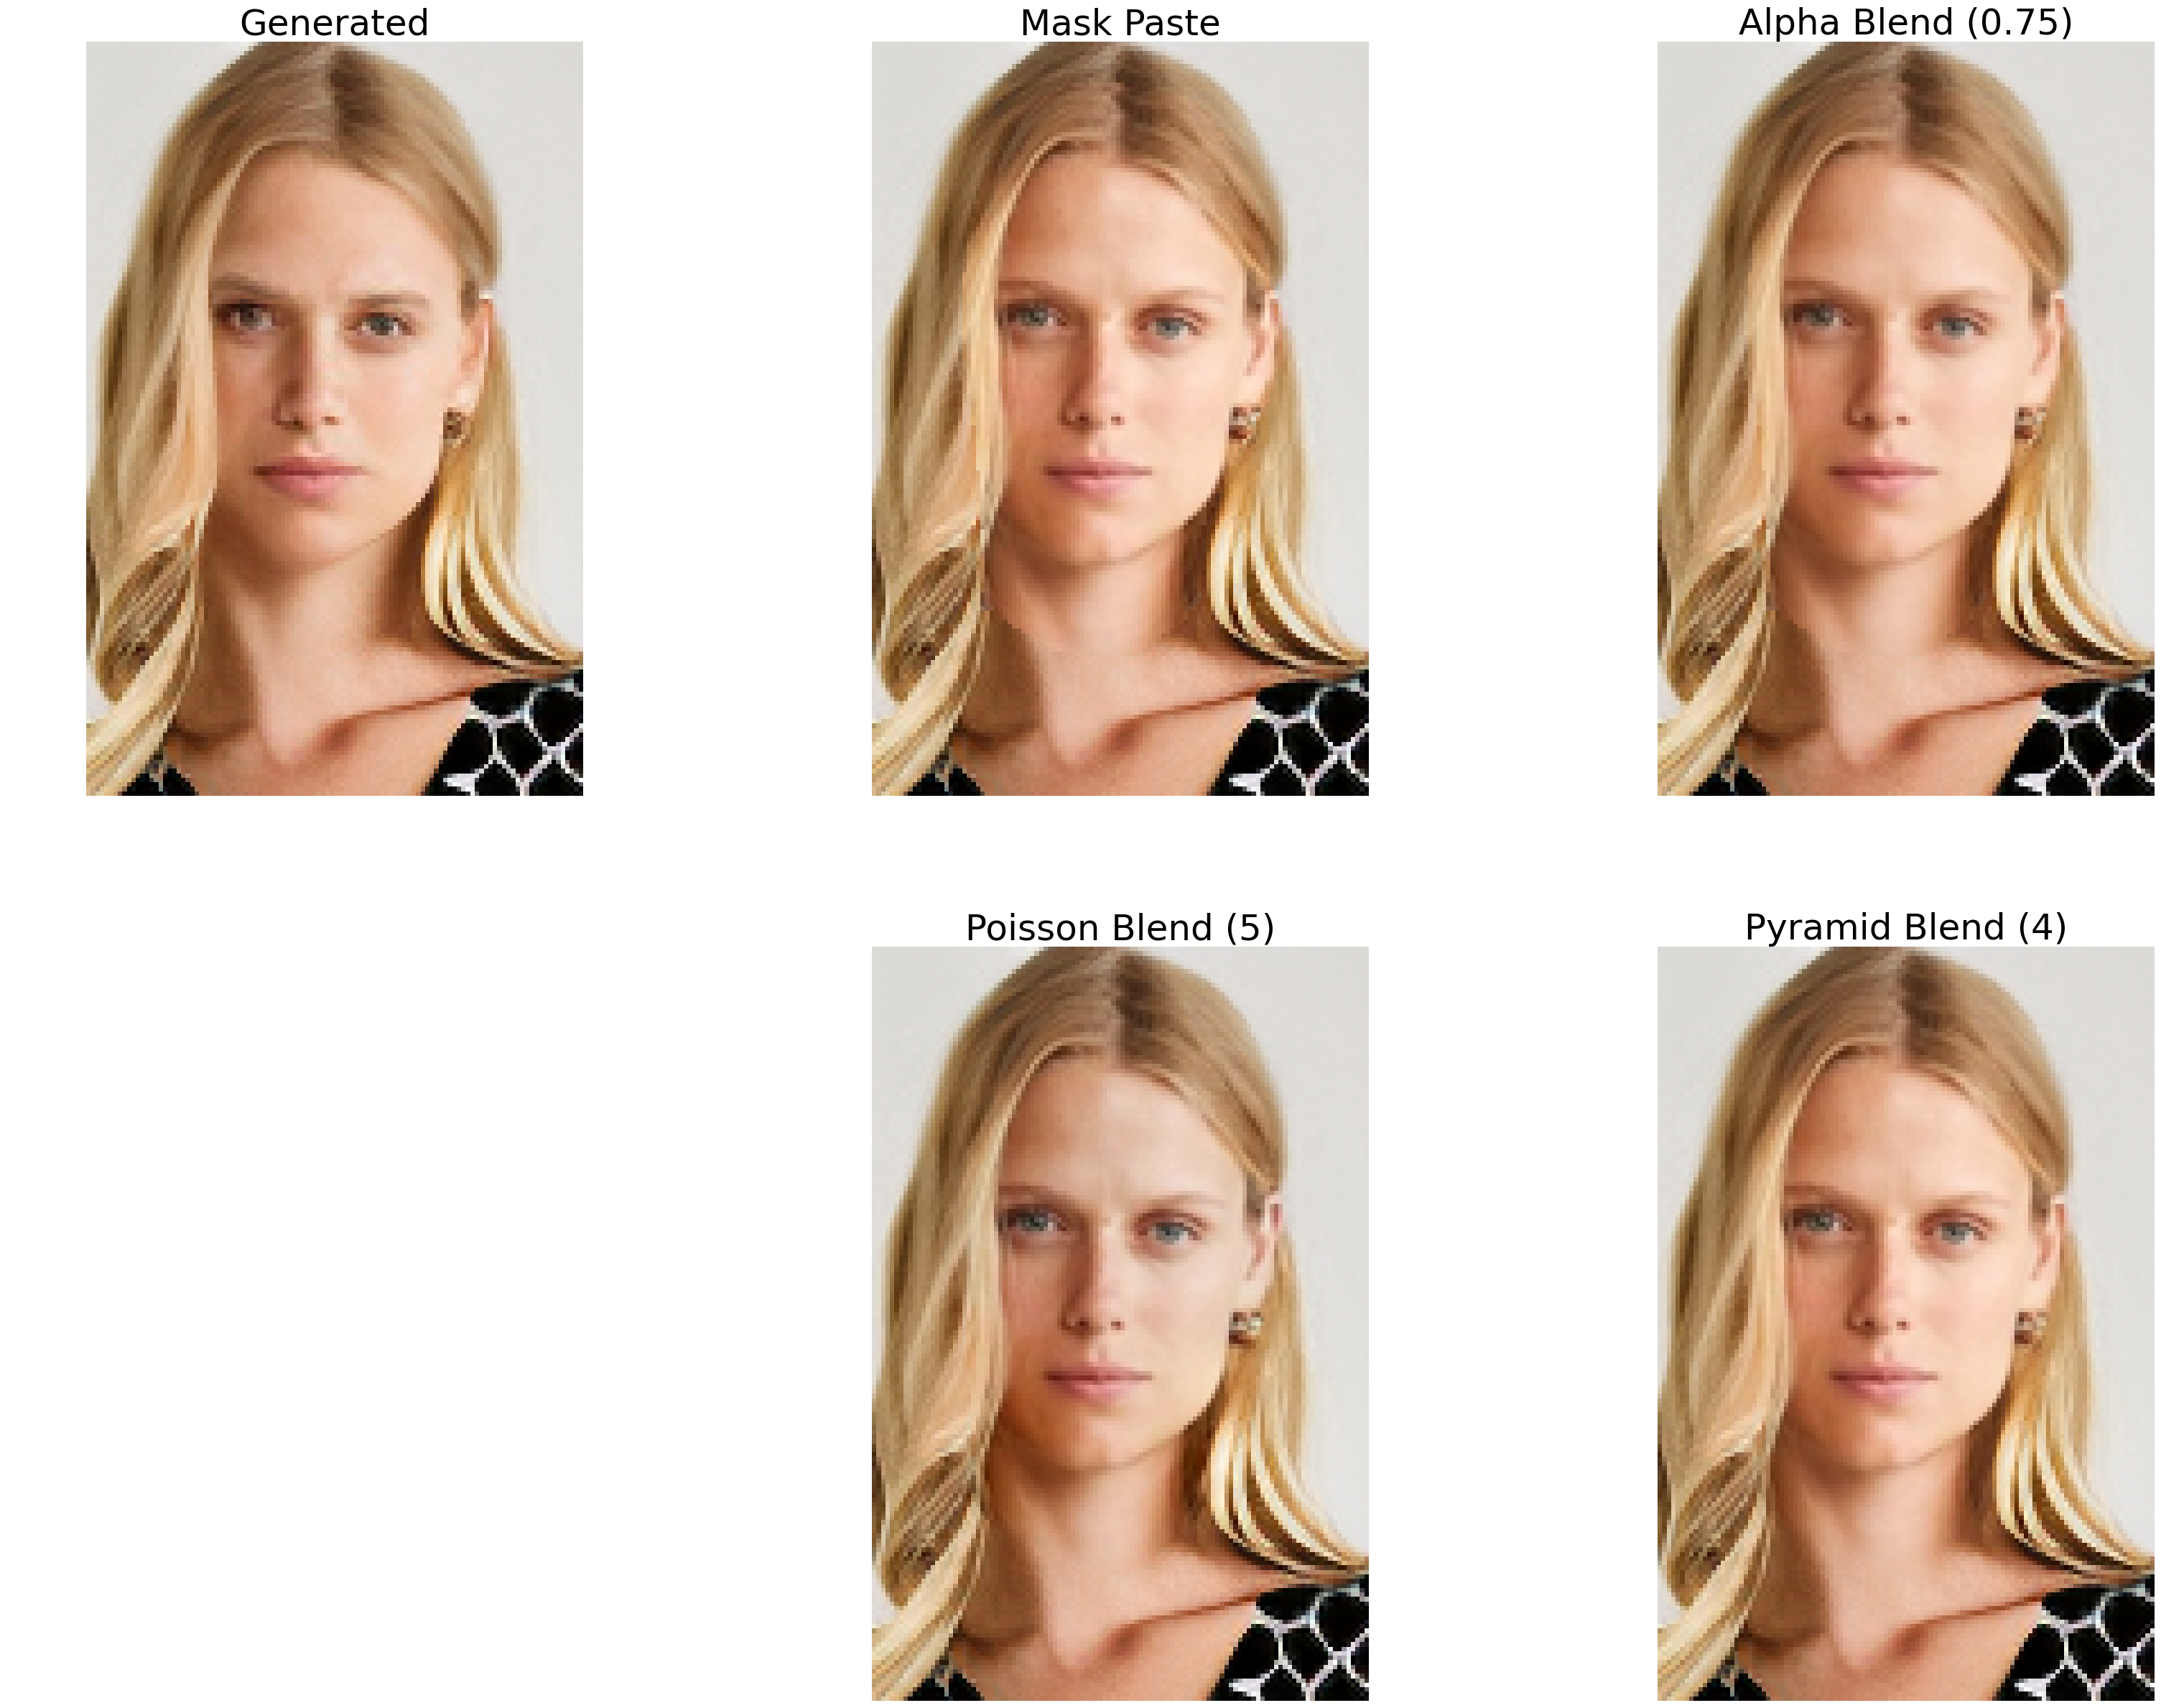

Processing 00090_00...


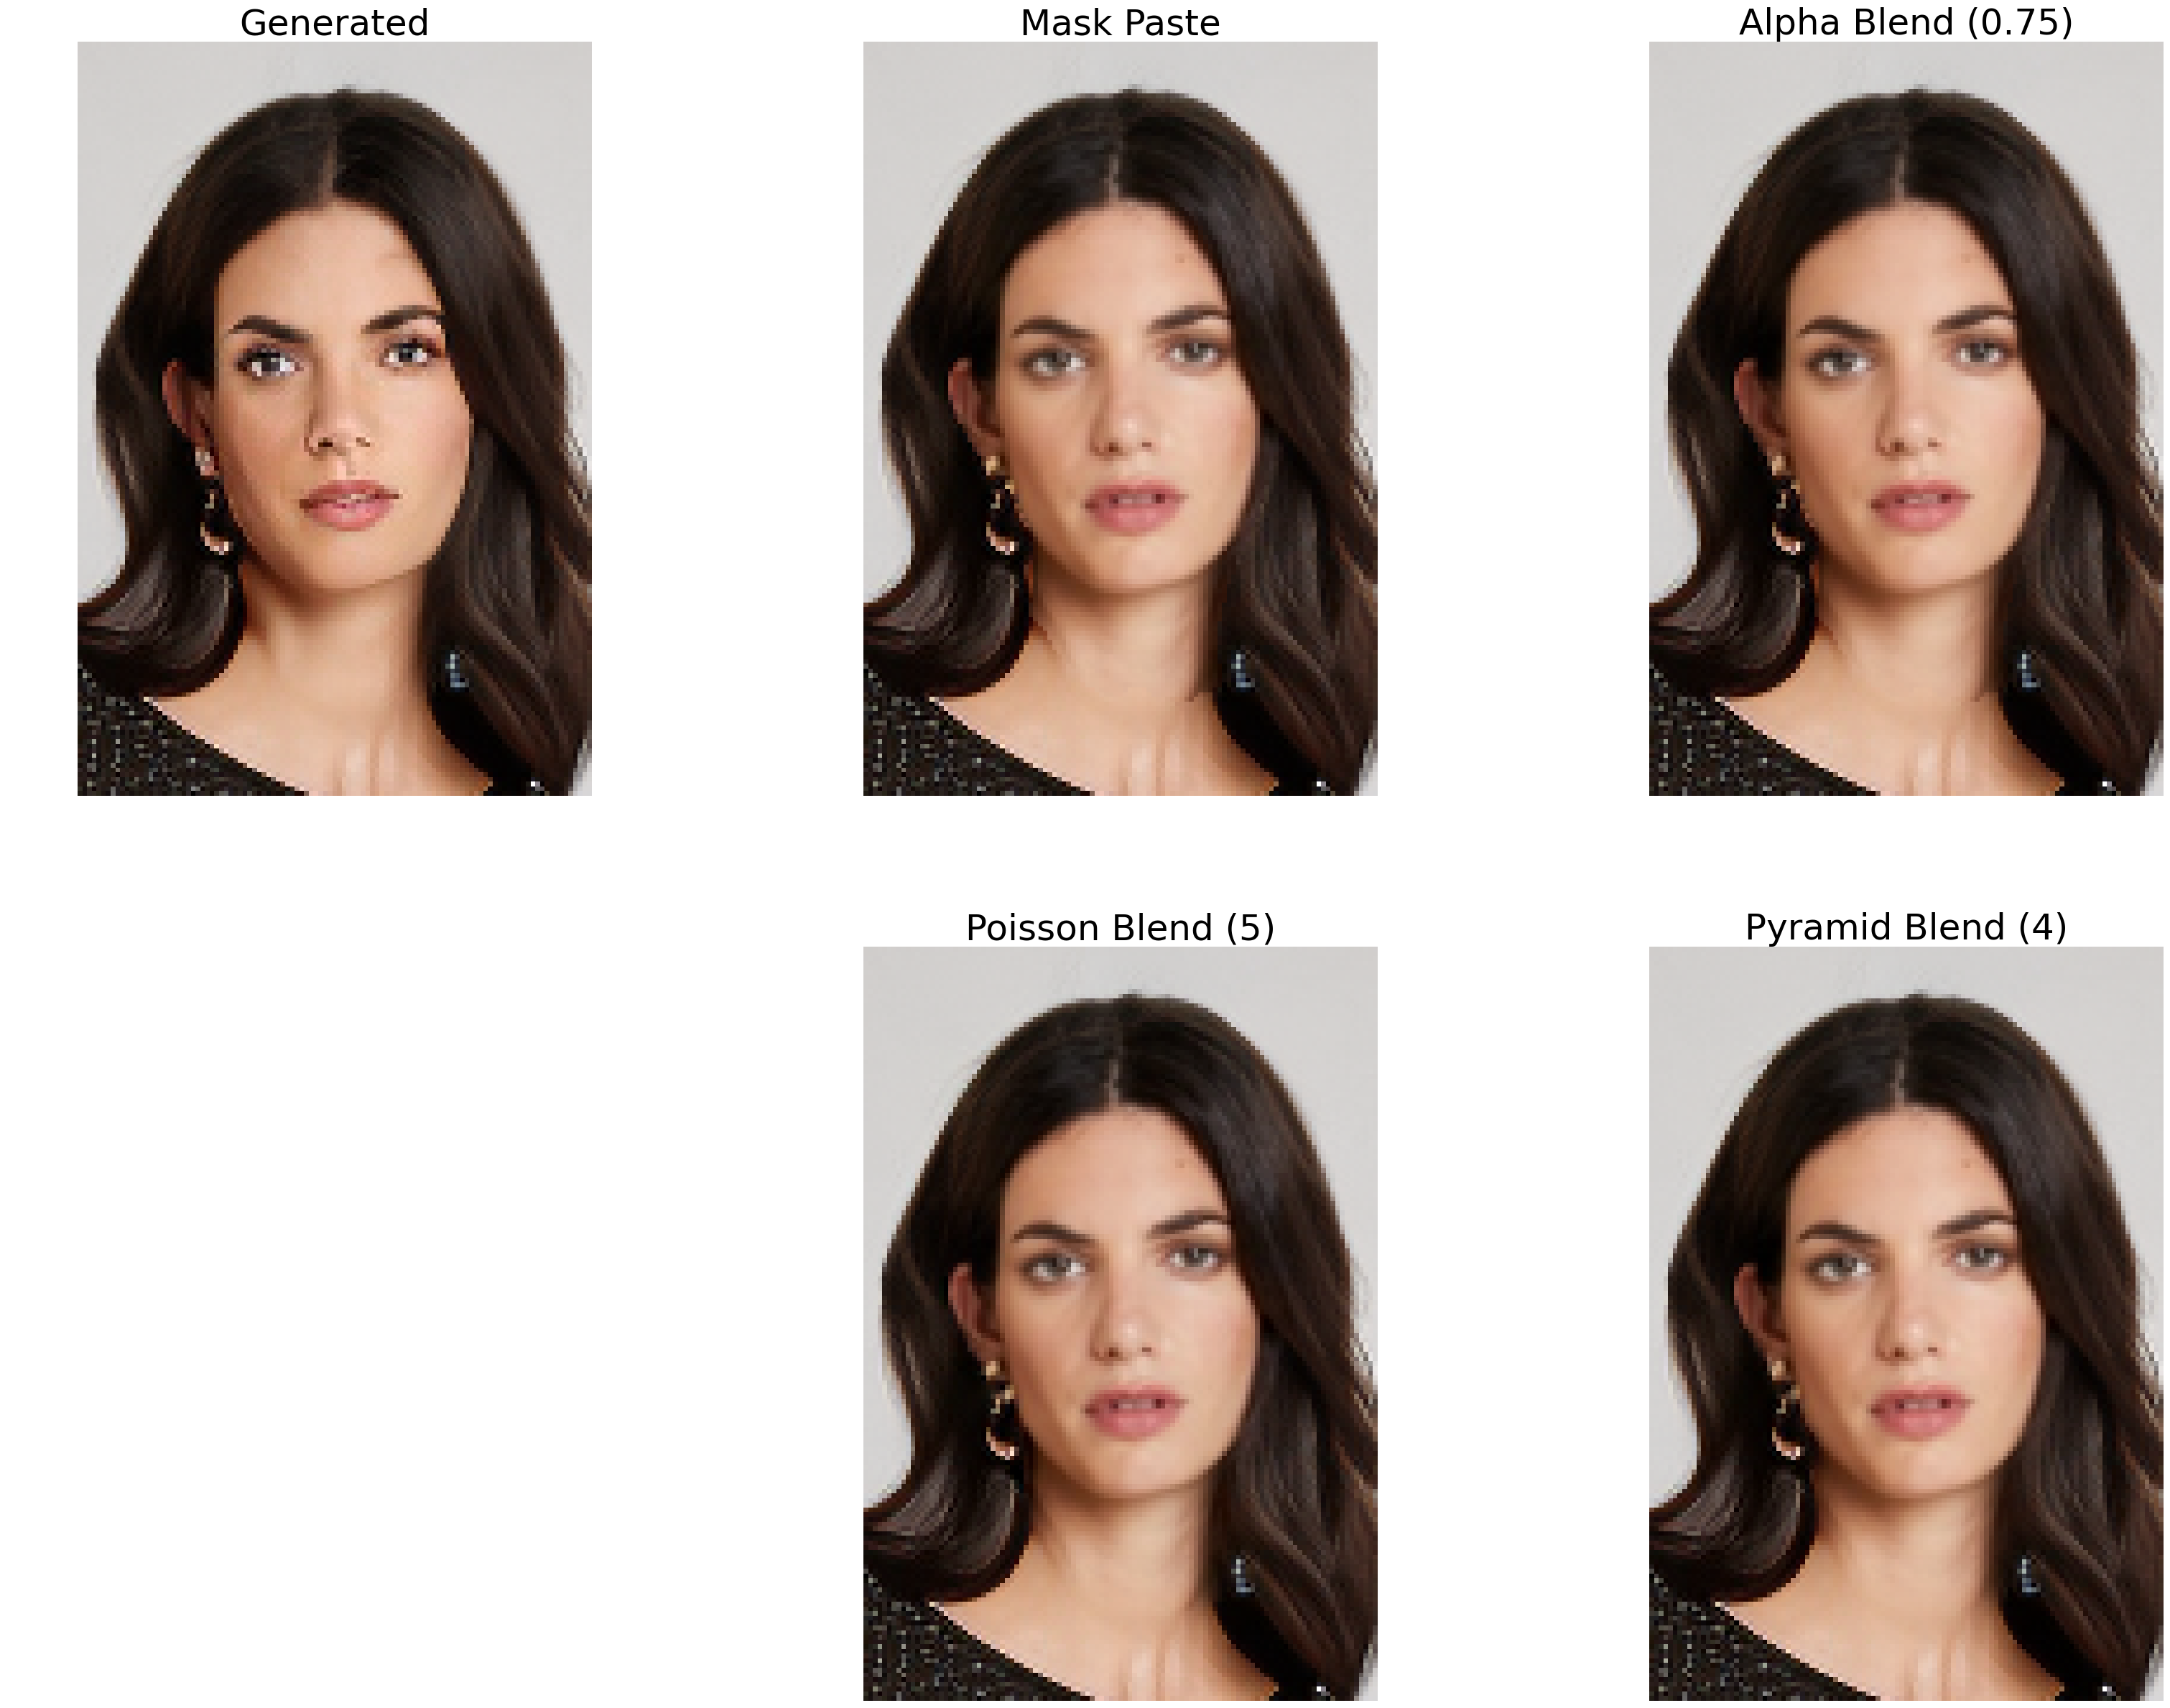

Processing 00458_00...


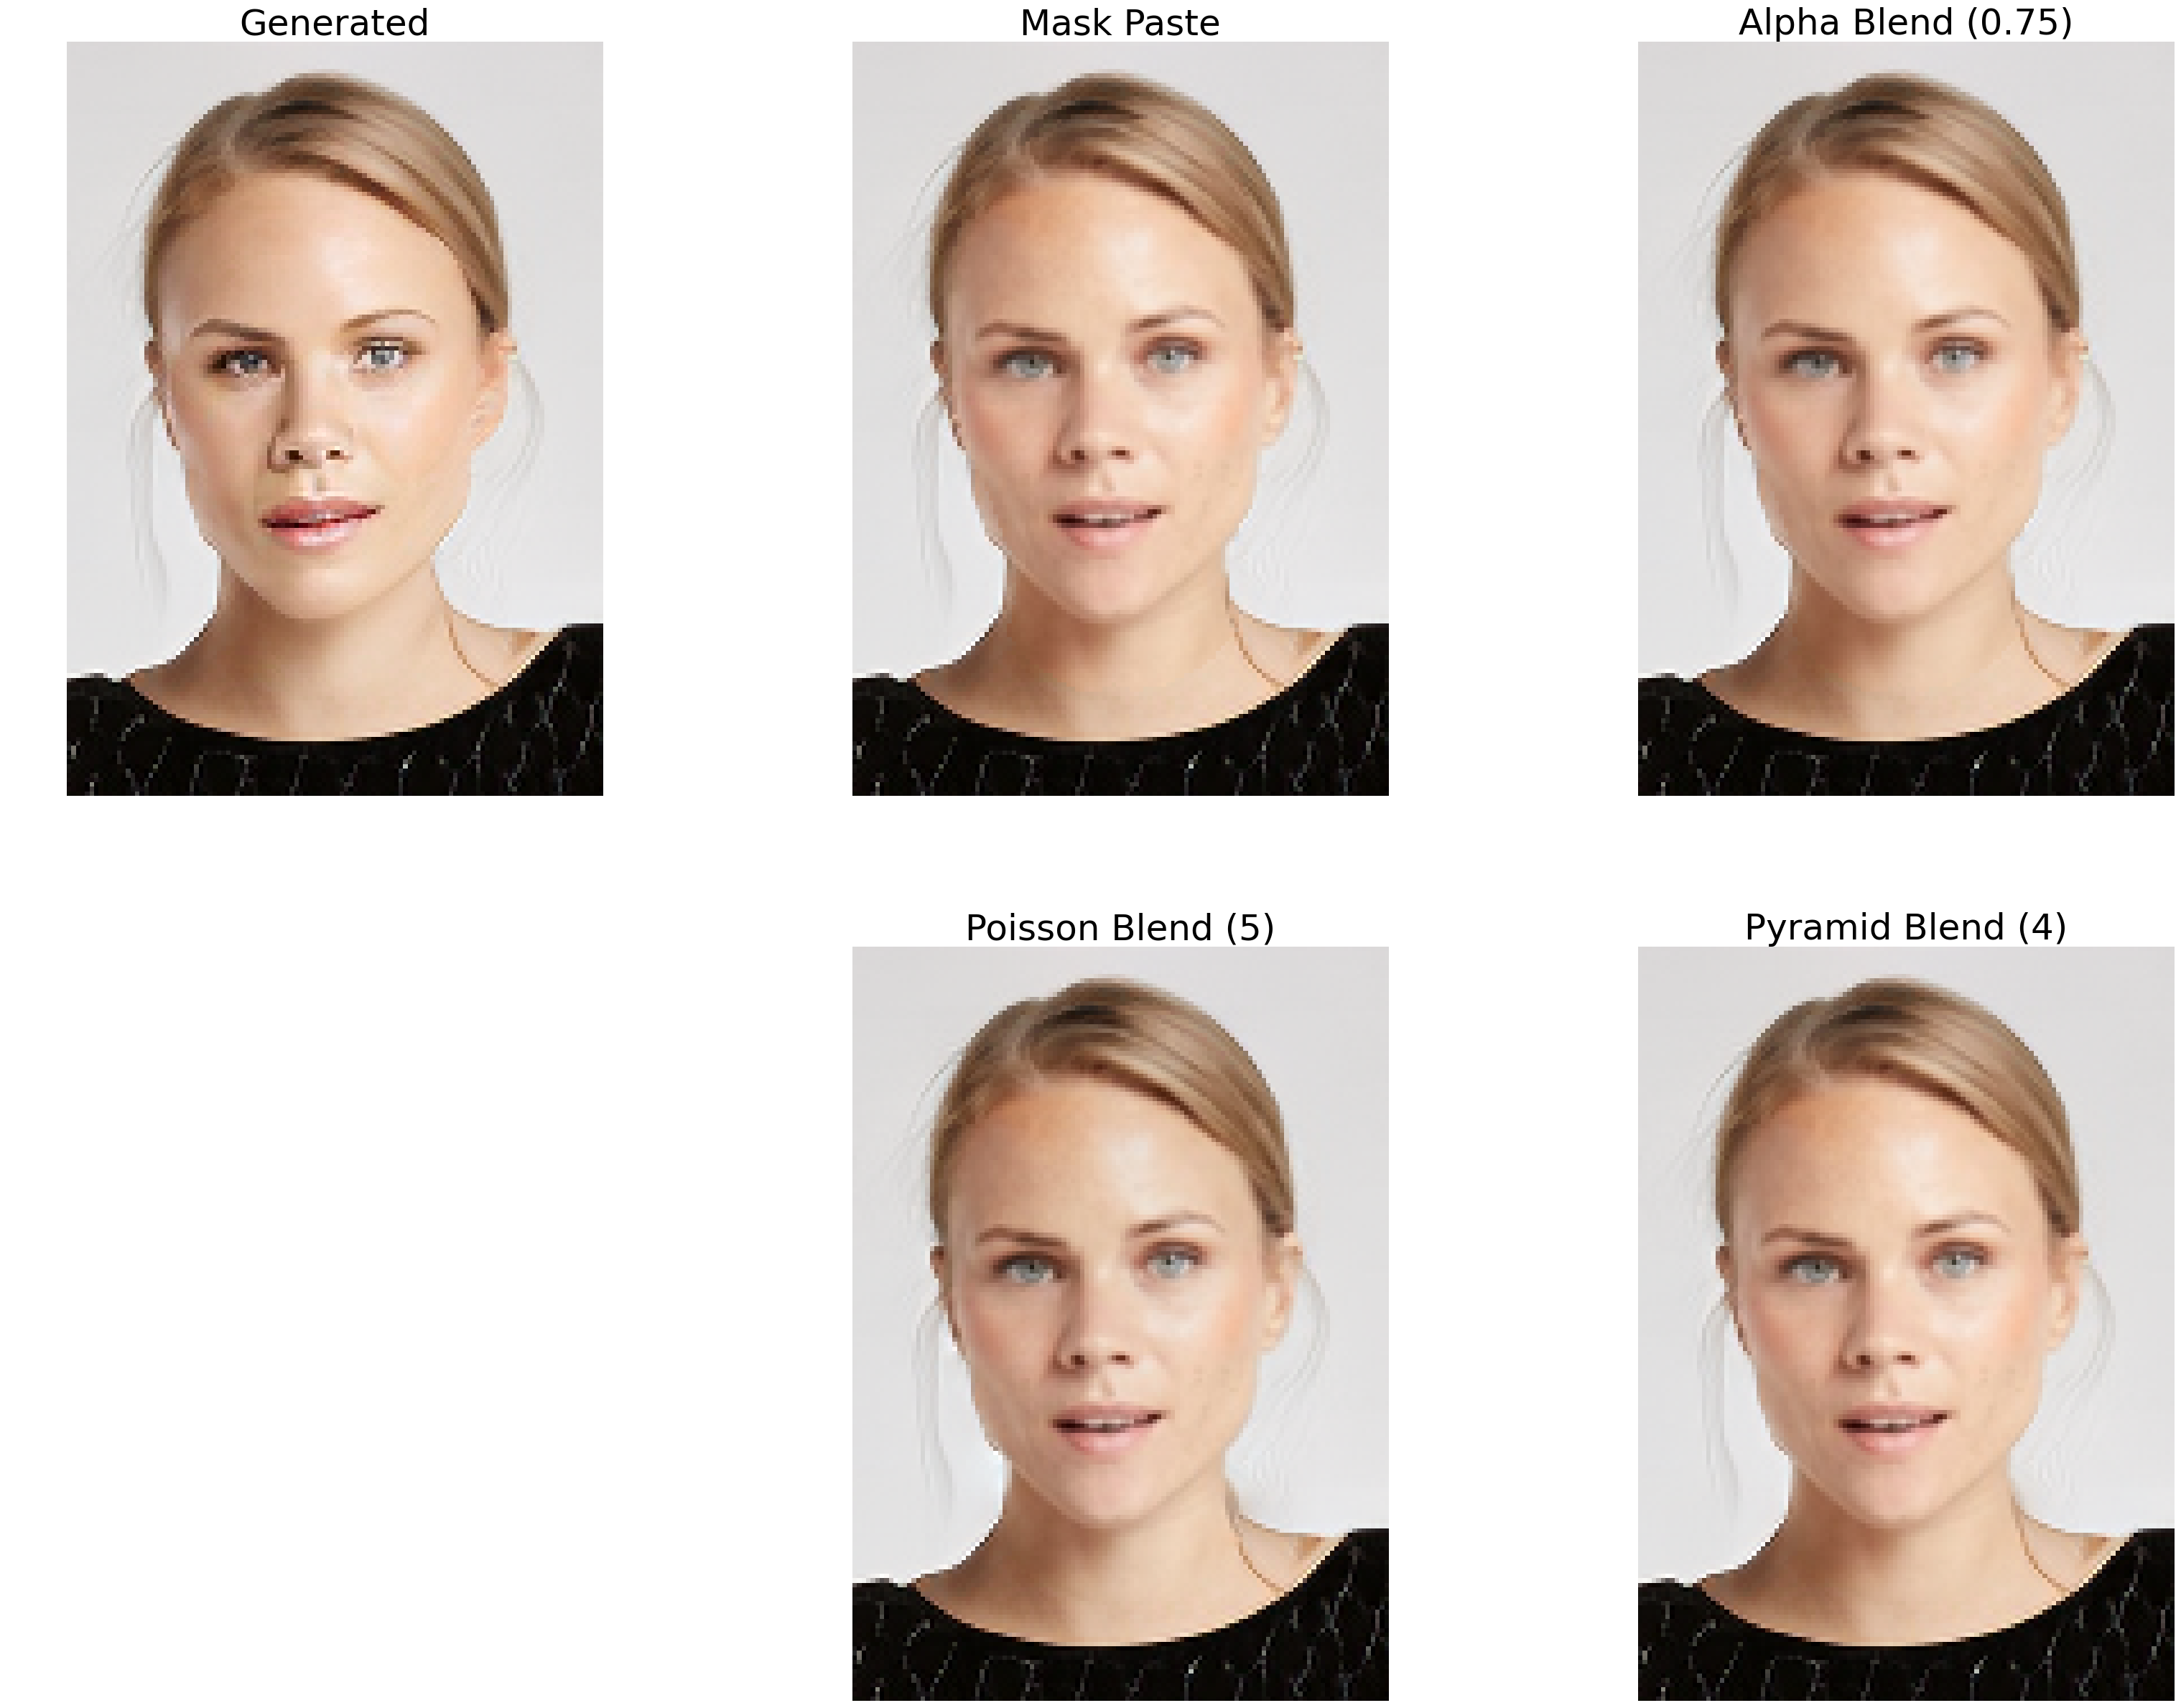

Processing 00466_00...


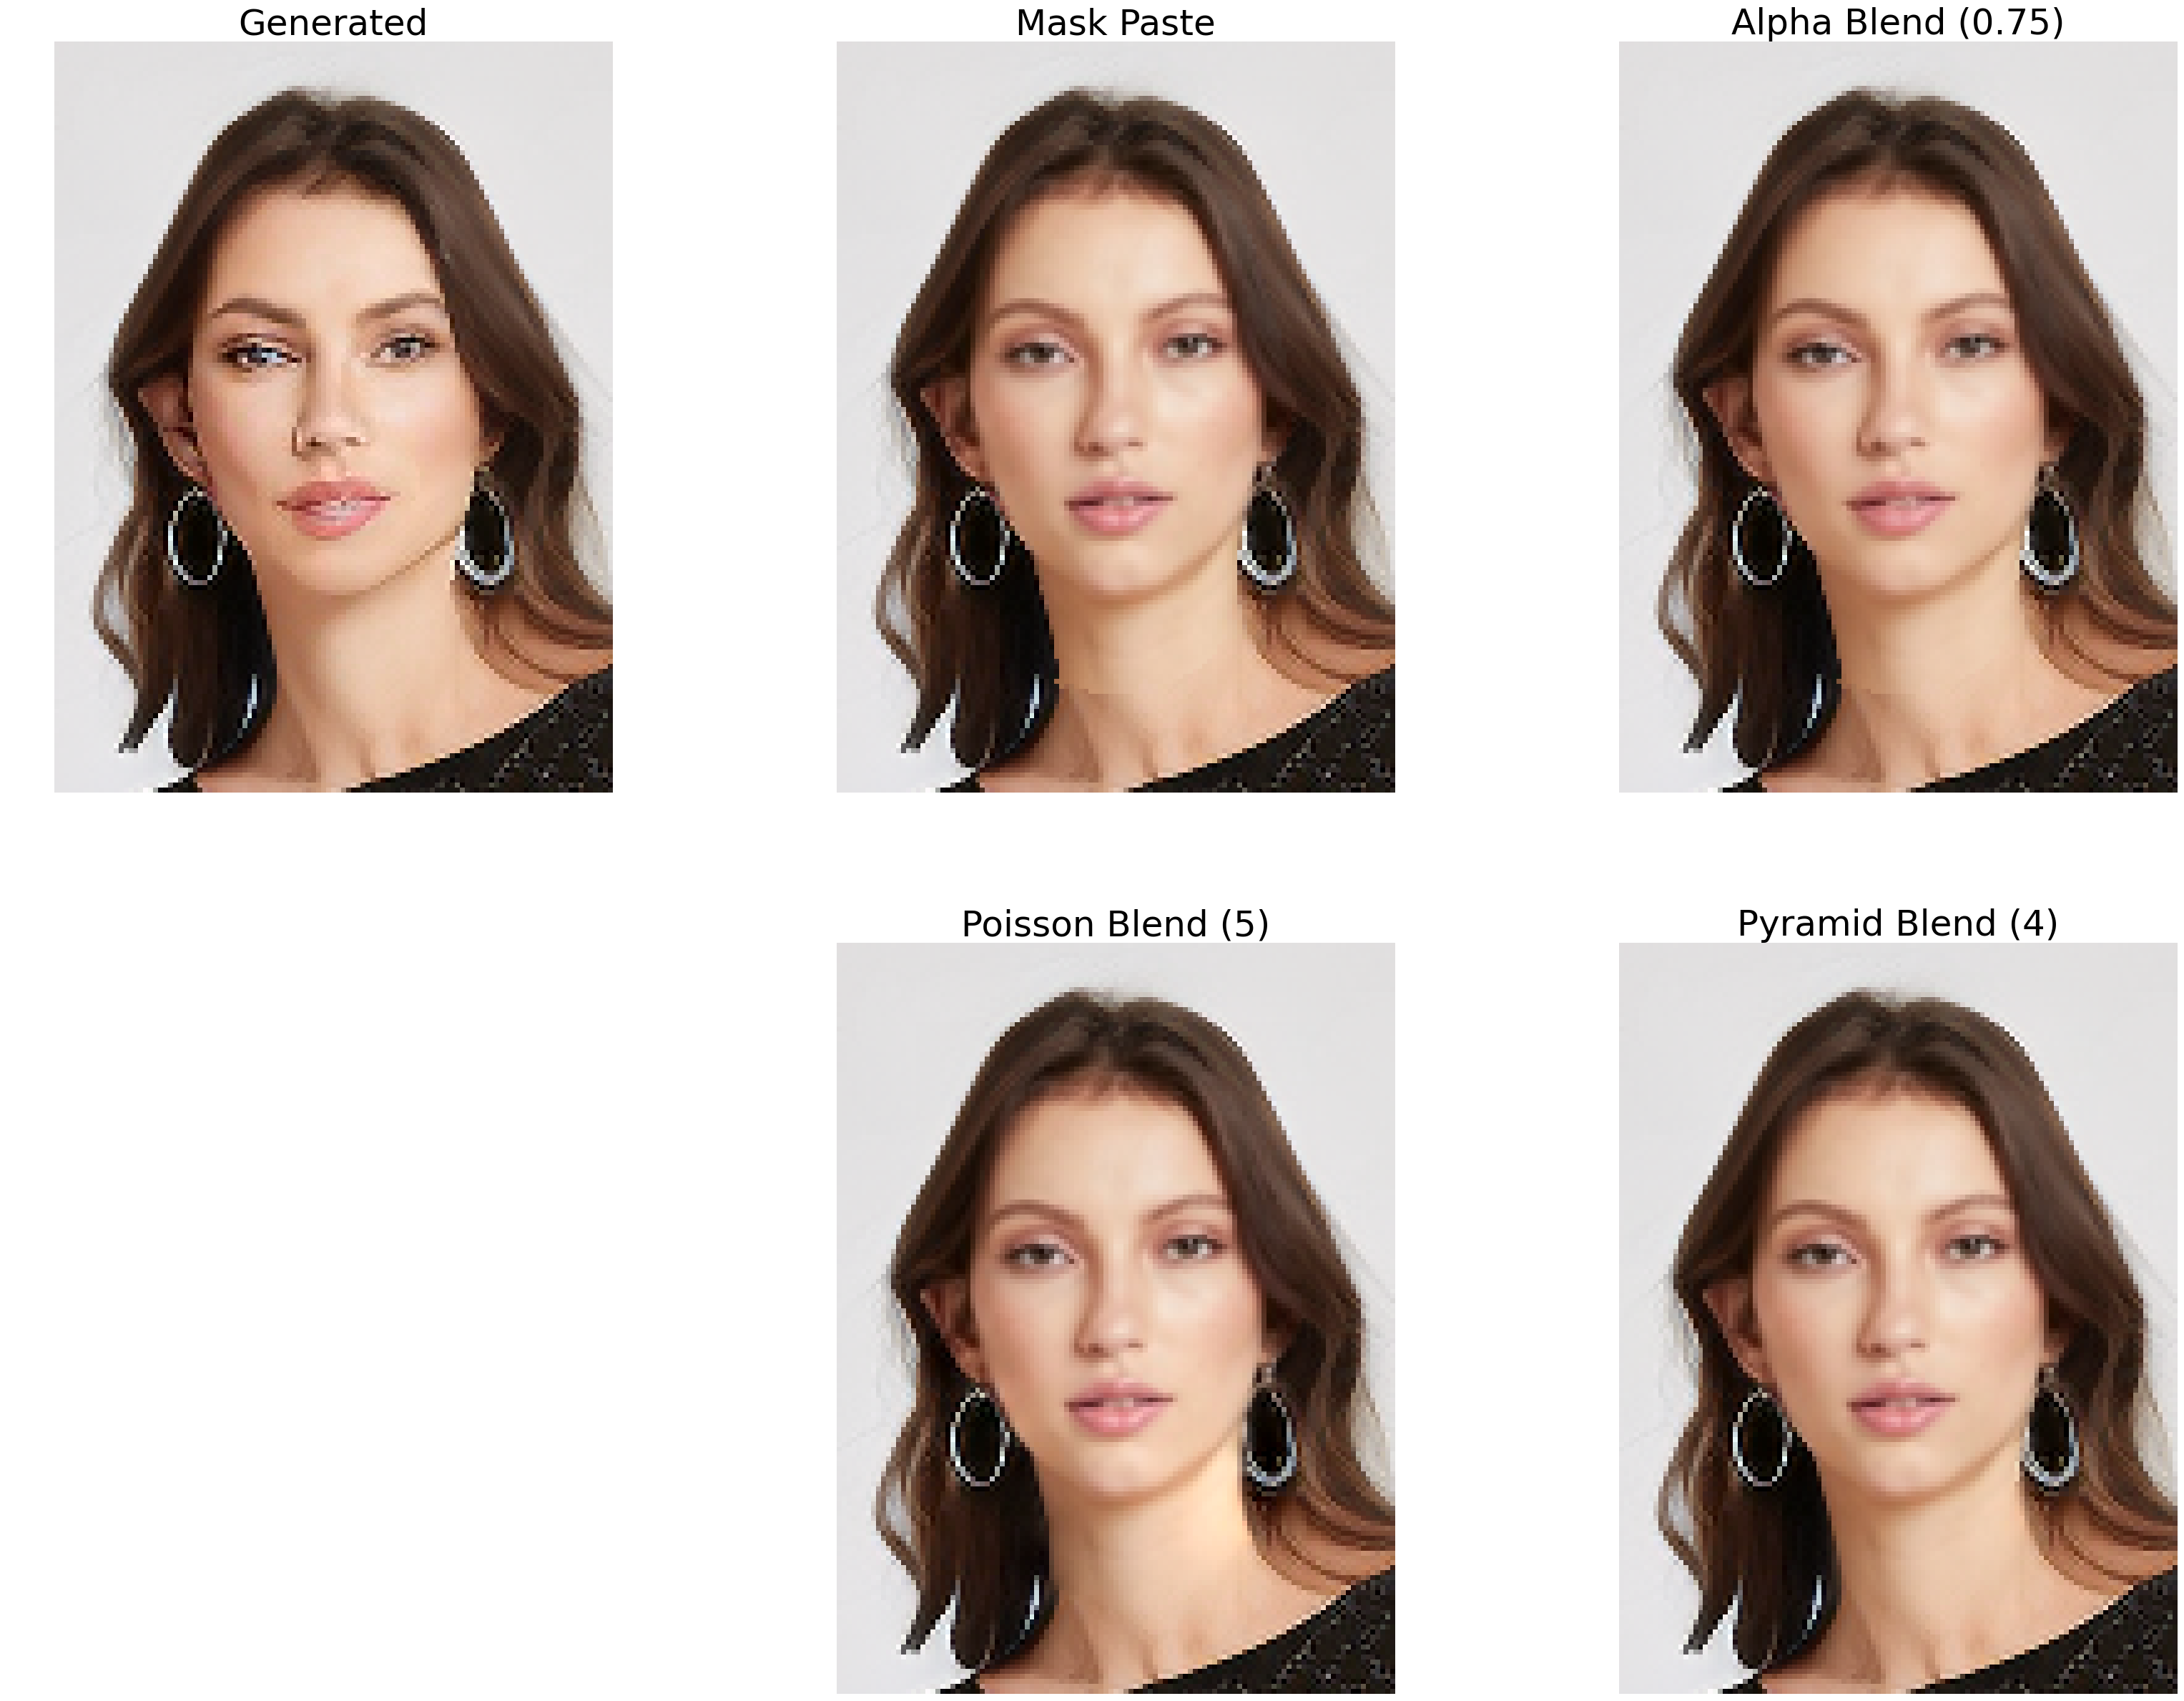

In [ ]:
ALPHA = 0.75
DILATION_SIZE = 5
PYRAMID_LEVEL = 4

# Use images from qualitative-analysis-images/originals, masks, and generated
image_folder = "qualitative-analysis-images"
originals_folder = os.path.join(image_folder, "originals")
masks_folder = os.path.join(image_folder, "masks")
generated_folder = os.path.join(image_folder, "generated")

# List all image ids based on files in originals folder
image_ids = [os.path.splitext(f)[0] for f in os.listdir(originals_folder) if f.endswith('.jpg') or f.endswith('.png')]

for img_id in image_ids:
    print(f"Processing {img_id}...")
    img_orig_path = os.path.join(originals_folder, f"{img_id}.jpg")
    if not os.path.exists(img_orig_path):
        img_orig_path = os.path.join(originals_folder, f"{img_id}.png")
    mask_path = os.path.join(masks_folder, f"{img_id}_head.png")
    gen_path = os.path.join(generated_folder, f"{img_id}.jpg")
    if not os.path.exists(gen_path):
        gen_path = os.path.join(generated_folder, f"{img_id}.png")

    img_orig = Image.open(img_orig_path).convert("RGB")
    img_orig = preprocess_img(img_orig)
    head_mask = Image.open(mask_path).convert("L")
    img_gen = Image.open(gen_path).convert("RGB")

    # Apply restorations
    pasted = restore_head(img_orig.copy(), img_gen.copy(), head_mask)
    alpha_blended = restore_head_alpha_blend(img_orig.copy(), img_gen.copy(), head_mask, ALPHA)
    poisson_blended = restore_head_poisson_blend(img_orig.copy(), img_gen.copy(), head_mask, DILATION_SIZE)
    pyramid_blended = restore_head_pyramid_blend(img_orig.copy(), img_gen.copy(), head_mask, PYRAMID_LEVEL)

    # crop the images to show the square region around the head
    x, y, w, h = cv2.boundingRect(np.array(head_mask))
    padding = 20
    x = max(x - padding, 0)
    y = max(y - padding, 0)
    w = min(w + 2 * padding, img_orig.width - x)
    h = min(h + 2 * padding, img_orig.height - y)

    img_gen = img_gen.crop((x, y, x + w, y + h))
    pasted = pasted.crop((x, y, x + w, y + h))
    alpha_blended = alpha_blended.crop((x, y, x + w, y + h))
    poisson_blended = poisson_blended.crop((x, y, x + w, y + h))
    pyramid_blended = pyramid_blended.crop((x, y, x + w, y + h))

    # Show results
    fig, axes = plt.subplots(2, 3, figsize=(40, 30))
    axes[0, 0].imshow(img_gen)
    axes[0, 0].set_title("Generated")
    axes[0, 1].imshow(pasted)
    axes[0, 1].set_title("Mask Paste")
    axes[0, 2].imshow(alpha_blended)
    axes[0, 2].set_title(f"Alpha Blend ({ALPHA})")
    axes[1, 1].imshow(poisson_blended)
    axes[1, 1].set_title(F"Poisson Blend ({DILATION_SIZE})")
    axes[1, 2].imshow(pyramid_blended)
    axes[1, 2].set_title(f"Pyramid Blend ({PYRAMID_LEVEL})")
    for ax_row in axes:
        for ax in ax_row:
            ax.axis("off")
    plt.savefig(f"./output/restored_plot/restored_{img_id}.png")
    plt.show()

## Sklep Kvalitativne Analize

Po primerjavi različnih metod zlivanja se zdi, da je najboljša metoda Pyramid blending, saj daje najbolj naraven izgled slike, približen izgled ima Poissonova metoda zlivanja, ampak ne toliko kot Pyramid. Najslabša metoda je Alpha blending, ki daje zelo opazen rob okoli glave in ne izgleda naravno.